In [1]:
import pandas as pd

# Load the uploaded Excel file to check its structure
file_path = '../dataset/rab107row.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows to understand the structure
data.head()

namaproyek           rab  waktu     provinsi  tahun       luas  \
0  Gedung Apartemen  2.641914e+10    196   Jawa Barat   2019   17401.00   
1  Gedung Apartemen  8.821079e+10    273  DKI Jakarta   2022   16320.59   
2  Gedung Apartemen  8.171200e+10    348  DKI Jakarta   2023   23688.00   
3  Gedung Apartemen  3.690000e+11    830       Banten   2021   55000.00   
4  Gedung Apartemen  5.400316e+11    700  DKI Jakarta   2023  150000.00   

   subitem  tinggi  lantai     ikk    ihbp  inflasi  
0        4    21.8       6  103.03  143.72     3.21  
1        6    47.6      14  121.48  107.66     4.21  
2        5    34.0      10  116.73  113.88     2.28  
3        6    49.8      16   97.64  109.64     1.91  
4        6   105.0      30  116.73  113.88     2.28

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import BayesianRidge, Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [3]:
import numpy as np

numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Retry applying log transformation with numpy properly imported
transformed_data = data.copy()
for col in numerical_columns:
    transformed_data[col] = data[col].apply(lambda x: np.log1p(x) if x > 0 else x)

In [4]:
transformed_data.head()

namaproyek        rab     waktu     provinsi     tahun       luas  \
0  Gedung Apartemen  23.997354  5.283204   Jawa Barat  7.610853   9.764340   
1  Gedung Apartemen  25.202995  5.613128  DKI Jakarta  7.612337   9.700244   
2  Gedung Apartemen  25.126467  5.855072  DKI Jakarta  7.612831  10.072766   
3  Gedung Apartemen  26.634062  6.722630       Banten  7.611842  10.915107   
4  Gedung Apartemen  27.014893  6.552508  DKI Jakarta  7.612831  11.918397   

    subitem    tinggi    lantai       ikk      ihbp   inflasi  
0  1.609438  3.126761  1.945910  4.644679  4.974801  1.437463  
1  1.945910  3.883624  2.708050  4.807948  4.688224  1.650580  
2  1.791759  3.555348  2.397895  4.768394  4.743888  1.187843  
3  1.945910  3.927896  2.833213  4.591477  4.706282  1.068153  
4  1.945910  4.663439  3.433987  4.768394  4.743888  1.187843

In [5]:
cekduplikat = transformed_data[transformed_data.duplicated()]
cekduplikat

namaproyek        rab     waktu provinsi     tahun       luas  \
22  Gedung Apartemen  26.146404  6.594413   Banten  7.611348  10.465096   

     subitem    tinggi    lantai       ikk      ihbp   inflasi  
22  1.791759  4.697293  3.465736  4.585478  4.650908  0.896088

In [6]:
transformed_data = transformed_data.drop_duplicates()

cekduplikat = transformed_data[transformed_data.duplicated()]
cekduplikat, transformed_data.shape

(Empty DataFrame
 Columns: [namaproyek, rab, waktu, provinsi, tahun, luas, subitem, tinggi, lantai, ikk, ihbp, inflasi]
 Index: [],
 (106, 12))

In [7]:
# Fungsi untuk mendeteksi outlier menggunakan metode IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Analisis outlier untuk setiap kolom numerik
outlier_results = {}
for col in numerical_columns:
    outliers, lower, upper = detect_outliers_iqr(transformed_data, col)
    outlier_results[col] = {
        "outliers_count": len(outliers),
        "lower_bound": lower,
        "upper_bound": upper
    }

# Menampilkan hasil analisis outlier
outlier_results

{'rab': {'outliers_count': 0,
  'lower_bound': 19.942509309324343,
  'upper_bound': 29.878975866310945},
 'waktu': {'outliers_count': 0,
  'lower_bound': 4.115594293821956,
  'upper_bound': 7.292699322311036},
 'tahun': {'outliers_count': 0,
  'lower_bound': 7.60788543037709,
  'upper_bound': 7.615798390425516},
 'luas': {'outliers_count': 0,
  'lower_bound': 4.626135712885208,
  'upper_bound': 13.50521030326389},
 'subitem': {'outliers_count': 24,
  'lower_bound': 1.5605334494871674,
  'upper_bound': 2.1771361687962005},
 'tinggi': {'outliers_count': 0,
  'lower_bound': 0.5451998640506068,
  'upper_bound': 6.24499765950352},
 'lantai': {'outliers_count': 0,
  'lower_bound': -0.6446193937132167,
  'upper_bound': 4.9199129867178755},
 'ikk': {'outliers_count': 1,
  'lower_bound': 4.459107497071852,
  'upper_bound': 4.953965689101057},
 'ihbp': {'outliers_count': 0,
  'lower_bound': 4.2583580911778816,
  'upper_bound': 5.404666491032535},
 'inflasi': {'outliers_count': 2,
  'lower_bound'

In [8]:
# Fungsi untuk mendeteksi dan menghapus baris yang mengandung outlier
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Hapus baris yang memiliki nilai outlier
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Hapus outlier untuk setiap kolom numerik
data_cleaned = transformed_data.copy()
for col in numerical_columns:
    data_cleaned = remove_outliers_iqr(data_cleaned, col)

In [9]:
data_cleaned.shape

(80, 12)

In [10]:
# Label encoding kolom 'Provinsi' dan nama proyek karena nilainya kategorikal
label_encoder = LabelEncoder()
data_cleaned['label_provinsi'] = label_encoder.fit_transform(data_cleaned['provinsi'])
data_cleaned['label_namaproyek'] = label_encoder.fit_transform(data_cleaned['namaproyek'])

# Melihat nilai unik dari hasil encoding kolom 'provinsi_encoded'
provinsi_unik = data_cleaned[['provinsi', 'label_provinsi']].drop_duplicates().sort_values(
    by='label_provinsi')

# Melihat nilai unik dari hasil encoding kolom 'namaproyek_encoded'
namaproyek_unik = data_cleaned[['namaproyek', 'label_namaproyek']].drop_duplicates().sort_values(
    by='label_namaproyek')

In [11]:
provinsi_unik

provinsi  label_provinsi
95                 Bali               0
3                Banten               1
1           DKI Jakarta               2
0            Jawa Barat               3
23          Jawa Tengah               4
59           Jawa Timur               5
66     Kalimantan Timur               6
55       Kepulauan Riau               7
25  Nusa Tenggara Barat               8
41                Papua               9
70     Sulawesi Selatan              10

In [12]:
namaproyek_unik

namaproyek  label_namaproyek
0       Gedung Apartemen                 0
35         Gedung Asrama                 1
43         Gedung Gudang                 2
45          Gedung Hotel                 3
49         Gedung Kampus                 4
55         Gedung Kantor                 5
76   Gedung Laboratorium                 6
81       Gedung Olahraga                 7
83         Gedung Pabrik                 8
84         Gedung Parkir                 9
88    Gedung Rumah Sakit                10
96    Gedung Rumah Susun                11
102       Gedung Sekolah                12
105        Gedung Wisata                13

In [13]:
# 4. Normalisasi Kolom Numerik
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

numerical_columns = ['waktu', 'tahun', 'luas', 'subitem', 
                     'tinggi', 'lantai', 'ikk', 'ihbp', 'inflasi']
# 4. Normalisasi Kolom Numerik
scalerMinMax = MinMaxScaler()
data_cleaned[numerical_columns] = scalerMinMax.fit_transform(data_cleaned[numerical_columns])

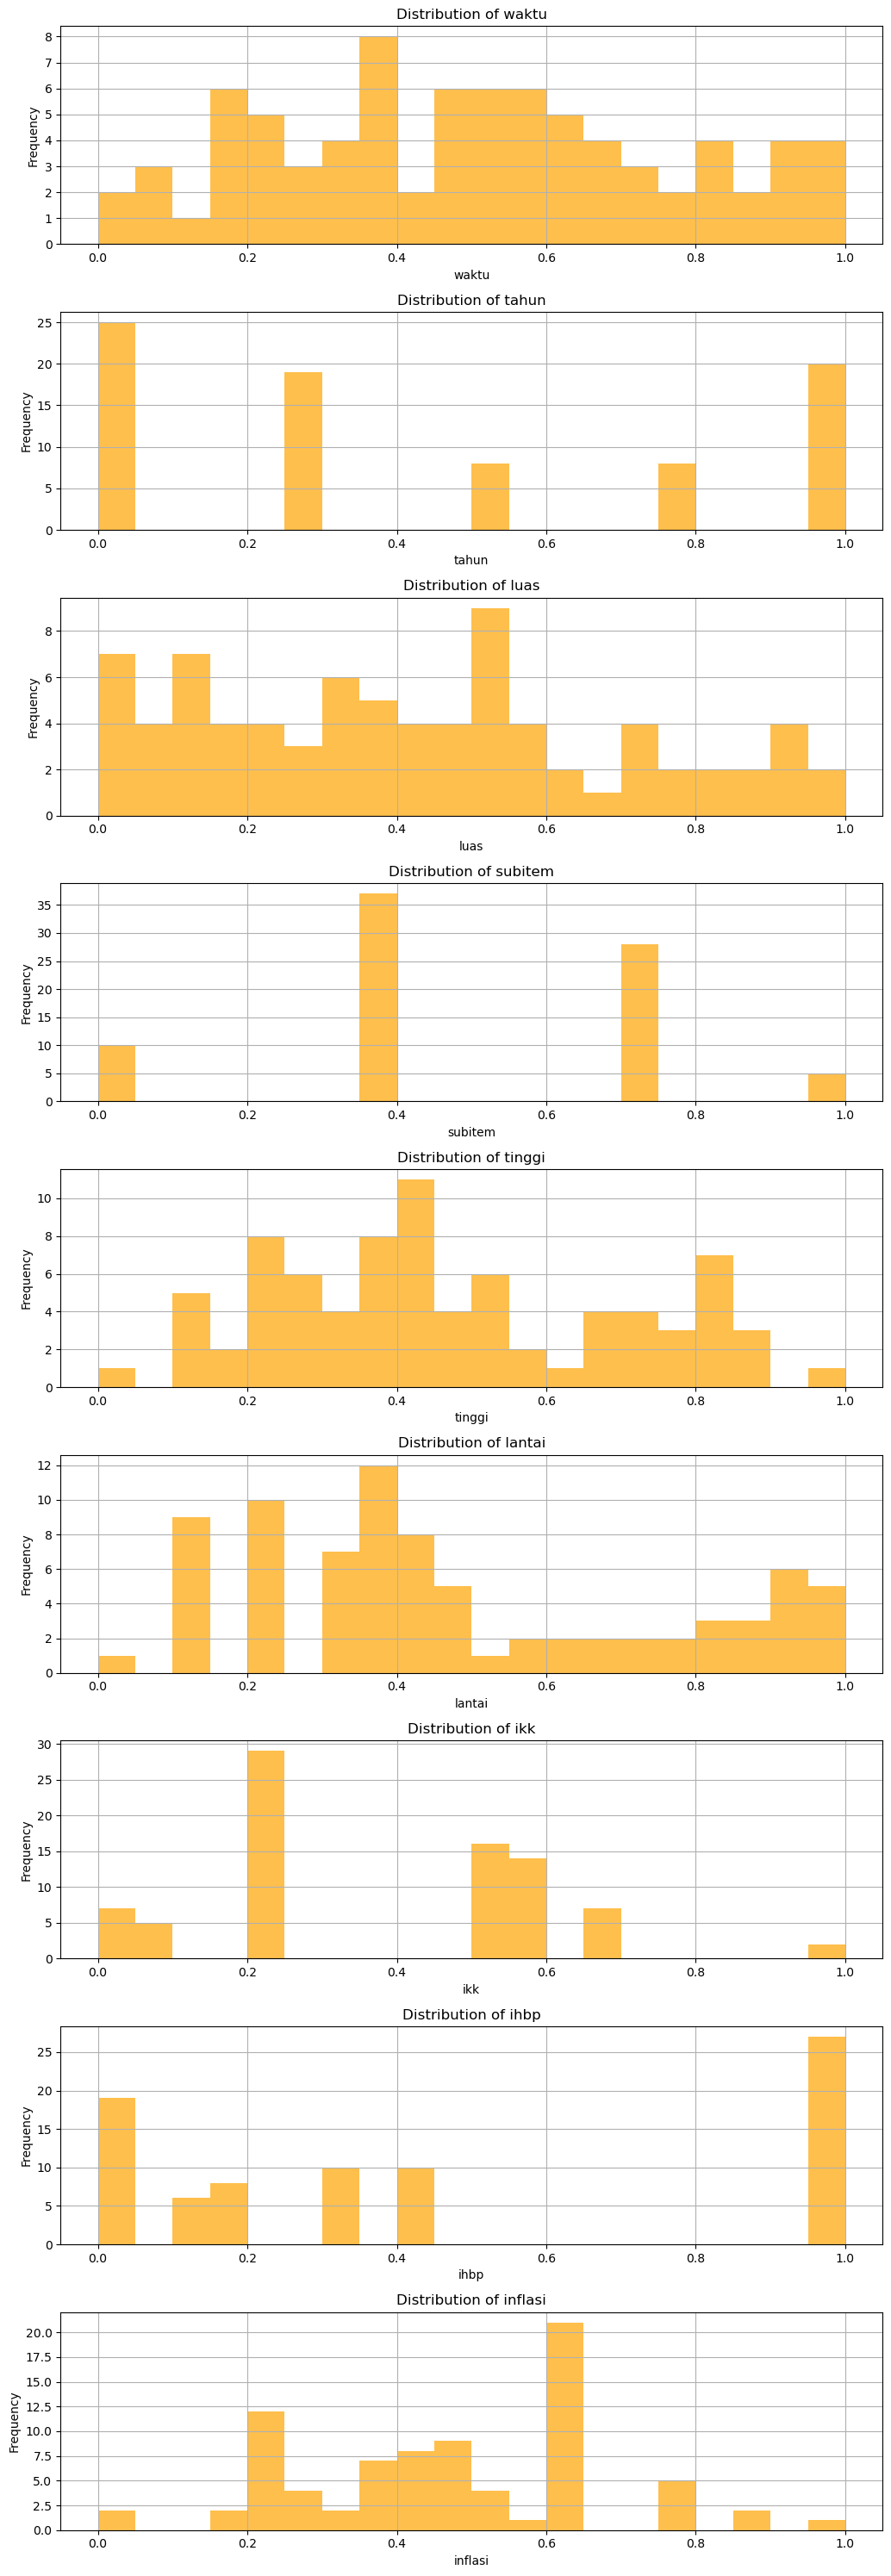

In [14]:
# Compare distributions before and after transformation using histograms
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 30))
for i, col in enumerate(numerical_columns, 1):

    # Transformed data
    plt.subplot(len(numerical_columns), 2, 2 * i)
    data_cleaned[col].hist(bins=20, alpha=0.7, color='orange')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

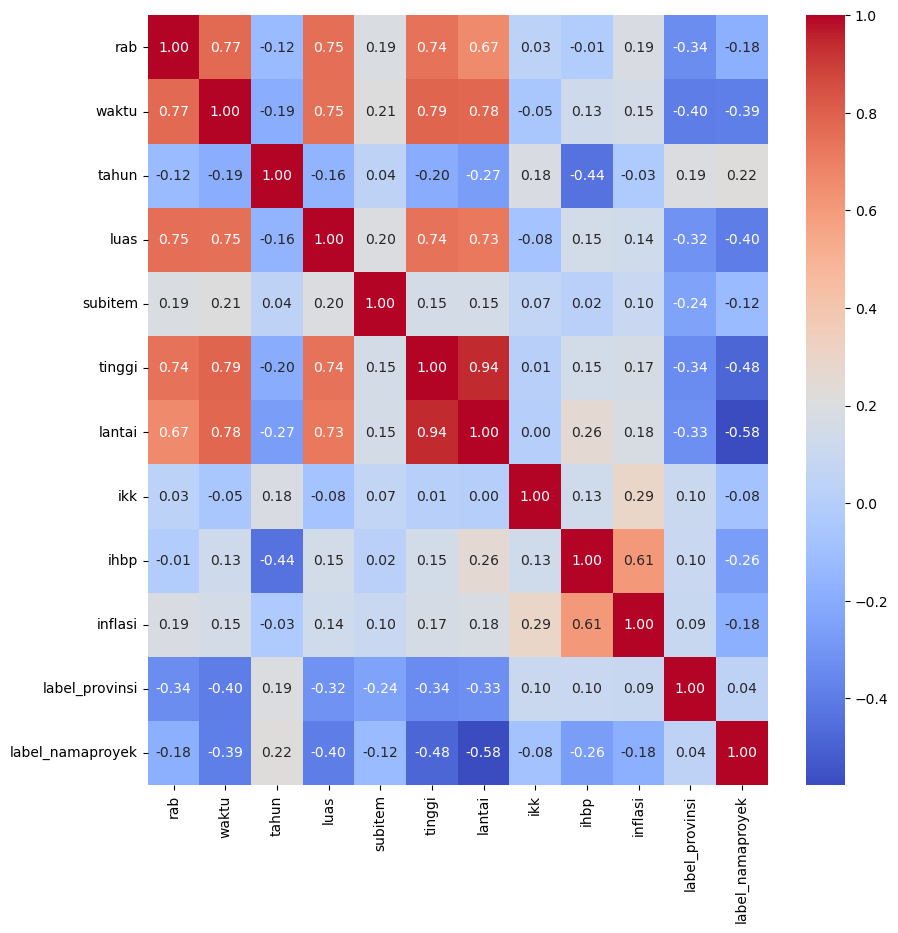

In [15]:
# Digunakan untuk membuat visualisasi dalam bentuk grafik atau plot
import seaborn as sns
import matplotlib.pyplot as plt
# Visualisasi korelasi antar fitur atau kolom apakah saling berpengaruh atau tidak
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(data_cleaned.corr(numeric_only=True), 
            annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
plt.show()

In [16]:
# Split data into features and target
X1 = data_cleaned.drop(columns=[
    'rab', 'namaproyek', 'provinsi', 'lantai'])
y1 = data_cleaned['rab']

# Split into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X1, y1, 
    test_size=0.3, 
    random_state=42)

# Split into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X1, y1, 
    test_size=0.2, 
    random_state=42)

In [17]:
# Initialize models
models1 = {
    'AdaBoost': AdaBoostRegressor(),
    'Bayesian Ridge': BayesianRidge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'KNN Regressor': KNeighborsRegressor(),
    'Lasso Regression': Lasso(),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Ridge Regression': Ridge(),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor()
}

models2 = {
    'AdaBoost': AdaBoostRegressor(),
    'Bayesian Ridge': BayesianRidge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'KNN Regressor': KNeighborsRegressor(),
    'Lasso Regression': Lasso(),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Ridge Regression': Ridge(),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor()
}

# 70:30
# Train and evaluate each model with additional metrics
results1 = []
for name1, model1 in models1.items():
    # Fit model to training data
    model1.fit(X_train1, y_train1)
    
    # Predict on training data
    y_train_pred1 = model1.predict(X_train1)
    
    # Predict on testing data
    y_pred1 = model1.predict(X_test1)
    
    # Calculate metrics for training data
    r2_train1 = r2_score(y_train1, y_train_pred1)
    
    # Calculate metrics for testing data
    mse1 = mean_squared_error(y_test1, y_pred1)
    mae1 = mean_absolute_error(y_test1, y_pred1)
    r21 = r2_score(y_test1, y_pred1)
    
    # Append results
    results1.append({
        'Model': name1,
        'Training R2 Score': r2_train1,
        'Testing RMSE': np.sqrt(mse1),
        'Testing MAE': mae1,
        'Testing R2 Score': r21
    })

# Convert results into a DataFrame for better visualization
results_df1 = pd.DataFrame(results1).sort_values(by='Testing R2 Score', ascending=False)

# 80:20
# Train and evaluate each model with additional metrics
results2 = []
for name2, model2 in models2.items():
    # Fit model to training data
    model2.fit(X_train2, y_train2)
    
    # Predict on training data
    y_train_pred2 = model2.predict(X_train2)
    
    # Predict on testing data
    y_pred2 = model2.predict(X_test2)
    
    # Calculate metrics for training data
    r2_train2 = r2_score(y_train2, y_train_pred2)
    
    # Calculate metrics for testing data
    mse2 = mean_squared_error(y_test2, y_pred2)
    mae2 = mean_absolute_error(y_test2, y_pred2)
    r22 = r2_score(y_test2, y_pred2)
    
    # Append results
    results2.append({
        'Model': name2,
        'Training R2 Score': r2_train2,
        'Testing RMSE': np.sqrt(mse2),
        'Testing MAE': mae2,
        'Testing R2 Score': r22
    })

# Convert results into a DataFrame for better visualization
results_df2 = pd.DataFrame(results2).sort_values(by='Testing R2 Score', ascending=False)


In [18]:
results_df1

Model  Training R2 Score  Testing RMSE  Testing MAE  \
8    Ridge Regression           0.759250      0.650896     0.468032   
7       Random Forest           0.927649      0.656317     0.508484   
3   Gradient Boosting           0.998679      0.659861     0.507708   
0            AdaBoost           0.916127      0.683997     0.547522   
1      Bayesian Ridge           0.782985      0.707531     0.500271   
10            XGBoost           1.000000      0.726871     0.558088   
6   Linear Regression           0.787927      0.784194     0.585081   
2       Decision Tree           1.000000      0.989372     0.756484   
4       KNN Regressor           0.293848      1.242442     1.036006   
9                 SVR           0.293089      1.295689     1.067453   
5    Lasso Regression           0.057010      1.503862     1.267647   

    Testing R2 Score  
8           0.802521  
7           0.799218  
3           0.797044  
0           0.781925  
1           0.766660  
10          0.753730  
6           0.713355  
2           0.543735  
4           0.280468  
9           0.217474  
5          -0.054177

In [20]:
results_df2

Model  Training R2 Score  Testing RMSE  Testing MAE  \
10            XGBoost           1.000000      0.521440     0.440594   
8    Ridge Regression           0.759645      0.629419     0.408560   
7       Random Forest           0.927225      0.662510     0.476372   
1      Bayesian Ridge           0.777645      0.684726     0.447111   
3   Gradient Boosting           0.996536      0.719038     0.501374   
6   Linear Regression           0.781002      0.740000     0.516679   
0            AdaBoost           0.909350      0.742769     0.545164   
2       Decision Tree           1.000000      1.178829     0.907236   
4       KNN Regressor           0.357278      1.285939     1.063708   
9                 SVR           0.298835      1.324057     1.065418   
5    Lasso Regression           0.032011      1.565097     1.341518   

    Testing R2 Score  
10          0.883089  
8           0.829656  
7           0.811274  
1           0.798404  
3           0.777694  
6           0.764543  
0           0.762778  
2           0.402484  
4           0.288969  
9           0.246192  
5          -0.053247

Untuk Hasil 70:30

Ridge Regression

In [21]:
# Ambil model terbaik dari split data 70:30
best_model_name1 = results_df1.iloc[0]['Model']
best_model1 = models1[best_model_name1]

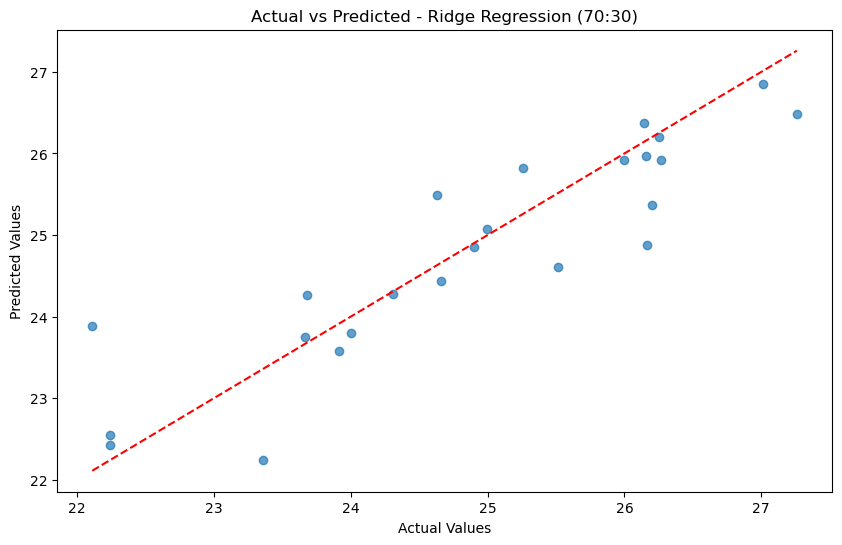

In [22]:
import matplotlib.pyplot as plt

y_actual1 = y_test1
y_pred_best1 = best_model1.predict(X_test1)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name1} (70:30)")
plt.show()

In [24]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.234436
0   23.997354  23.799654
27  26.199729  25.363963
39  22.237415  22.424352
21  26.146404  26.369829


In [25]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 4.532.032.787
0    Rp 26.419.136.187   Rp 21.679.955.022
27  Rp 239.000.000.001  Rp 103.616.601.052
39    Rp 4.545.551.009    Rp 5.479.893.836
21  Rp 226.589.000.001  Rp 283.316.008.122
35    Rp 4.545.551.009    Rp 6.176.317.030
10  Rp 120.781.089.488   Rp 48.633.559.090
92  Rp 228.530.000.001  Rp 189.922.186.972
4   Rp 540.031.588.145  Rp 460.158.219.124
13  Rp 195.596.000.001  Rp 181.258.291.694
64   Rp 65.000.000.001   Rp 62.024.954.255
41   Rp 24.322.000.001   Rp 17.314.962.622
88   Rp 35.905.245.001   Rp 34.867.805.061
43   Rp 18.970.782.261   Rp 20.713.659.753
89   Rp 93.541.144.803  Rp 162.986.558.354
59    Rp 3.997.225.850   Rp 23.569.038.564
95  Rp 690.000.000.001  Rp 315.810.638.711
78   Rp 49.559.404.693  Rp 117.230.433.494
72  Rp 230.570.298.290   Rp 63.921.476.332
52  Rp 254.967.000.193  Rp 181.064.922.434
9   Rp 251.146.002.001  Rp 240.538.923.259
83   Rp 71.420.000.001   Rp 77.110.288.760
5    Rp 51.

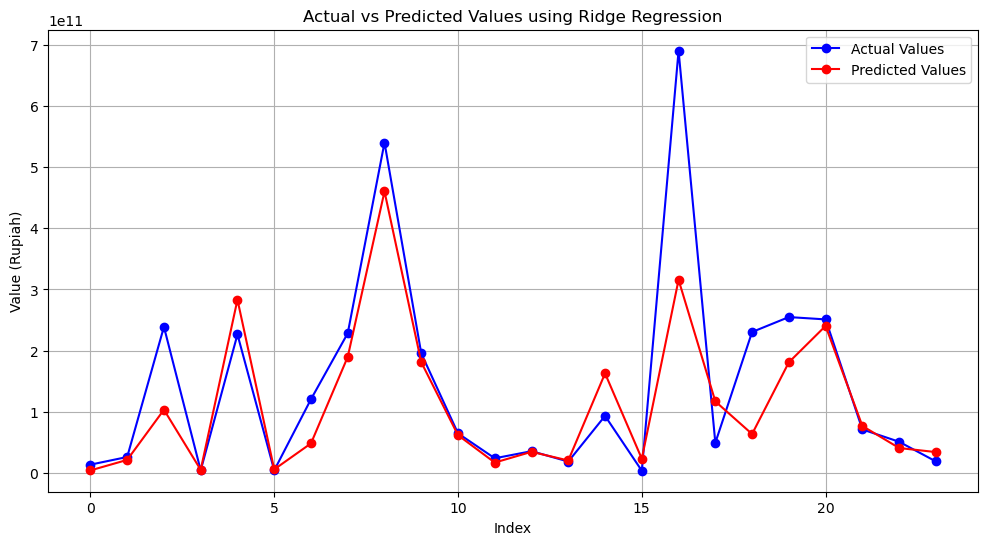

In [32]:
# Identify the best model based on Testing R² Score
best_model_name1 = results_df1.iloc[0]['Model']
best_model1 = models1[best_model_name1]

# Predict on the test data
y_pred_log1 = best_model1.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df1 = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df1.index, comparison_df1['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df1.index, comparison_df1['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name1}')
plt.legend()
plt.grid(True)
plt.show()


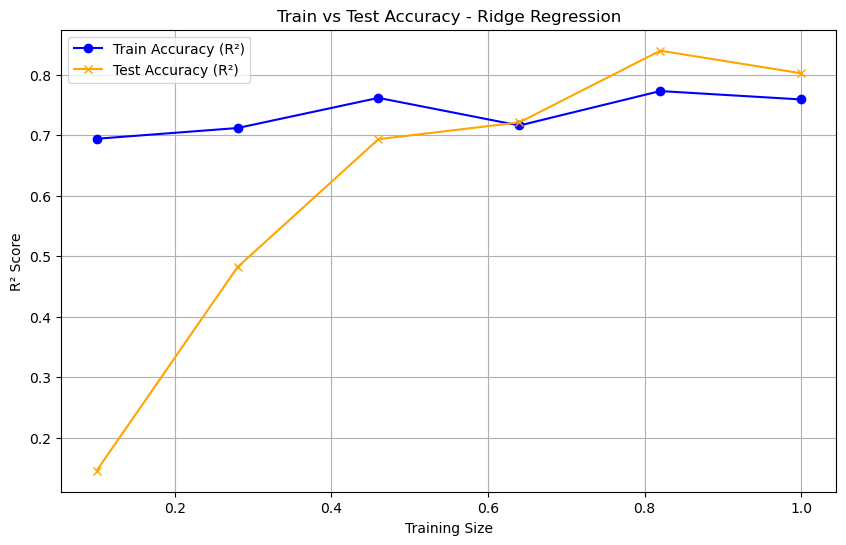

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes1 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best1 = []
test_accuracies_best1 = []

for size1 in training_sizes1:
    # Tentukan jumlah data training sesuai ukuran
    train_size1 = int(size1 * len(X_train1))
    X_train_subset1 = X_train1[:train_size1]
    y_train_subset1 = y_train1[:train_size1]
    
    # Fit model dengan subset data
    best_model1.fit(X_train_subset1, y_train_subset1)
    
    # Prediksi untuk data training dan testing
    y_train_pred1 = best_model1.predict(X_train_subset1)
    y_test_pred1 = best_model1.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best1.append(r2_score(y_train_subset1, y_train_pred1))
    test_accuracies_best1.append(r2_score(y_test1, y_test_pred1))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes1, train_accuracies_best1, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes1, test_accuracies_best1, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name1}')
plt.grid(True)
plt.legend()
plt.show()


Random Forest

In [35]:
# Ambil model terbaik dari split data 70:30
best_model_name1 = results_df1.iloc[1]['Model']
best_model1 = models1[best_model_name1]

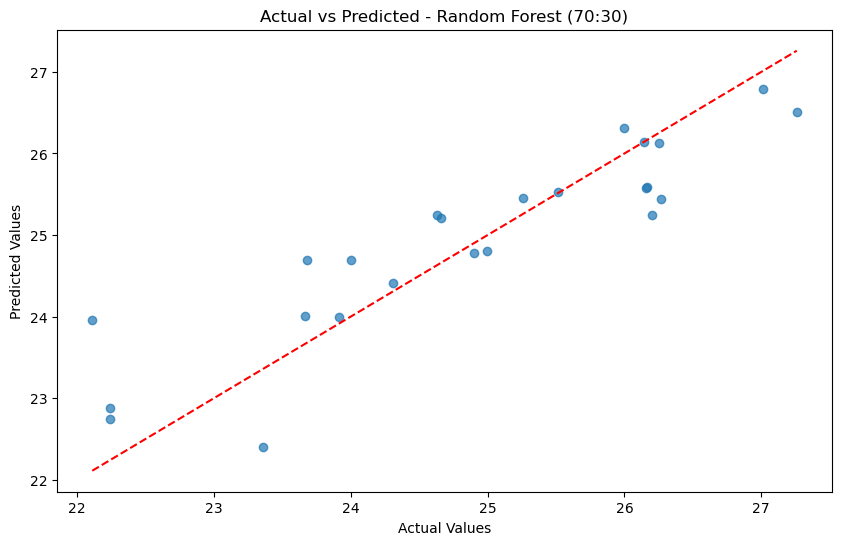

In [36]:
import matplotlib.pyplot as plt

y_actual1 = y_test1
y_pred_best1 = best_model1.predict(X_test1)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name1} (70:30)")
plt.show()

In [37]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.405807
0   23.997354  24.689754
27  26.199729  25.248233
39  22.237415  22.748193
21  26.146404  26.136317


In [38]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 5.379.207.643
0    Rp 26.419.136.187   Rp 52.798.777.454
27  Rp 239.000.000.001   Rp 92.292.872.618
39    Rp 4.545.551.009    Rp 7.575.559.812
21  Rp 226.589.000.001  Rp 224.315.059.431
35    Rp 4.545.551.009    Rp 8.622.617.397
10  Rp 120.781.089.488  Rp 121.931.989.022
92  Rp 228.530.000.001  Rp 128.374.302.801
4   Rp 540.031.588.145  Rp 433.000.705.220
13  Rp 195.596.000.001  Rp 267.754.009.787
64   Rp 65.000.000.001   Rp 57.399.426.773
41   Rp 24.322.000.001   Rp 26.434.867.138
88   Rp 35.905.245.001   Rp 40.092.776.568
43   Rp 18.970.782.261   Rp 26.809.139.458
89   Rp 93.541.144.803  Rp 112.964.980.997
59    Rp 3.997.225.850   Rp 25.257.075.562
95  Rp 690.000.000.001  Rp 326.969.375.983
78   Rp 49.559.404.693   Rp 91.570.849.305
72  Rp 230.570.298.290  Rp 130.280.007.717
52  Rp 254.967.000.193  Rp 112.380.082.486
9   Rp 251.146.002.001  Rp 221.431.733.614
83   Rp 71.420.000.001   Rp 58.871.614.738
5    Rp 51.

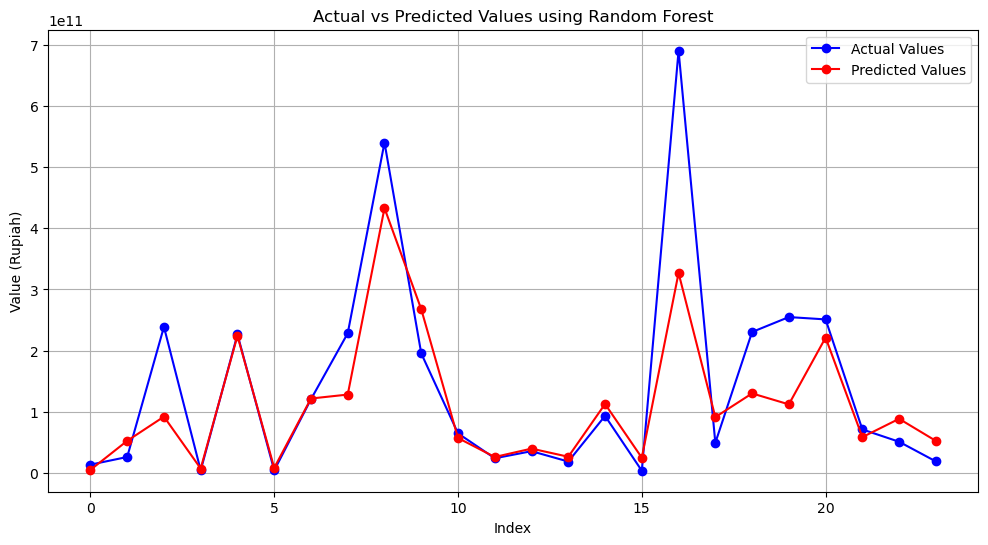

In [39]:
# Identify the best model based on Testing R² Score
best_model_name1 = results_df1.iloc[1]['Model']
best_model1 = models1[best_model_name1]

# Predict on the test data
y_pred_log1 = best_model1.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df1 = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df1.index, comparison_df1['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df1.index, comparison_df1['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name1}')
plt.legend()
plt.grid(True)
plt.show()


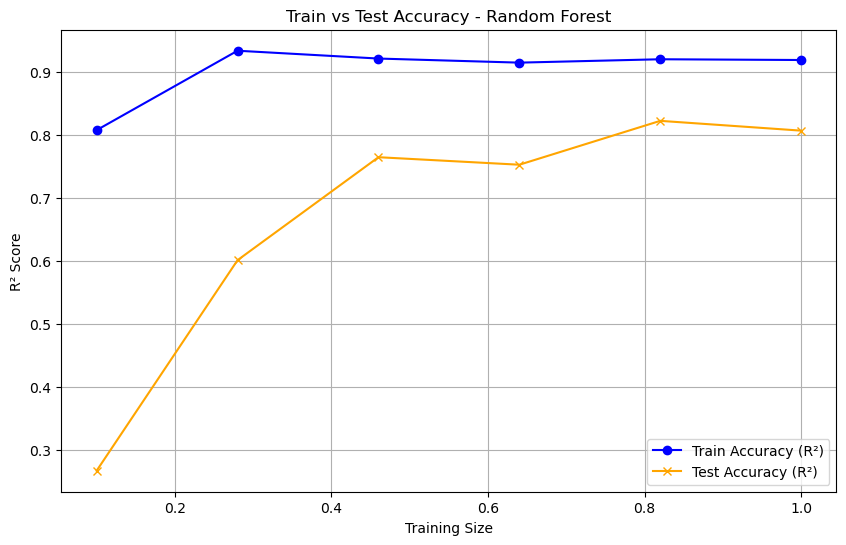

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes1 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best1 = []
test_accuracies_best1 = []

for size1 in training_sizes1:
    # Tentukan jumlah data training sesuai ukuran
    train_size1 = int(size1 * len(X_train1))
    X_train_subset1 = X_train1[:train_size1]
    y_train_subset1 = y_train1[:train_size1]
    
    # Fit model dengan subset data
    best_model1.fit(X_train_subset1, y_train_subset1)
    
    # Prediksi untuk data training dan testing
    y_train_pred1 = best_model1.predict(X_train_subset1)
    y_test_pred1 = best_model1.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best1.append(r2_score(y_train_subset1, y_train_pred1))
    test_accuracies_best1.append(r2_score(y_test1, y_test_pred1))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes1, train_accuracies_best1, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes1, test_accuracies_best1, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name1}')
plt.grid(True)
plt.legend()
plt.show()


Gradient Boosting

In [41]:
# Ambil model terbaik dari split data 70:30
best_model_name1 = results_df1.iloc[2]['Model']
best_model1 = models1[best_model_name1]

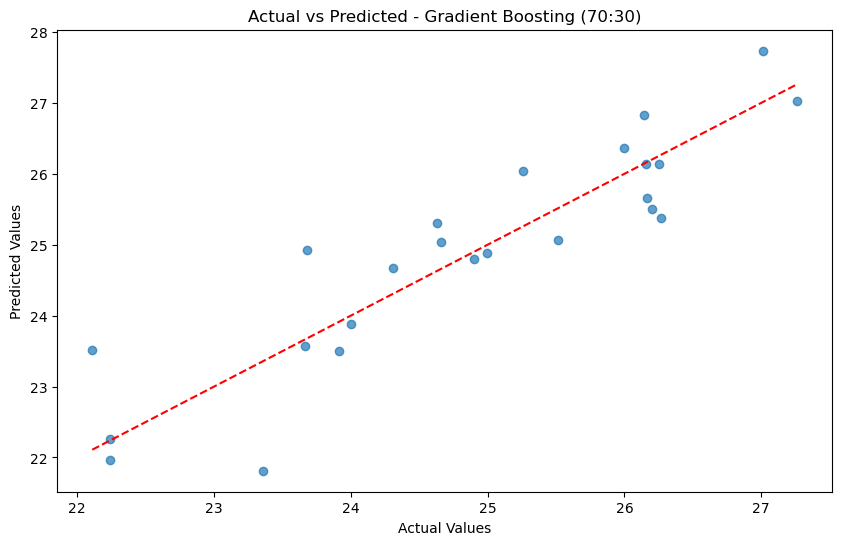

In [42]:
import matplotlib.pyplot as plt

y_actual1 = y_test1
y_pred_best1 = best_model1.predict(X_test1)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name1} (70:30)")
plt.show()

In [43]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  21.812743
0   23.997354  23.887553
27  26.199729  25.506412
39  22.237415  22.253810
21  26.146404  26.834869


In [44]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)    Predicted (Rupiah)
38   Rp 13.927.029.001      Rp 2.972.719.503
0    Rp 26.419.136.187     Rp 23.671.859.439
27  Rp 239.000.000.001    Rp 119.479.649.830
39    Rp 4.545.551.009      Rp 4.620.690.117
21  Rp 226.589.000.001    Rp 451.061.326.836
35    Rp 4.545.551.009      Rp 3.477.744.591
10  Rp 120.781.089.488     Rp 76.860.562.818
92  Rp 228.530.000.001    Rp 223.136.343.740
4   Rp 540.031.588.145  Rp 1.109.958.348.695
13  Rp 195.596.000.001    Rp 283.381.709.944
64   Rp 65.000.000.001     Rp 58.508.361.777
41   Rp 24.322.000.001     Rp 15.981.453.362
88   Rp 35.905.245.001     Rp 52.039.308.360
43   Rp 18.970.782.261     Rp 17.359.014.273
89   Rp 93.541.144.803    Rp 202.211.224.000
59    Rp 3.997.225.850     Rp 16.255.357.782
95  Rp 690.000.000.001    Rp 549.249.957.051
78   Rp 49.559.404.693     Rp 97.852.594.034
72  Rp 230.570.298.290    Rp 139.154.268.795
52  Rp 254.967.000.193    Rp 105.235.120.697
9   Rp 251.146.002.001    Rp 225.315.782.351
83   Rp 71

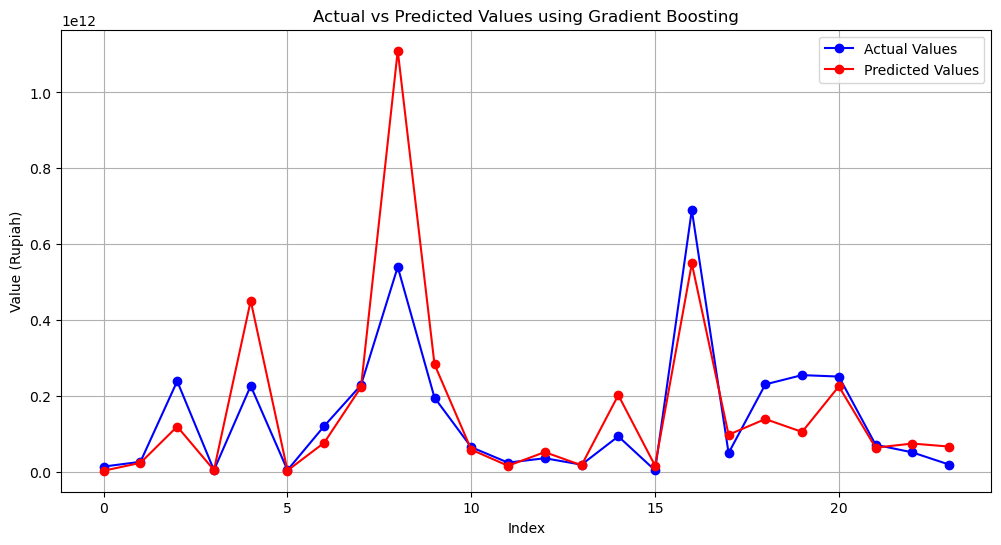

In [45]:
# Identify the best model based on Testing R² Score
best_model_name1 = results_df1.iloc[2]['Model']
best_model1 = models1[best_model_name1]

# Predict on the test data
y_pred_log1 = best_model1.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df1 = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df1.index, comparison_df1['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df1.index, comparison_df1['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name1}')
plt.legend()
plt.grid(True)
plt.show()


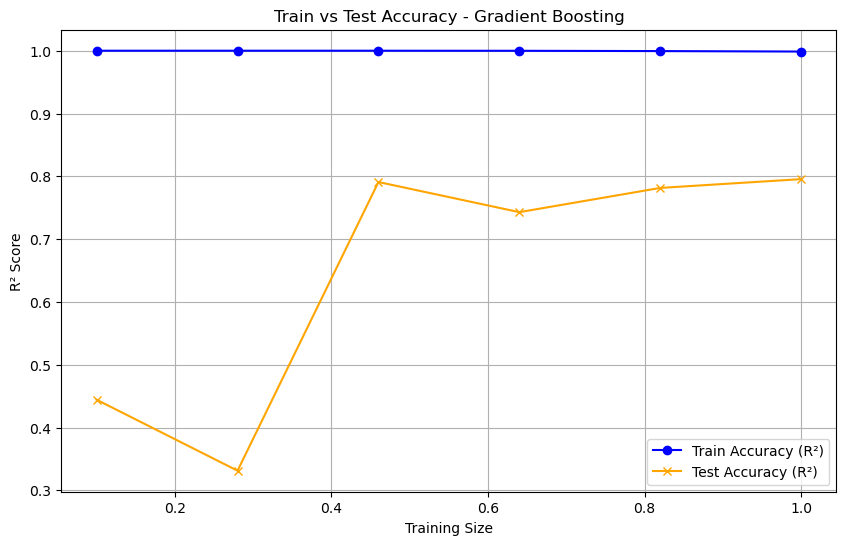

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes1 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best1 = []
test_accuracies_best1 = []

for size1 in training_sizes1:
    # Tentukan jumlah data training sesuai ukuran
    train_size1 = int(size1 * len(X_train1))
    X_train_subset1 = X_train1[:train_size1]
    y_train_subset1 = y_train1[:train_size1]
    
    # Fit model dengan subset data
    best_model1.fit(X_train_subset1, y_train_subset1)
    
    # Prediksi untuk data training dan testing
    y_train_pred1 = best_model1.predict(X_train_subset1)
    y_test_pred1 = best_model1.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best1.append(r2_score(y_train_subset1, y_train_pred1))
    test_accuracies_best1.append(r2_score(y_test1, y_test_pred1))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes1, train_accuracies_best1, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes1, test_accuracies_best1, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name1}')
plt.grid(True)
plt.legend()
plt.show()


AdaBoost

In [47]:
# Ambil model terbaik dari split data 70:30
best_model_name1 = results_df1.iloc[3]['Model']
best_model1 = models1[best_model_name1]

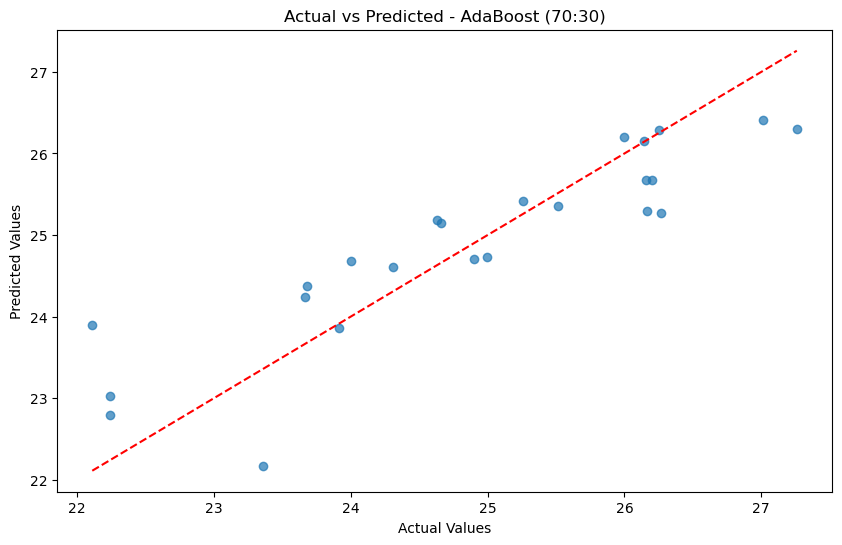

In [48]:
import matplotlib.pyplot as plt

y_actual1 = y_test1
y_pred_best1 = best_model1.predict(X_test1)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name1} (70:30)")
plt.show()

In [49]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.169971
0   23.997354  24.680483
27  26.199729  25.676249
39  22.237415  22.794141
21  26.146404  26.157821


In [50]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 4.249.089.516
0    Rp 26.419.136.187   Rp 52.311.558.890
27  Rp 239.000.000.001  Rp 141.596.700.391
39    Rp 4.545.551.009    Rp 7.931.762.505
21  Rp 226.589.000.001  Rp 229.190.919.014
35    Rp 4.545.551.009    Rp 9.989.070.202
10  Rp 120.781.089.488  Rp 102.486.503.648
92  Rp 228.530.000.001  Rp 141.596.700.391
4   Rp 540.031.588.145  Rp 293.330.585.697
13  Rp 195.596.000.001  Rp 239.024.137.931
64   Rp 65.000.000.001   Rp 53.756.686.205
41   Rp 24.322.000.001   Rp 22.954.685.214
88   Rp 35.905.245.001   Rp 48.573.354.648
43   Rp 18.970.782.261   Rp 33.607.833.412
89   Rp 93.541.144.803  Rp 109.367.769.797
59    Rp 3.997.225.850   Rp 23.994.922.282
95  Rp 690.000.000.001  Rp 262.728.811.257
78   Rp 49.559.404.693   Rp 86.239.153.014
72  Rp 230.570.298.290   Rp 96.175.935.086
52  Rp 254.967.000.193   Rp 94.413.996.121
9   Rp 251.146.002.001  Rp 259.845.363.860
83   Rp 71.420.000.001   Rp 55.194.296.307
5    Rp 51.

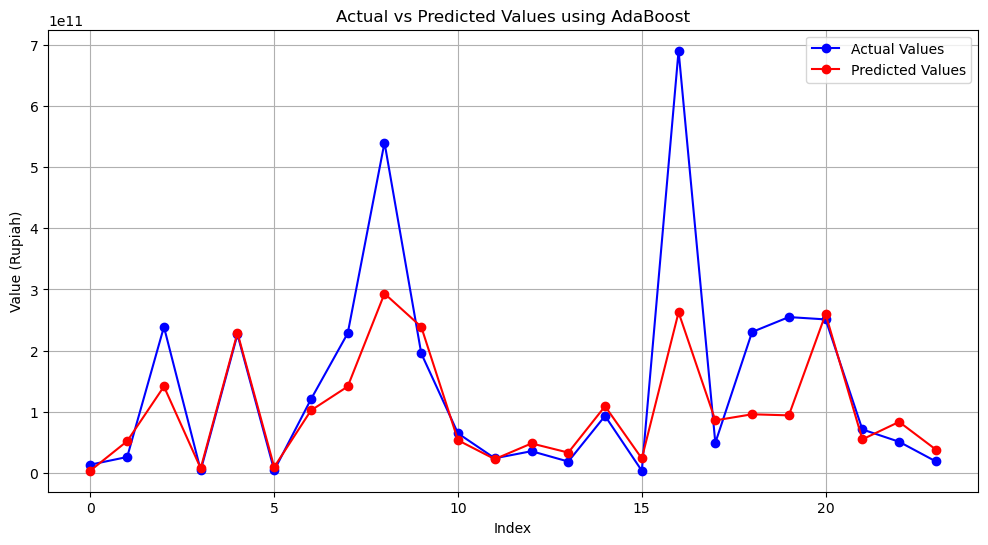

In [52]:
# Identify the best model based on Testing R² Score
best_model_name1 = results_df1.iloc[3]['Model']
best_model1 = models1[best_model_name1]

# Predict on the test data
y_pred_log1 = best_model1.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df1 = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df1.index, comparison_df1['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df1.index, comparison_df1['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name1}')
plt.legend()
plt.grid(True)
plt.show()


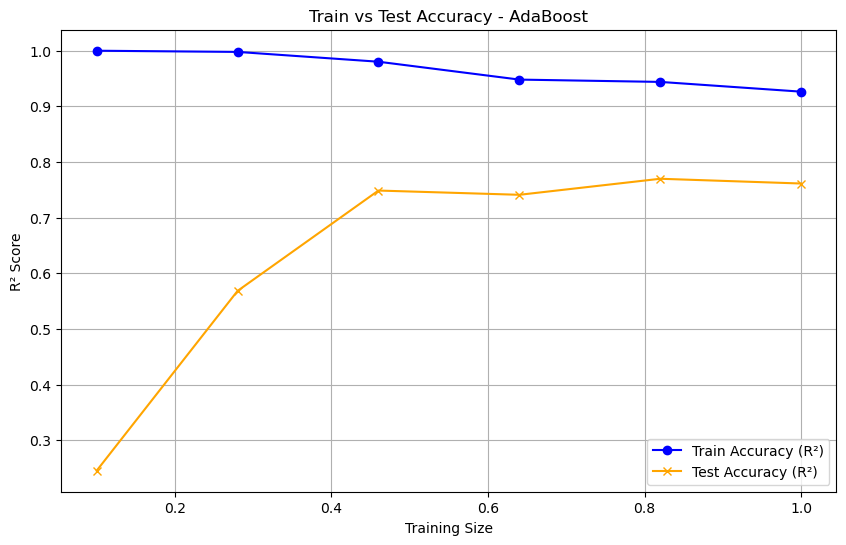

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes1 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best1 = []
test_accuracies_best1 = []

for size1 in training_sizes1:
    # Tentukan jumlah data training sesuai ukuran
    train_size1 = int(size1 * len(X_train1))
    X_train_subset1 = X_train1[:train_size1]
    y_train_subset1 = y_train1[:train_size1]
    
    # Fit model dengan subset data
    best_model1.fit(X_train_subset1, y_train_subset1)
    
    # Prediksi untuk data training dan testing
    y_train_pred1 = best_model1.predict(X_train_subset1)
    y_test_pred1 = best_model1.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best1.append(r2_score(y_train_subset1, y_train_pred1))
    test_accuracies_best1.append(r2_score(y_test1, y_test_pred1))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes1, train_accuracies_best1, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes1, test_accuracies_best1, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name1}')
plt.grid(True)
plt.legend()
plt.show()


Bayesian Ridge Regression

In [54]:
# Ambil model terbaik dari split data 70:30
best_model_name1 = results_df1.iloc[4]['Model']
best_model1 = models1[best_model_name1]

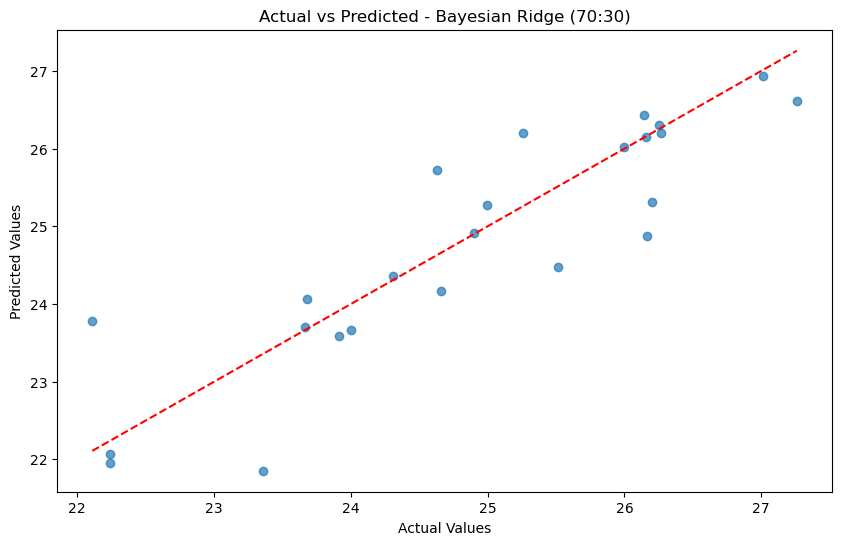

In [55]:
import matplotlib.pyplot as plt

y_actual1 = y_test1
y_pred_best1 = best_model1.predict(X_test1)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name1} (70:30)")
plt.show()

In [56]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  21.853505
0   23.997354  23.663490
27  26.199729  25.310020
39  22.237415  21.948287
21  26.146404  26.438491


In [57]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.096.395.666
0    Rp 26.419.136.187   Rp 18.920.085.636
27  Rp 239.000.000.001   Rp 98.175.288.314
39    Rp 4.545.551.009    Rp 3.404.239.569
21  Rp 226.589.000.001  Rp 303.452.471.879
35    Rp 4.545.551.009    Rp 3.831.110.383
10  Rp 120.781.089.488   Rp 42.773.629.153
92  Rp 228.530.000.001  Rp 227.926.131.281
4   Rp 540.031.588.145  Rp 497.156.305.423
13  Rp 195.596.000.001  Rp 199.653.943.054
64   Rp 65.000.000.001   Rp 66.219.073.207
41   Rp 24.322.000.001   Rp 17.471.352.352
88   Rp 35.905.245.001   Rp 38.074.894.500
43   Rp 18.970.782.261   Rp 19.796.985.898
89   Rp 93.541.144.803  Rp 239.223.629.330
59    Rp 3.997.225.850   Rp 21.177.988.862
95  Rp 690.000.000.001  Rp 360.666.495.491
78   Rp 49.559.404.693  Rp 149.321.623.656
72  Rp 230.570.298.290   Rp 63.294.184.577
52  Rp 254.967.000.193  Rp 238.351.433.574
9   Rp 251.146.002.001  Rp 264.256.652.289
83   Rp 71.420.000.001   Rp 94.226.557.609
5    Rp 51.

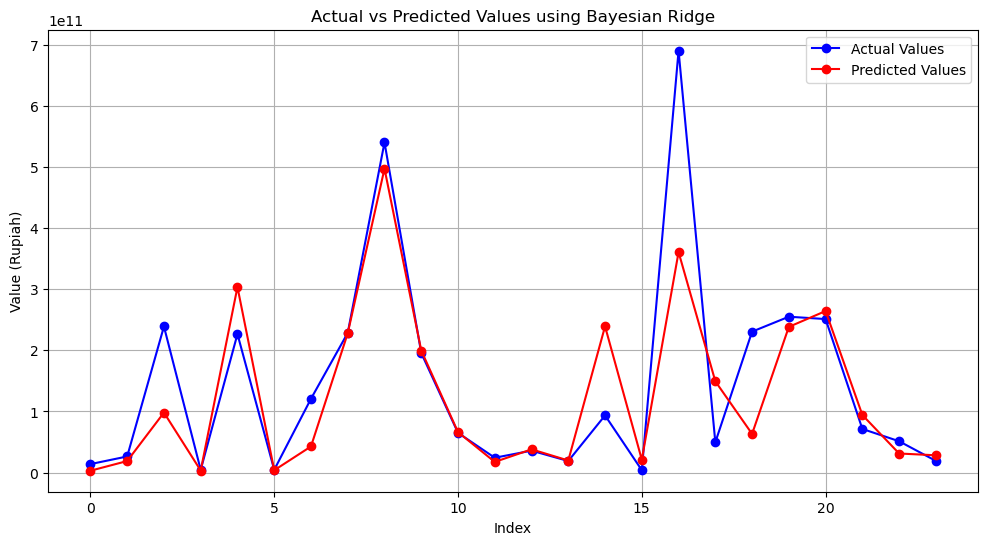

In [60]:
# Identify the best model based on Testing R² Score
best_model_name1 = results_df1.iloc[4]['Model']
best_model1 = models1[best_model_name1]

# Predict on the test data
y_pred_log1 = best_model1.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df1 = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df1.index, comparison_df1['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df1.index, comparison_df1['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name1}')
plt.legend()
plt.grid(True)
plt.show()


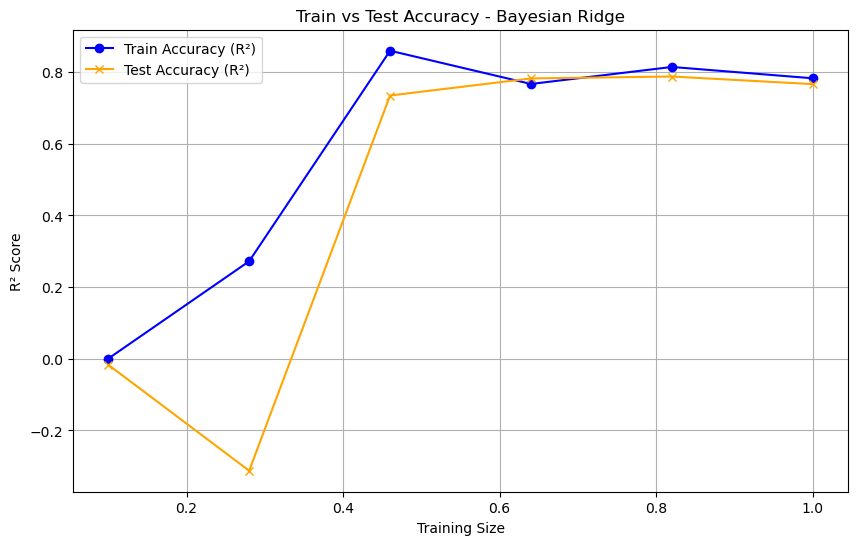

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes1 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best1 = []
test_accuracies_best1 = []

for size1 in training_sizes1:
    # Tentukan jumlah data training sesuai ukuran
    train_size1 = int(size1 * len(X_train1))
    X_train_subset1 = X_train1[:train_size1]
    y_train_subset1 = y_train1[:train_size1]
    
    # Fit model dengan subset data
    best_model1.fit(X_train_subset1, y_train_subset1)
    
    # Prediksi untuk data training dan testing
    y_train_pred1 = best_model1.predict(X_train_subset1)
    y_test_pred1 = best_model1.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best1.append(r2_score(y_train_subset1, y_train_pred1))
    test_accuracies_best1.append(r2_score(y_test1, y_test_pred1))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes1, train_accuracies_best1, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes1, test_accuracies_best1, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name1}')
plt.grid(True)
plt.legend()
plt.show()


XGBoost

In [62]:
# Ambil model terbaik dari split data 70:30
best_model_name1 = results_df1.iloc[5]['Model']
best_model1 = models1[best_model_name1]

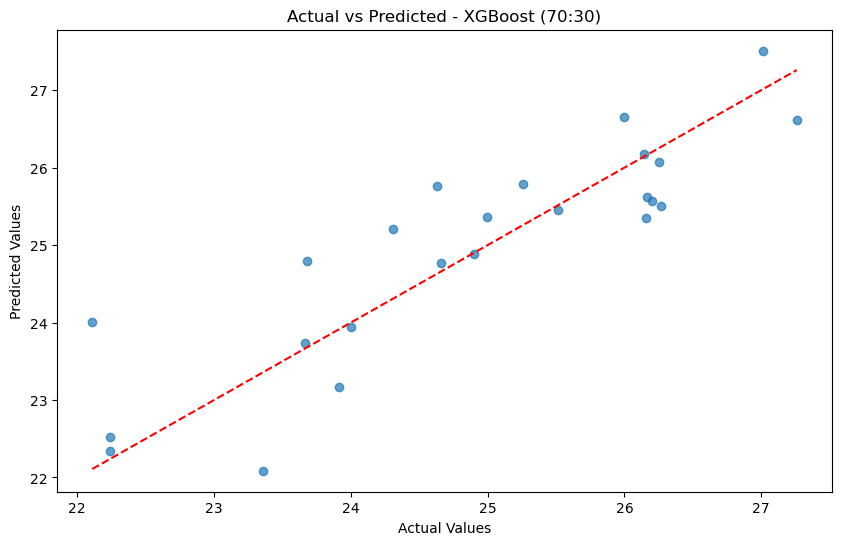

In [63]:
import matplotlib.pyplot as plt

y_actual1 = y_test1
y_pred_best1 = best_model1.predict(X_test1)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name1} (70:30)")
plt.show()

In [64]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  22.086739
0   23.997354  23.944151
27  26.199729  25.574572
39  22.237415  22.528023
21  26.146404  26.179363


In [65]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.909.747.200
0    Rp 26.419.136.187   Rp 25.050.281.984
27  Rp 239.000.000.001  Rp 127.907.291.136
39    Rp 4.545.551.009    Rp 6.078.493.696
21  Rp 226.589.000.001  Rp 234.181.722.112
35    Rp 4.545.551.009    Rp 5.028.369.920
10  Rp 120.781.089.488  Rp 113.686.093.824
92  Rp 228.530.000.001  Rp 101.982.035.968
4   Rp 540.031.588.145  Rp 885.174.239.232
13  Rp 195.596.000.001  Rp 377.167.872.000
64   Rp 65.000.000.001   Rp 63.813.492.736
41   Rp 24.322.000.001   Rp 11.503.205.376
88   Rp 35.905.245.001   Rp 89.057.943.552
43   Rp 18.970.782.261   Rp 20.377.432.064
89   Rp 93.541.144.803  Rp 157.386.604.544
59    Rp 3.997.225.850   Rp 26.572.265.472
95  Rp 690.000.000.001  Rp 362.926.407.680
78   Rp 49.559.404.693  Rp 154.543.652.864
72  Rp 230.570.298.290  Rp 133.749.194.752
52  Rp 254.967.000.193  Rp 119.304.142.848
9   Rp 251.146.002.001  Rp 211.738.722.304
83   Rp 71.420.000.001  Rp 103.357.898.752
5    Rp 51.

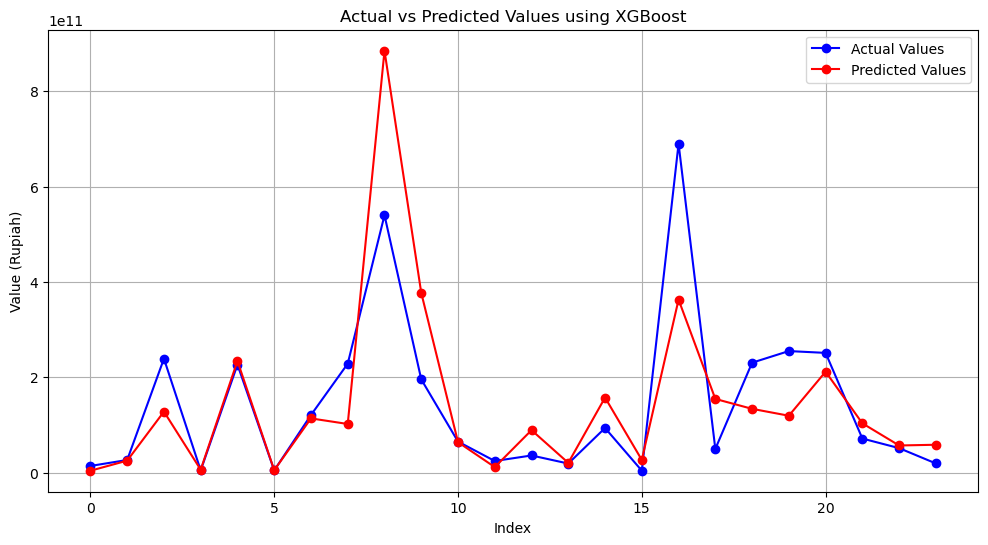

In [66]:
# Identify the best model based on Testing R² Score
best_model_name1 = results_df1.iloc[5]['Model']
best_model1 = models1[best_model_name1]

# Predict on the test data
y_pred_log1 = best_model1.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df1 = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df1.index, comparison_df1['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df1.index, comparison_df1['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name1}')
plt.legend()
plt.grid(True)
plt.show()


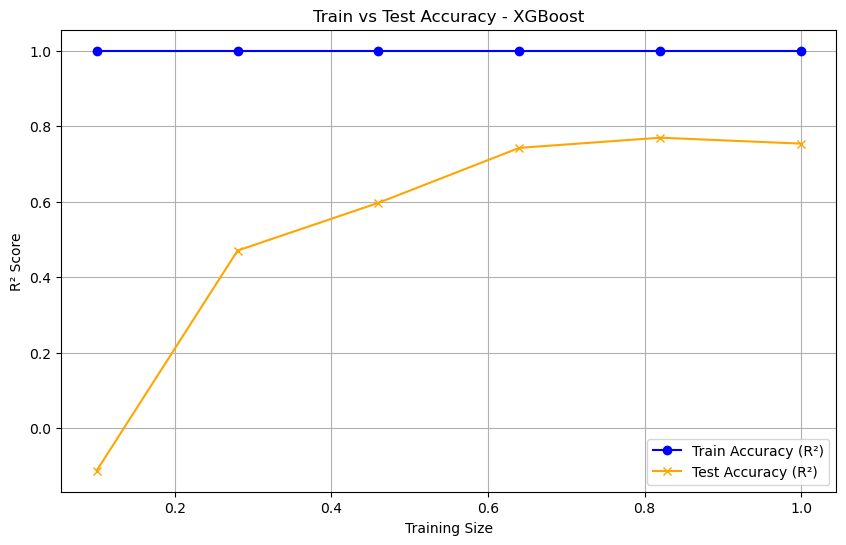

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes1 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best1 = []
test_accuracies_best1 = []

for size1 in training_sizes1:
    # Tentukan jumlah data training sesuai ukuran
    train_size1 = int(size1 * len(X_train1))
    X_train_subset1 = X_train1[:train_size1]
    y_train_subset1 = y_train1[:train_size1]
    
    # Fit model dengan subset data
    best_model1.fit(X_train_subset1, y_train_subset1)
    
    # Prediksi untuk data training dan testing
    y_train_pred1 = best_model1.predict(X_train_subset1)
    y_test_pred1 = best_model1.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best1.append(r2_score(y_train_subset1, y_train_pred1))
    test_accuracies_best1.append(r2_score(y_test1, y_test_pred1))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes1, train_accuracies_best1, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes1, test_accuracies_best1, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name1}')
plt.grid(True)
plt.legend()
plt.show()


Linear Regression

In [68]:
# Ambil model terbaik dari split data 70:30
best_model_name1 = results_df1.iloc[6]['Model']
best_model1 = models1[best_model_name1]

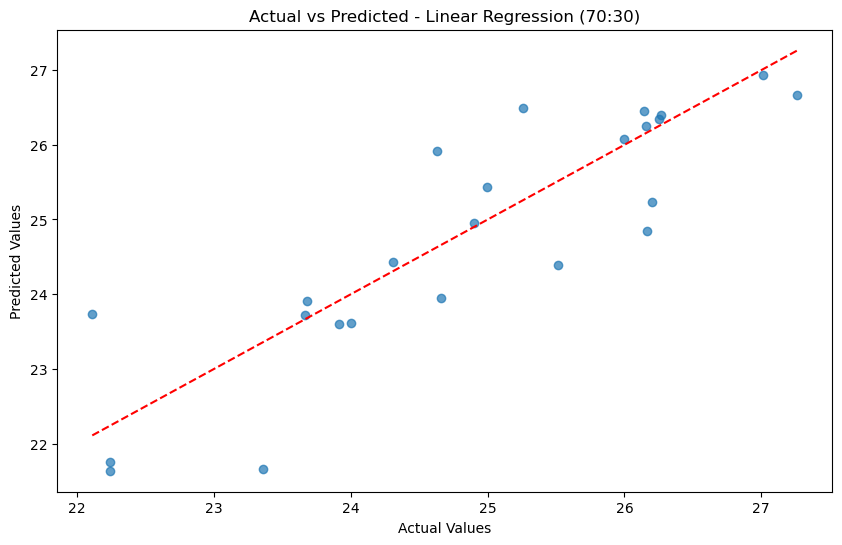

In [69]:
import matplotlib.pyplot as plt

y_actual1 = y_test1
y_pred_best1 = best_model1.predict(X_test1)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name1} (70:30)")
plt.show()

In [70]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  21.653038
0   23.997354  23.618530
27  26.199729  25.231869
39  22.237415  21.636098
21  26.146404  26.453453


In [71]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 2.533.931.789
0    Rp 26.419.136.187   Rp 18.088.285.238
27  Rp 239.000.000.001   Rp 90.794.947.789
39    Rp 4.545.551.009    Rp 2.491.368.560
21  Rp 226.589.000.001  Rp 308.027.024.763
35    Rp 4.545.551.009    Rp 2.792.729.977
10  Rp 120.781.089.488   Rp 39.166.651.746
92  Rp 228.530.000.001  Rp 252.287.130.531
4   Rp 540.031.588.145  Rp 500.552.635.165
13  Rp 195.596.000.001  Rp 211.123.843.242
64   Rp 65.000.000.001   Rp 68.651.311.002
41   Rp 24.322.000.001   Rp 17.789.053.293
88   Rp 35.905.245.001   Rp 40.988.311.210
43   Rp 18.970.782.261   Rp 19.913.713.545
89   Rp 93.541.144.803  Rp 320.960.549.016
59    Rp 3.997.225.850   Rp 20.246.776.186
95  Rp 690.000.000.001  Rp 383.681.093.533
78   Rp 49.559.404.693  Rp 180.013.051.952
72  Rp 230.570.298.290   Rp 61.938.903.973
52  Rp 254.967.000.193  Rp 292.776.319.324
9   Rp 251.146.002.001  Rp 277.993.635.043
83   Rp 71.420.000.001  Rp 110.666.867.952
5    Rp 51.

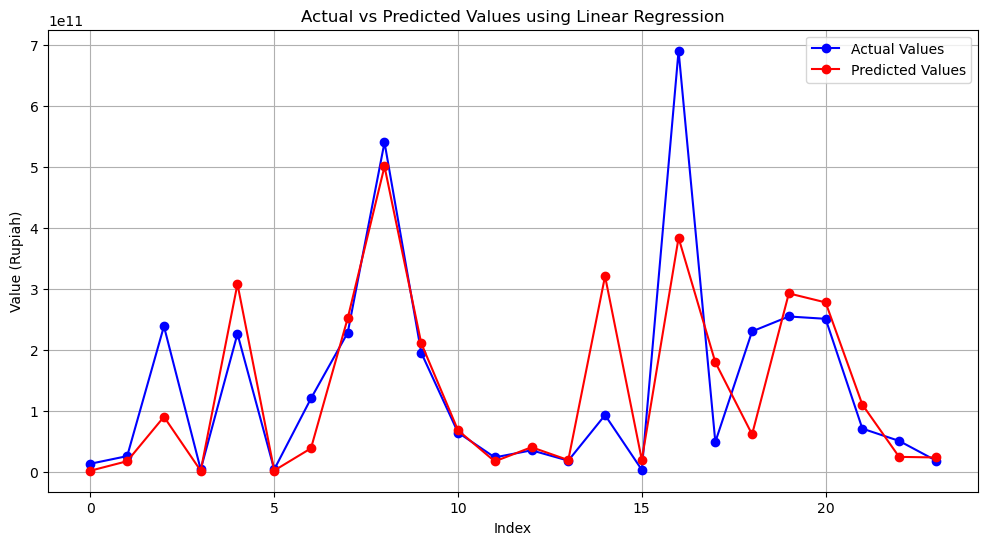

In [72]:
# Identify the best model based on Testing R² Score
best_model_name1 = results_df1.iloc[6]['Model']
best_model1 = models1[best_model_name1]

# Predict on the test data
y_pred_log1 = best_model1.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df1 = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df1.index, comparison_df1['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df1.index, comparison_df1['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name1}')
plt.legend()
plt.grid(True)
plt.show()


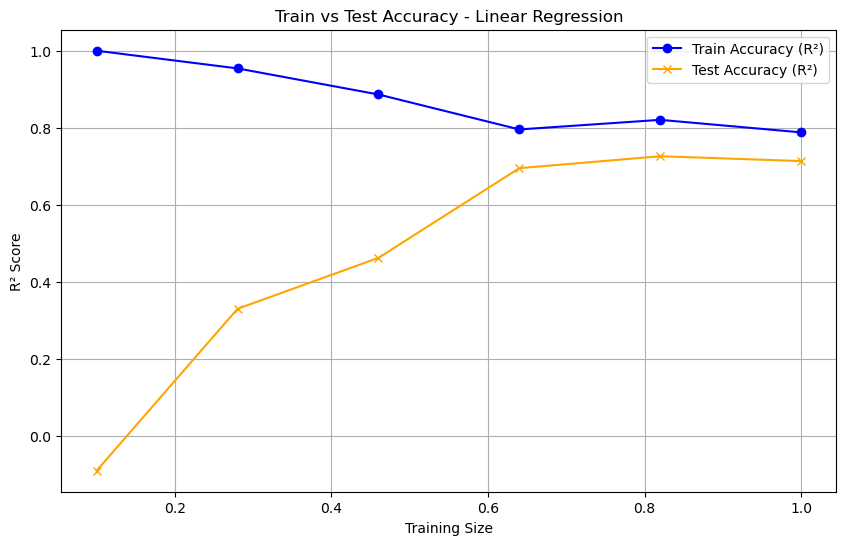

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes1 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best1 = []
test_accuracies_best1 = []

for size1 in training_sizes1:
    # Tentukan jumlah data training sesuai ukuran
    train_size1 = int(size1 * len(X_train1))
    X_train_subset1 = X_train1[:train_size1]
    y_train_subset1 = y_train1[:train_size1]
    
    # Fit model dengan subset data
    best_model1.fit(X_train_subset1, y_train_subset1)
    
    # Prediksi untuk data training dan testing
    y_train_pred1 = best_model1.predict(X_train_subset1)
    y_test_pred1 = best_model1.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best1.append(r2_score(y_train_subset1, y_train_pred1))
    test_accuracies_best1.append(r2_score(y_test1, y_test_pred1))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes1, train_accuracies_best1, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes1, test_accuracies_best1, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name1}')
plt.grid(True)
plt.legend()
plt.show()


Decision Tree Regression

In [74]:
# Ambil model terbaik dari split data 70:30
best_model_name1 = results_df1.iloc[7]['Model']
best_model1 = models1[best_model_name1]

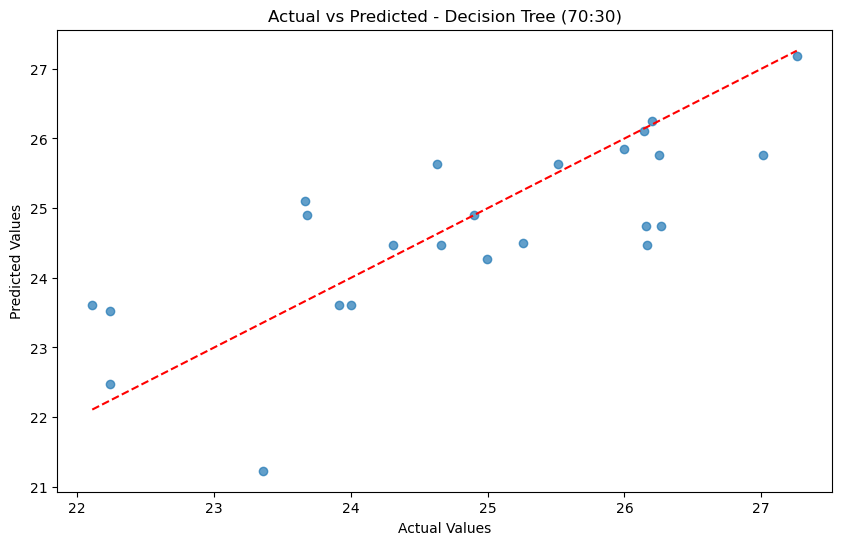

In [75]:
import matplotlib.pyplot as plt

y_actual1 = y_test1
y_pred_best1 = best_model1.predict(X_test1)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name1} (70:30)")
plt.show()

In [76]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  21.231163
0   23.997354  23.608067
27  26.199729  26.244727
39  22.237415  23.528452
21  26.146404  26.107761


In [77]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 1.661.792.614
0    Rp 26.419.136.187   Rp 17.900.000.001
27  Rp 239.000.000.001  Rp 250.000.000.001
39    Rp 4.545.551.009   Rp 16.530.153.001
21  Rp 226.589.000.001  Rp 218.000.000.001
35    Rp 4.545.551.009    Rp 5.782.814.828
10  Rp 120.781.089.488  Rp 136.000.000.001
92  Rp 228.530.000.001   Rp 55.550.000.001
4   Rp 540.031.588.145  Rp 155.100.000.001
13  Rp 195.596.000.001  Rp 167.237.534.335
64   Rp 65.000.000.001   Rp 65.000.000.001
41   Rp 24.322.000.001   Rp 17.835.142.727
88   Rp 35.905.245.001   Rp 42.500.000.001
43   Rp 18.970.782.261   Rp 79.747.958.001
89   Rp 93.541.144.803   Rp 43.744.136.851
59    Rp 3.997.225.850   Rp 17.900.000.001
95  Rp 690.000.000.001  Rp 639.161.044.501
78   Rp 49.559.404.693  Rp 136.000.000.001
72  Rp 230.570.298.290   Rp 42.500.000.001
52  Rp 254.967.000.193   Rp 55.550.000.001
9   Rp 251.146.002.001  Rp 155.100.000.001
83   Rp 71.420.000.001   Rp 34.700.582.001
5    Rp 51.

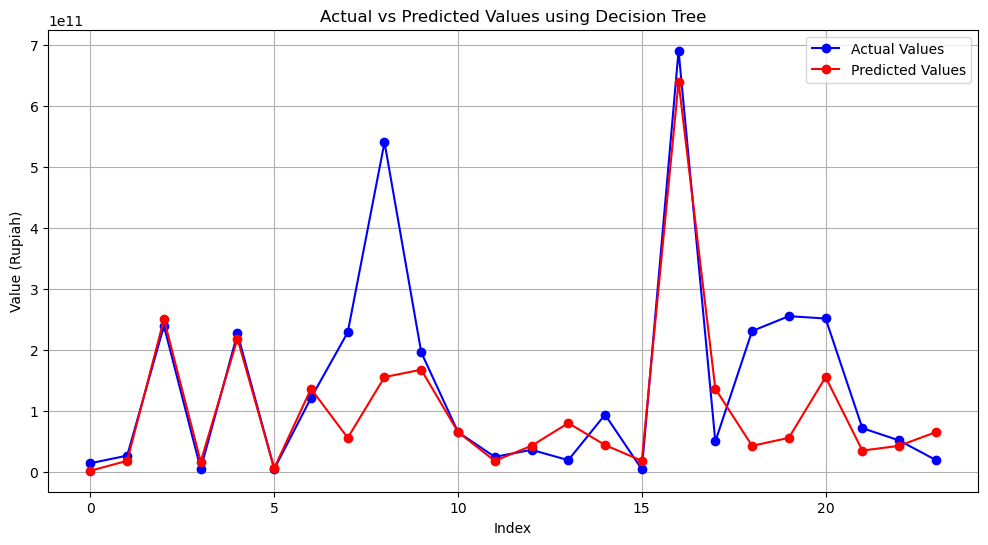

In [78]:
# Identify the best model based on Testing R² Score
best_model_name1 = results_df1.iloc[7]['Model']
best_model1 = models1[best_model_name1]

# Predict on the test data
y_pred_log1 = best_model1.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df1 = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df1.index, comparison_df1['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df1.index, comparison_df1['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name1}')
plt.legend()
plt.grid(True)
plt.show()


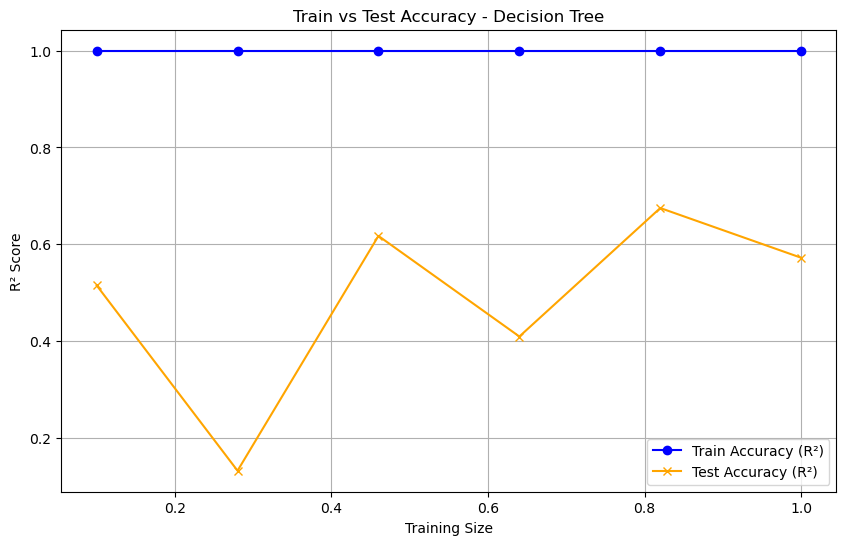

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes1 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best1 = []
test_accuracies_best1 = []

for size1 in training_sizes1:
    # Tentukan jumlah data training sesuai ukuran
    train_size1 = int(size1 * len(X_train1))
    X_train_subset1 = X_train1[:train_size1]
    y_train_subset1 = y_train1[:train_size1]
    
    # Fit model dengan subset data
    best_model1.fit(X_train_subset1, y_train_subset1)
    
    # Prediksi untuk data training dan testing
    y_train_pred1 = best_model1.predict(X_train_subset1)
    y_test_pred1 = best_model1.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best1.append(r2_score(y_train_subset1, y_train_pred1))
    test_accuracies_best1.append(r2_score(y_test1, y_test_pred1))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes1, train_accuracies_best1, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes1, test_accuracies_best1, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name1}')
plt.grid(True)
plt.legend()
plt.show()


KNN Regressor

In [83]:
# Ambil model terbaik dari split data 70:30
best_model_name1 = results_df1.iloc[8]['Model']
best_model1 = models1[best_model_name1]

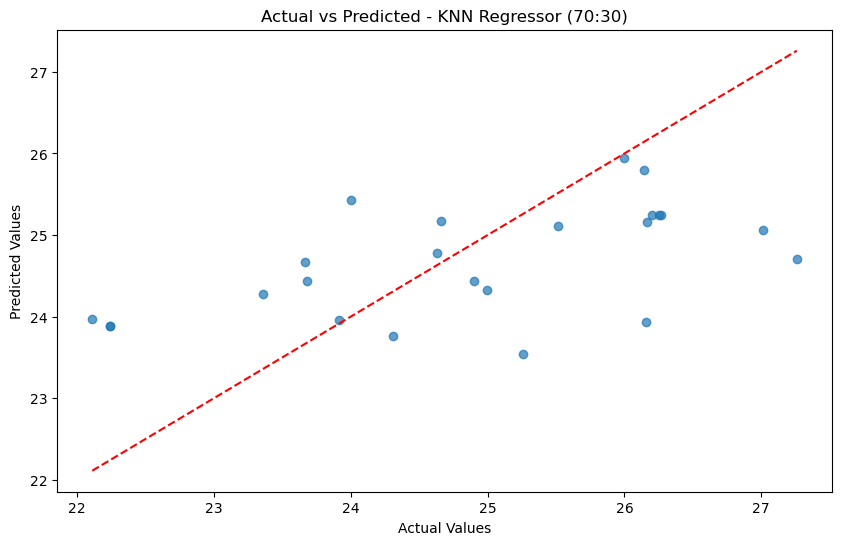

In [84]:
import matplotlib.pyplot as plt

y_actual1 = y_test1
y_pred_best1 = best_model1.predict(X_test1)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name1} (70:30)")
plt.show()

In [85]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  24.270163
0   23.997354  25.429270
27  26.199729  25.251281
39  22.237415  23.884519
21  26.146404  25.795203


In [86]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001   Rp 34.705.466.789
0    Rp 26.419.136.187  Rp 110.609.306.932
27  Rp 239.000.000.001   Rp 92.574.610.369
39    Rp 4.545.551.009   Rp 23.600.140.646
21  Rp 226.589.000.001  Rp 159.482.962.894
35    Rp 4.545.551.009   Rp 23.600.140.646
10  Rp 120.781.089.488   Rp 80.651.159.427
92  Rp 228.530.000.001   Rp 24.789.991.616
4   Rp 540.031.588.145   Rp 76.362.351.050
13  Rp 195.596.000.001  Rp 185.347.739.565
64   Rp 65.000.000.001   Rp 40.771.220.298
41   Rp 24.322.000.001   Rp 25.371.102.310
88   Rp 35.905.245.001   Rp 20.752.281.623
43   Rp 18.970.782.261   Rp 51.439.457.892
89   Rp 93.541.144.803   Rp 16.820.478.065
59    Rp 3.997.225.850   Rp 25.823.678.674
95  Rp 690.000.000.001   Rp 53.765.653.557
78   Rp 49.559.404.693   Rp 57.733.737.754
72  Rp 230.570.298.290   Rp 84.193.614.322
52  Rp 254.967.000.193   Rp 92.550.930.373
9   Rp 251.146.002.001   Rp 92.574.610.369
83   Rp 71.420.000.001   Rp 36.509.200.685
5    Rp 51.

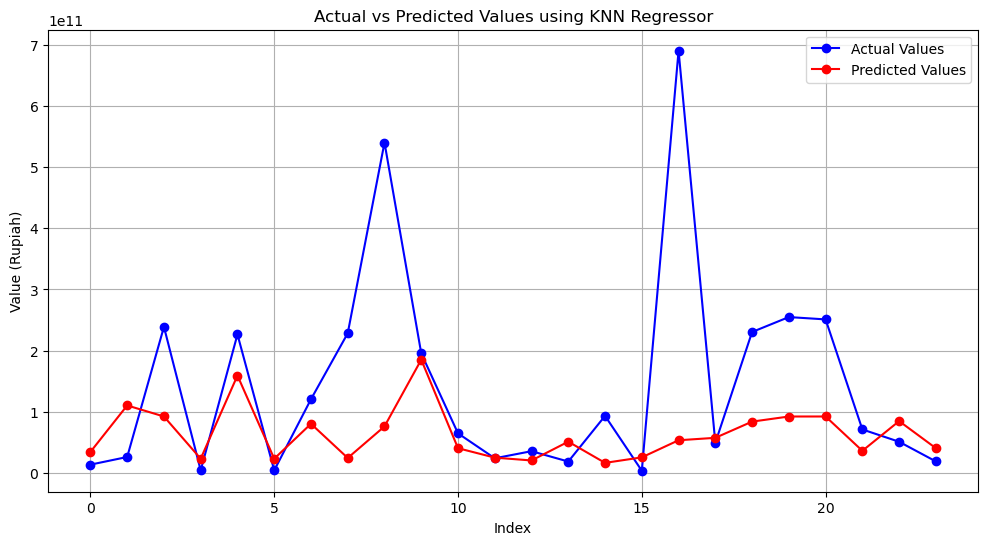

In [87]:
# Identify the best model based on Testing R² Score
best_model_name1 = results_df1.iloc[8]['Model']
best_model1 = models1[best_model_name1]

# Predict on the test data
y_pred_log1 = best_model1.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df1 = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df1.index, comparison_df1['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df1.index, comparison_df1['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name1}')
plt.legend()
plt.grid(True)
plt.show()


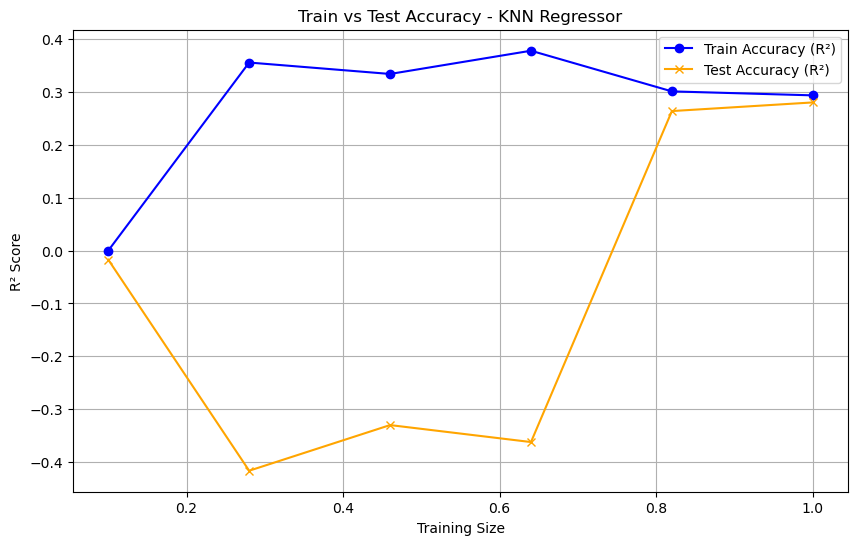

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes1 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best1 = []
test_accuracies_best1 = []

for size1 in training_sizes1:
    # Tentukan jumlah data training sesuai ukuran
    train_size1 = int(size1 * len(X_train1))
    X_train_subset1 = X_train1[:train_size1]
    y_train_subset1 = y_train1[:train_size1]
    
    # Fit model dengan subset data
    best_model1.fit(X_train_subset1, y_train_subset1)
    
    # Prediksi untuk data training dan testing
    y_train_pred1 = best_model1.predict(X_train_subset1)
    y_test_pred1 = best_model1.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best1.append(r2_score(y_train_subset1, y_train_pred1))
    test_accuracies_best1.append(r2_score(y_test1, y_test_pred1))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes1, train_accuracies_best1, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes1, test_accuracies_best1, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name1}')
plt.grid(True)
plt.legend()
plt.show()


SVR

In [89]:
# Ambil model terbaik dari split data 70:30
best_model_name1 = results_df1.iloc[9]['Model']
best_model1 = models1[best_model_name1]

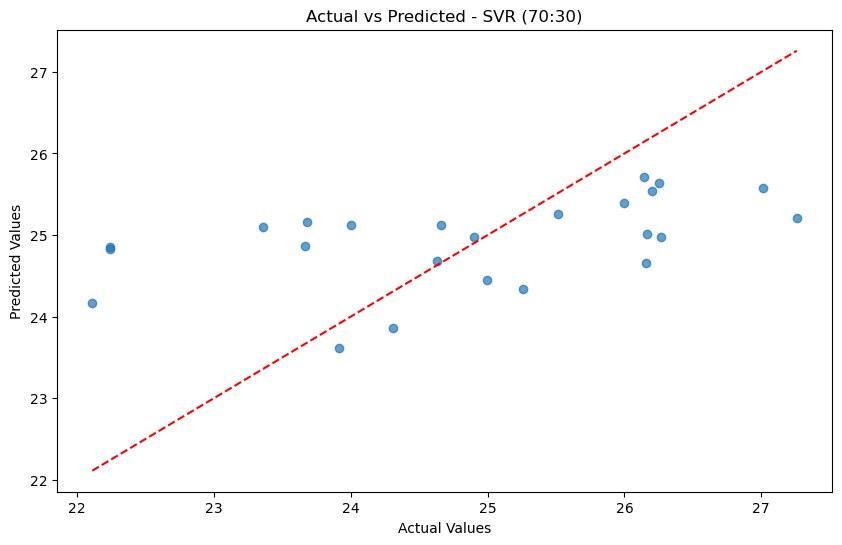

In [90]:
import matplotlib.pyplot as plt

y_actual1 = y_test1
y_pred_best1 = best_model1.predict(X_test1)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name1} (70:30)")
plt.show()

In [91]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  25.094504
0   23.997354  25.126659
27  26.199729  25.542431
39  22.237415  24.823872
21  26.146404  25.705133


In [92]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001   Rp 79.141.577.923
0    Rp 26.419.136.187   Rp 81.727.708.988
27  Rp 239.000.000.001  Rp 123.861.643.148
39    Rp 4.545.551.009   Rp 60.376.852.158
21  Rp 226.589.000.001  Rp 145.746.330.159
35    Rp 4.545.551.009   Rp 61.918.023.871
10  Rp 120.781.089.488   Rp 93.309.039.885
92  Rp 228.530.000.001   Rp 51.211.020.913
4   Rp 540.031.588.145  Rp 127.954.755.412
13  Rp 195.596.000.001  Rp 106.772.231.309
64   Rp 65.000.000.001   Rp 69.938.589.164
41   Rp 24.322.000.001   Rp 17.938.570.073
88   Rp 35.905.245.001   Rp 23.140.805.826
43   Rp 18.970.782.261   Rp 63.123.067.817
89   Rp 93.541.144.803   Rp 37.122.585.522
59    Rp 3.997.225.850   Rp 31.421.054.282
95  Rp 690.000.000.001   Rp 89.051.284.220
78   Rp 49.559.404.693   Rp 52.335.288.852
72  Rp 230.570.298.290   Rp 73.156.297.024
52  Rp 254.967.000.193   Rp 70.053.580.314
9   Rp 251.146.002.001  Rp 136.255.633.865
83   Rp 71.420.000.001   Rp 41.254.647.693
5    Rp 51.

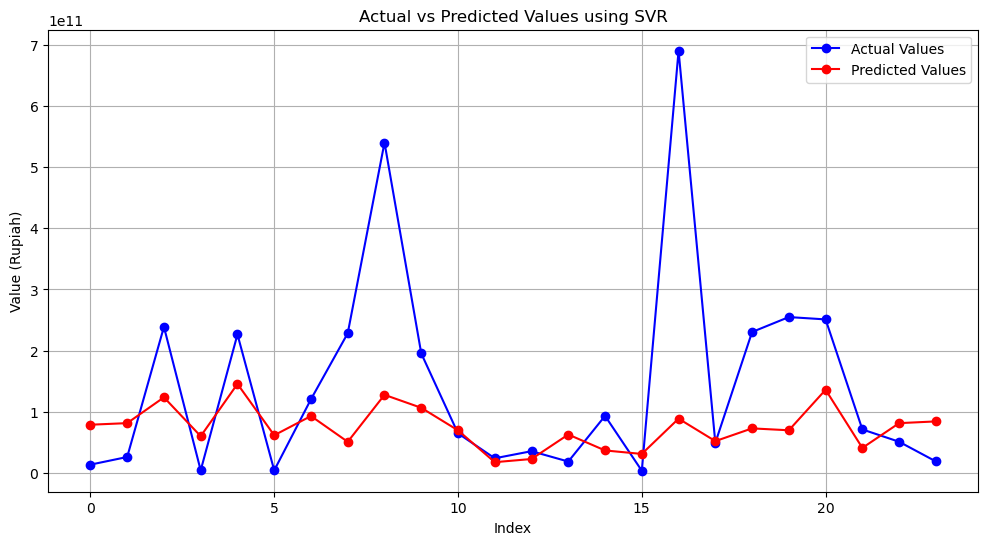

In [93]:
# Identify the best model based on Testing R² Score
best_model_name1 = results_df1.iloc[9]['Model']
best_model1 = models1[best_model_name1]

# Predict on the test data
y_pred_log1 = best_model1.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df1 = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df1.index, comparison_df1['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df1.index, comparison_df1['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name1}')
plt.legend()
plt.grid(True)
plt.show()


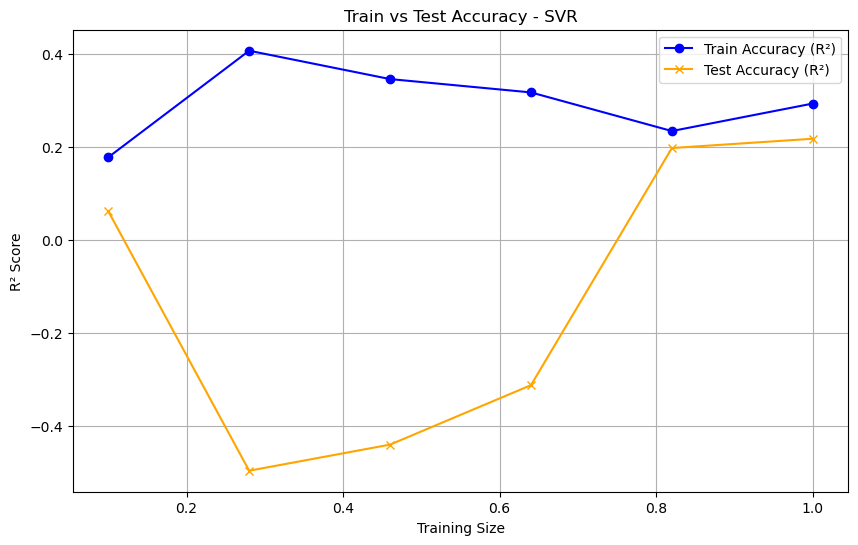

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes1 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best1 = []
test_accuracies_best1 = []

for size1 in training_sizes1:
    # Tentukan jumlah data training sesuai ukuran
    train_size1 = int(size1 * len(X_train1))
    X_train_subset1 = X_train1[:train_size1]
    y_train_subset1 = y_train1[:train_size1]
    
    # Fit model dengan subset data
    best_model1.fit(X_train_subset1, y_train_subset1)
    
    # Prediksi untuk data training dan testing
    y_train_pred1 = best_model1.predict(X_train_subset1)
    y_test_pred1 = best_model1.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best1.append(r2_score(y_train_subset1, y_train_pred1))
    test_accuracies_best1.append(r2_score(y_test1, y_test_pred1))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes1, train_accuracies_best1, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes1, test_accuracies_best1, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name1}')
plt.grid(True)
plt.legend()
plt.show()


Lasso Regression

In [95]:
# Ambil model terbaik dari split data 70:30
best_model_name1 = results_df1.iloc[10]['Model']
best_model1 = models1[best_model_name1]

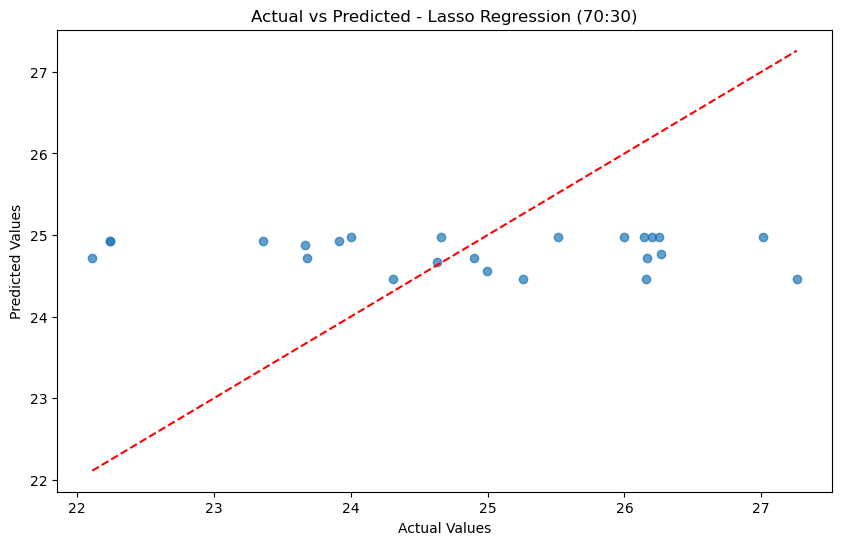

In [96]:
import matplotlib.pyplot as plt

y_actual1 = y_test1
y_pred_best1 = best_model1.predict(X_test1)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name1} (70:30)")
plt.show()

In [97]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})
# Tampilkan beberapa baris pertama
print(comparison1.head())

       Actual  Predicted
38  23.357097  24.926188
0   23.997354  24.978528
27  26.199729  24.978528
39  22.237415  24.926188
21  26.146404  24.978528


In [98]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah) Predicted (Rupiah)
38   Rp 13.927.029.001  Rp 66.881.491.090
0    Rp 26.419.136.187  Rp 70.475.263.992
27  Rp 239.000.000.001  Rp 70.475.263.992
39    Rp 4.545.551.009  Rp 66.881.491.090
21  Rp 226.589.000.001  Rp 70.475.263.992
35    Rp 4.545.551.009  Rp 66.881.491.090
10  Rp 120.781.089.488  Rp 70.475.263.992
92  Rp 228.530.000.001  Rp 41.756.978.600
4   Rp 540.031.588.145  Rp 70.475.263.992
13  Rp 195.596.000.001  Rp 70.475.263.992
64   Rp 65.000.000.001  Rp 54.247.894.801
41   Rp 24.322.000.001  Rp 66.881.491.090
88   Rp 35.905.245.001  Rp 41.756.978.600
43   Rp 18.970.782.261  Rp 63.470.976.866
89   Rp 93.541.144.803  Rp 41.756.978.600
59    Rp 3.997.225.850  Rp 54.247.894.801
95  Rp 690.000.000.001  Rp 41.756.978.600
78   Rp 49.559.404.693  Rp 51.481.610.529
72  Rp 230.570.298.290  Rp 54.247.894.801
52  Rp 254.967.000.193  Rp 57.162.821.055
9   Rp 251.146.002.001  Rp 70.475.263.992
83   Rp 71.420.000.001  Rp 46.365.035.416
5    Rp 51.300.531.487  Rp 70.475.

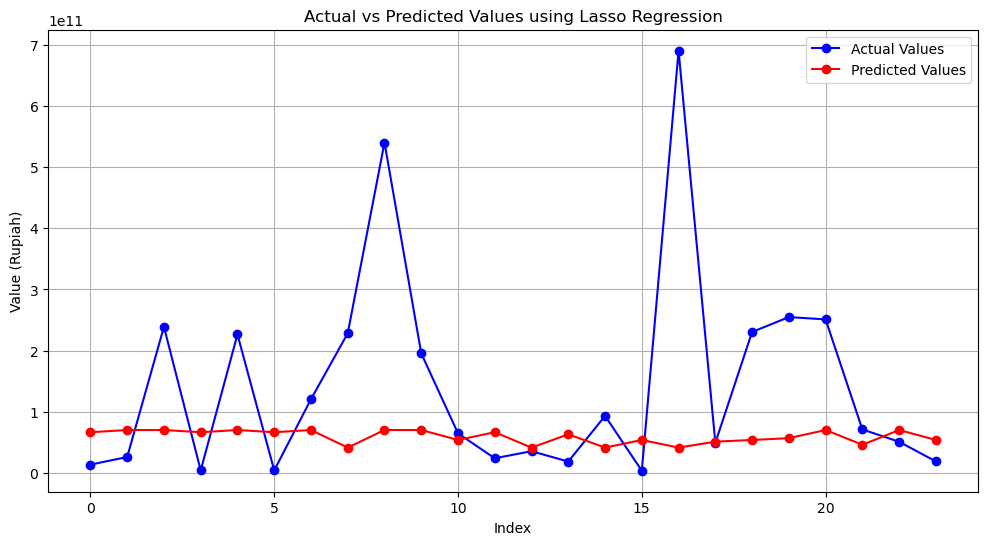

In [99]:
# Identify the best model based on Testing R² Score
best_model_name1 = results_df1.iloc[10]['Model']
best_model1 = models1[best_model_name1]

# Predict on the test data
y_pred_log1 = best_model1.predict(X_test1)

# If your target variable was log-transformed, revert it back
y_actual1 = np.exp(y_test1.reset_index(drop=True))
y_pred1 = np.exp(y_pred_log1)

# Create a DataFrame for comparison
comparison_df1 = pd.DataFrame({
    'Actual': y_actual1,
    'Predicted': y_pred1
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df1.index, comparison_df1['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df1.index, comparison_df1['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name1}')
plt.legend()
plt.grid(True)
plt.show()


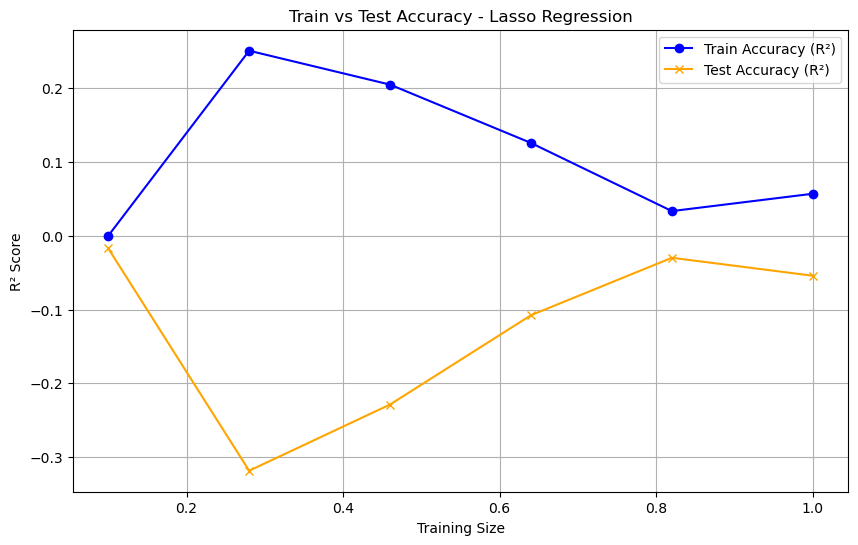

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes1 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best1 = []
test_accuracies_best1 = []

for size1 in training_sizes1:
    # Tentukan jumlah data training sesuai ukuran
    train_size1 = int(size1 * len(X_train1))
    X_train_subset1 = X_train1[:train_size1]
    y_train_subset1 = y_train1[:train_size1]
    
    # Fit model dengan subset data
    best_model1.fit(X_train_subset1, y_train_subset1)
    
    # Prediksi untuk data training dan testing
    y_train_pred1 = best_model1.predict(X_train_subset1)
    y_test_pred1 = best_model1.predict(X_test1)
    
    # Hitung R² Score
    train_accuracies_best1.append(r2_score(y_train_subset1, y_train_pred1))
    test_accuracies_best1.append(r2_score(y_test1, y_test_pred1))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes1, train_accuracies_best1, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes1, test_accuracies_best1, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name1}')
plt.grid(True)
plt.legend()
plt.show()


80:20

XGBoost

In [117]:
# Ambil model terbaik dari split data 70:30
best_model_name2 = results_df2.iloc[0]['Model']
best_model2 = models2[best_model_name2]

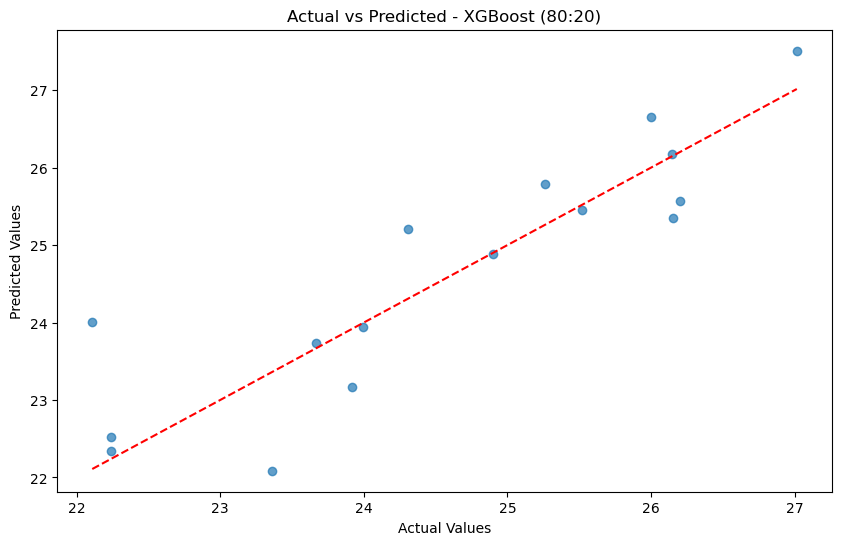

In [118]:
import matplotlib.pyplot as plt

y_actual2 = y_test2
y_pred_best2 = best_model2.predict(X_test2)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name2} (80:20)")
plt.show()

In [119]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2)

       Actual  Predicted
38  23.357097  22.086739
0   23.997354  23.944151
27  26.199729  25.574572
39  22.237415  22.528023
21  26.146404  26.179363
35  22.237415  22.338362
10  25.517246  25.456707
92  26.154933  25.348063
4   27.014893  27.509050
13  25.999317  26.655956
64  24.897653  24.879230
41  23.914647  23.165892
88  24.304149  25.212553
43  23.666166  23.737694
89  25.261667  25.781971
59  22.108866  24.003134


In [120]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.909.747.200
0    Rp 26.419.136.187   Rp 25.050.281.984
27  Rp 239.000.000.001  Rp 127.907.291.136
39    Rp 4.545.551.009    Rp 6.078.493.696
21  Rp 226.589.000.001  Rp 234.181.722.112
35    Rp 4.545.551.009    Rp 5.028.369.920
10  Rp 120.781.089.488  Rp 113.686.093.824
92  Rp 228.530.000.001  Rp 101.982.035.968
4   Rp 540.031.588.145  Rp 885.174.239.232
13  Rp 195.596.000.001  Rp 377.167.872.000
64   Rp 65.000.000.001   Rp 63.813.492.736
41   Rp 24.322.000.001   Rp 11.503.205.376
88   Rp 35.905.245.001   Rp 89.057.943.552
43   Rp 18.970.782.261   Rp 20.377.432.064
89   Rp 93.541.144.803  Rp 157.386.604.544
59    Rp 3.997.225.850   Rp 26.572.265.472


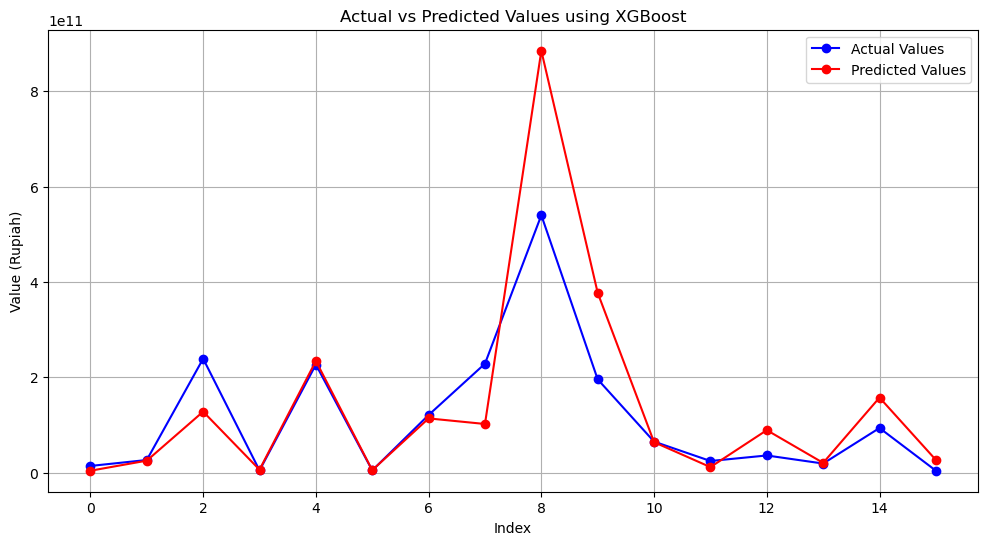

In [121]:
# Identify the best model based on Testing R² Score
best_model_name2 = results_df2.iloc[0]['Model']
best_model2 = models2[best_model_name2]

# Predict on the test data
y_pred_log2 = best_model2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name2}')
plt.legend()
plt.grid(True)
plt.show()


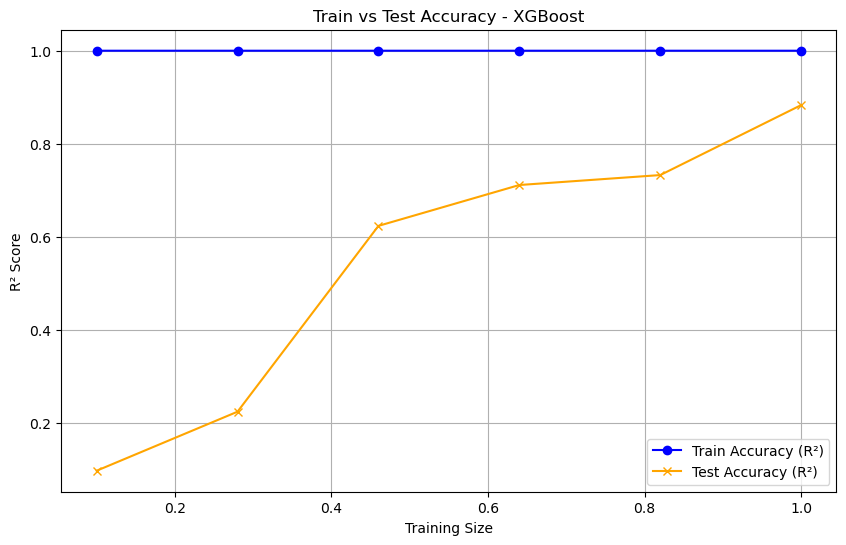

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    best_model2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = best_model2.predict(X_train_subset2)
    y_test_pred2 = best_model2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name2}')
plt.grid(True)
plt.legend()
plt.show()


Ridge Regression

In [123]:
# Ambil model terbaik dari split data 70:30
best_model_name2 = results_df2.iloc[1]['Model']
best_model2 = models2[best_model_name2]

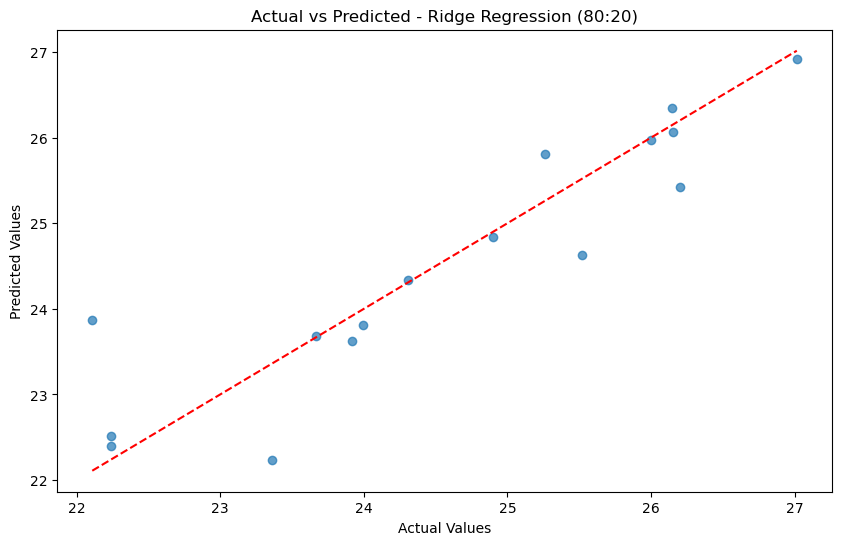

In [124]:
import matplotlib.pyplot as plt

y_actual2 = y_test2
y_pred_best2 = best_model2.predict(X_test2)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name2} (80:20)")
plt.show()

In [125]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2)

       Actual  Predicted
38  23.357097  22.234978
0   23.997354  23.807788
27  26.199729  25.425641
39  22.237415  22.402299
21  26.146404  26.341337
35  22.237415  22.517840
10  25.517246  24.630245
92  26.154933  26.062155
4   27.014893  26.919937
13  25.999317  25.975902
64  24.897653  24.838680
41  23.914647  23.623031
88  24.304149  24.338213
43  23.666166  23.682918
89  25.261667  25.811376
59  22.108866  23.870539


In [126]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 4.534.485.985
0    Rp 26.419.136.187   Rp 21.857.025.709
27  Rp 239.000.000.001  Rp 110.208.628.399
39    Rp 4.545.551.009    Rp 5.360.372.754
21  Rp 226.589.000.001  Rp 275.357.712.717
35    Rp 4.545.551.009    Rp 6.016.913.898
10  Rp 120.781.089.488   Rp 49.748.464.197
92  Rp 228.530.000.001  Rp 208.281.193.957
4   Rp 540.031.588.145  Rp 491.111.295.414
13  Rp 195.596.000.001  Rp 191.069.245.536
64   Rp 65.000.000.001   Rp 61.277.557.366
41   Rp 24.322.000.001   Rp 18.169.879.897
88   Rp 35.905.245.001   Rp 37.149.399.346
43   Rp 18.970.782.261   Rp 19.291.262.089
89   Rp 93.541.144.803  Rp 162.083.192.729
59    Rp 3.997.225.850   Rp 23.272.515.645


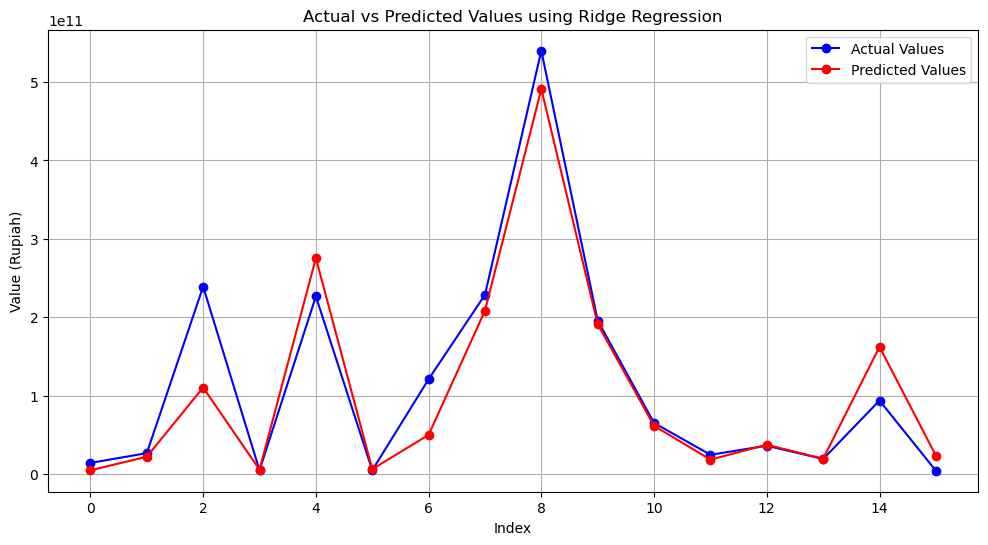

In [128]:
# Identify the best model based on Testing R² Score
best_model_name2 = results_df2.iloc[1]['Model']
best_model2 = models2[best_model_name2]

# Predict on the test data
y_pred_log2 = best_model2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name2}')
plt.legend()
plt.grid(True)
plt.show()


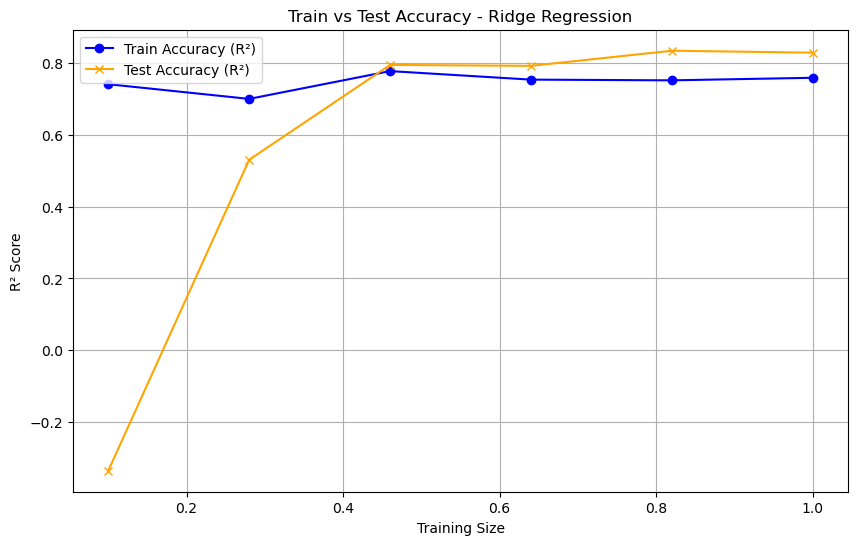

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    best_model2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = best_model2.predict(X_train_subset2)
    y_test_pred2 = best_model2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name2}')
plt.grid(True)
plt.legend()
plt.show()


Random Forest

In [130]:
# Ambil model terbaik dari split data 70:30
best_model_name2 = results_df2.iloc[2]['Model']
best_model2 = models2[best_model_name2]

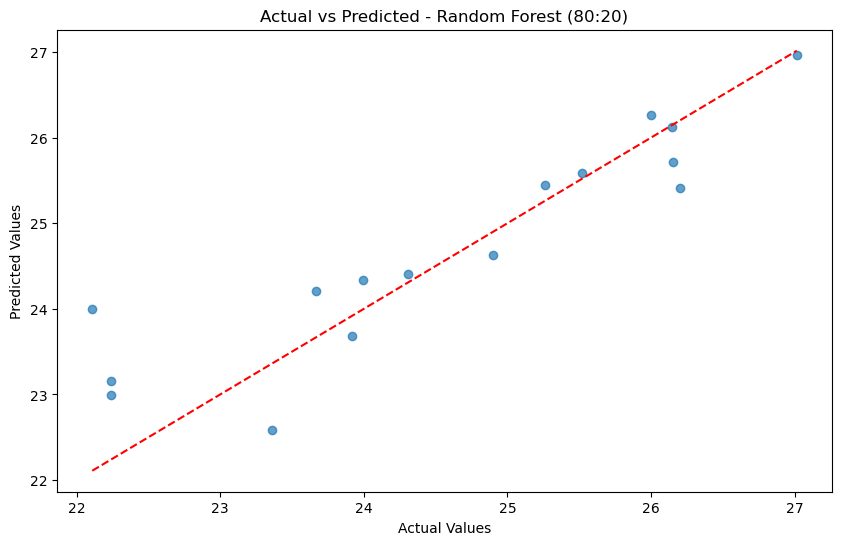

In [131]:
import matplotlib.pyplot as plt

y_actual2 = y_test2
y_pred_best2 = best_model2.predict(X_test2)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name2} (80:20)")
plt.show()

In [132]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2)

       Actual  Predicted
38  23.357097  22.587582
0   23.997354  24.338214
27  26.199729  25.412326
39  22.237415  22.990586
21  26.146404  26.127381
35  22.237415  23.151985
10  25.517246  25.587971
92  26.154933  25.715205
4   27.014893  26.959155
13  25.999317  26.264919
64  24.897653  24.629671
41  23.914647  23.684326
88  24.304149  24.402826
43  23.666166  24.203261
89  25.261667  25.446103
59  22.108866  23.995978


In [133]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 6.451.519.636
0    Rp 26.419.136.187   Rp 37.149.403.314
27  Rp 239.000.000.001  Rp 108.750.968.877
39    Rp 4.545.551.009    Rp 9.653.500.792
21  Rp 226.589.000.001  Rp 222.319.510.750
35    Rp 4.545.551.009   Rp 11.344.339.402
10  Rp 120.781.089.488  Rp 129.632.773.185
92  Rp 228.530.000.001  Rp 147.221.674.200
4   Rp 540.031.588.145  Rp 510.754.784.828
13  Rp 195.596.000.001  Rp 255.099.313.916
64   Rp 65.000.000.001   Rp 49.719.903.075
41   Rp 24.322.000.001   Rp 19.318.448.492
88   Rp 35.905.245.001   Rp 39.628.968.802
43   Rp 18.970.782.261   Rp 32.459.549.235
89   Rp 93.541.144.803  Rp 112.486.960.345
59    Rp 3.997.225.850   Rp 26.382.808.250


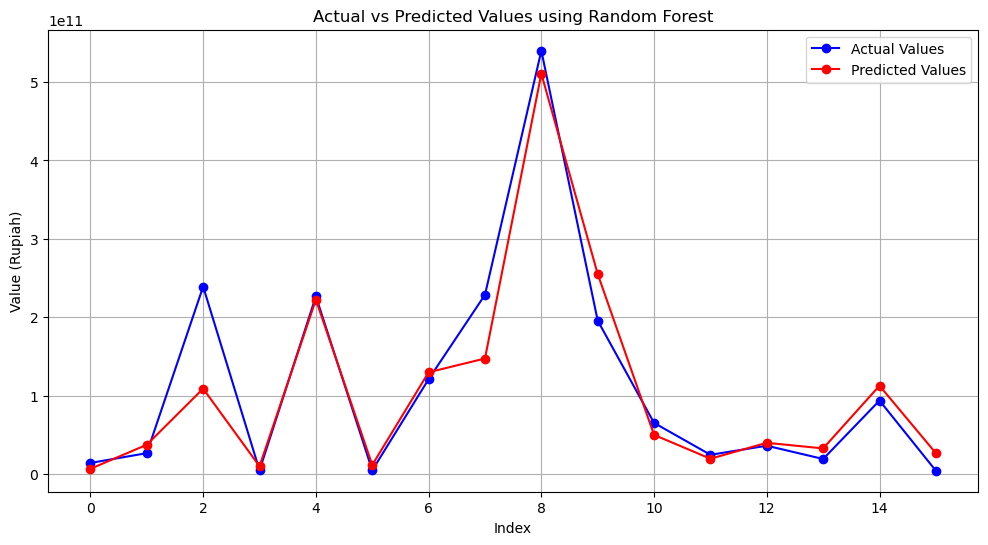

In [134]:
# Identify the best model based on Testing R² Score
best_model_name2 = results_df2.iloc[2]['Model']
best_model2 = models2[best_model_name2]

# Predict on the test data
y_pred_log2 = best_model2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name2}')
plt.legend()
plt.grid(True)
plt.show()


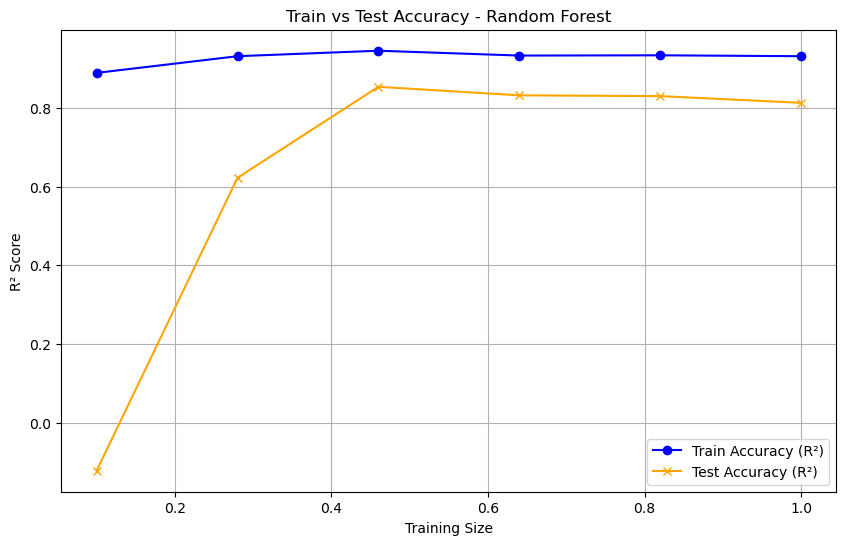

In [135]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    best_model2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = best_model2.predict(X_train_subset2)
    y_test_pred2 = best_model2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name2}')
plt.grid(True)
plt.legend()
plt.show()


Bayesian Ridge

In [136]:
# Ambil model terbaik dari split data 70:30
best_model_name2 = results_df2.iloc[3]['Model']
best_model2 = models2[best_model_name2]

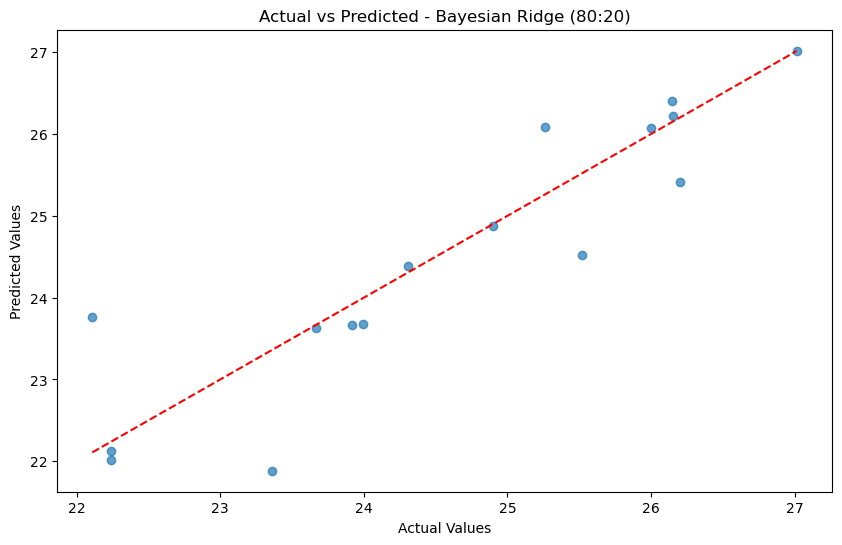

In [137]:
import matplotlib.pyplot as plt

y_actual2 = y_test2
y_pred_best2 = best_model2.predict(X_test2)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name2} (80:20)")
plt.show()

In [138]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2)

       Actual  Predicted
38  23.357097  21.885013
0   23.997354  23.672931
27  26.199729  25.415269
39  22.237415  22.015360
21  26.146404  26.402505
35  22.237415  22.127175
10  25.517246  24.522991
92  26.154933  26.216809
4   27.014893  27.017551
13  25.999317  26.067984
64  24.897653  24.881625
41  23.914647  23.671834
88  24.304149  24.382771
43  23.666166  23.626501
89  25.261667  26.084429
59  22.108866  23.765938


In [139]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 3.195.511.094
0    Rp 26.419.136.187   Rp 19.099.566.946
27  Rp 239.000.000.001  Rp 109.071.482.393
39    Rp 4.545.551.009    Rp 3.640.403.347
21  Rp 226.589.000.001  Rp 292.726.665.366
35    Rp 4.545.551.009    Rp 4.071.082.112
10  Rp 120.781.089.488   Rp 44.688.891.327
92  Rp 228.530.000.001  Rp 243.117.070.217
4   Rp 540.031.588.145  Rp 541.468.447.631
13  Rp 195.596.000.001  Rp 209.498.775.515
64   Rp 65.000.000.001   Rp 63.966.507.955
41   Rp 24.322.000.001   Rp 19.078.617.773
88   Rp 35.905.245.001   Rp 38.842.105.858
43   Rp 18.970.782.261   Rp 18.233.033.472
89   Rp 93.541.144.803  Rp 212.972.541.893
59    Rp 3.997.225.850   Rp 20.961.188.495


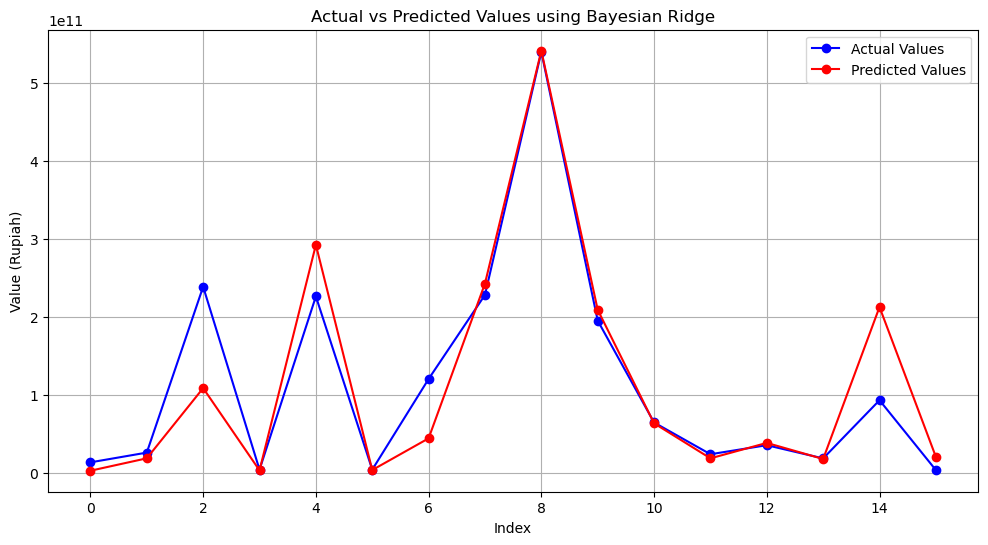

In [140]:
# Identify the best model based on Testing R² Score
best_model_name2 = results_df2.iloc[3]['Model']
best_model2 = models2[best_model_name2]

# Predict on the test data
y_pred_log2 = best_model2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name2}')
plt.legend()
plt.grid(True)
plt.show()


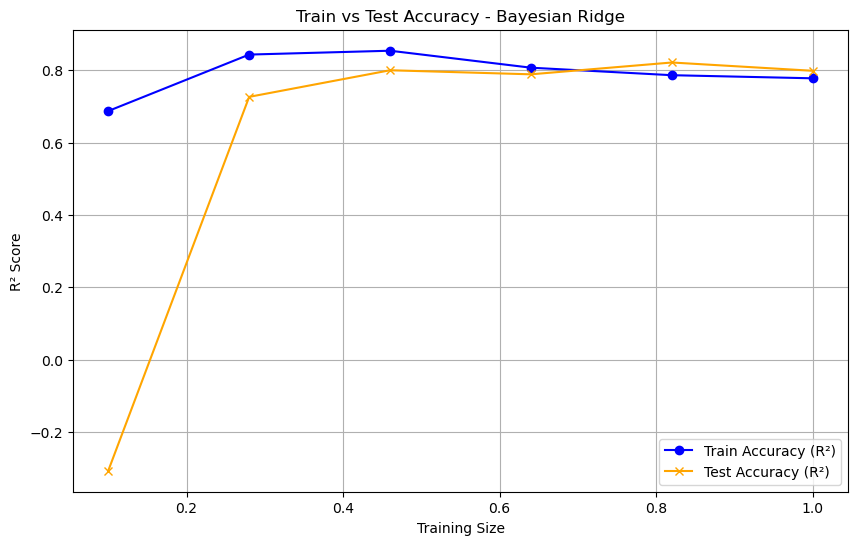

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    best_model2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = best_model2.predict(X_train_subset2)
    y_test_pred2 = best_model2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name2}')
plt.grid(True)
plt.legend()
plt.show()


Gradient Boosting

In [142]:
# Ambil model terbaik dari split data 70:30
best_model_name2 = results_df2.iloc[4]['Model']
best_model2 = models2[best_model_name2]

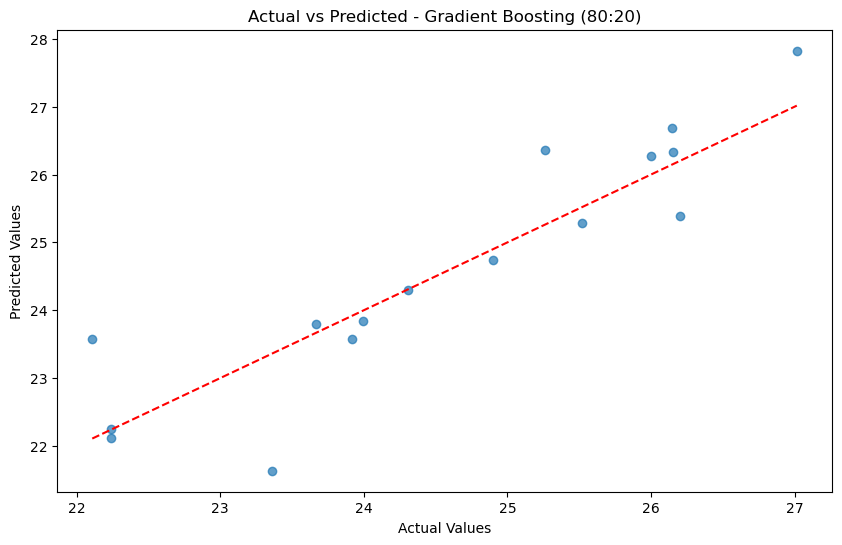

In [143]:
import matplotlib.pyplot as plt

y_actual2 = y_test2
y_pred_best2 = best_model2.predict(X_test2)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name2} (80:20)")
plt.show()

In [144]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2)

       Actual  Predicted
38  23.357097  21.634874
0   23.997354  23.848002
27  26.199729  25.392149
39  22.237415  22.117651
21  26.146404  26.689181
35  22.237415  22.246415
10  25.517246  25.291589
92  26.154933  26.330587
4   27.014893  27.824277
13  25.999317  26.274394
64  24.897653  24.743681
41  23.914647  23.579027
88  24.304149  24.299784
43  23.666166  23.791075
89  25.261667  26.365677
59  22.108866  23.571505


In [145]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)    Predicted (Rupiah)
38   Rp 13.927.029.001      Rp 2.488.320.429
0    Rp 26.419.136.187     Rp 22.753.890.674
27  Rp 239.000.000.001    Rp 106.578.623.843
39    Rp 4.545.551.009      Rp 4.032.495.709
21  Rp 226.589.000.001    Rp 389.909.578.142
35    Rp 4.545.551.009      Rp 4.586.646.362
10  Rp 120.781.089.488     Rp 96.382.370.313
92  Rp 228.530.000.001    Rp 272.413.620.966
4   Rp 540.031.588.145  Rp 1.213.192.710.823
13  Rp 195.596.000.001    Rp 257.527.918.424
64   Rp 65.000.000.001     Rp 55.724.246.264
41   Rp 24.322.000.001     Rp 17.387.673.560
88   Rp 35.905.245.001     Rp 35.748.839.324
43   Rp 18.970.782.261     Rp 21.494.755.094
89   Rp 93.541.144.803    Rp 282.142.185.241
59    Rp 3.997.225.850     Rp 17.257.370.140


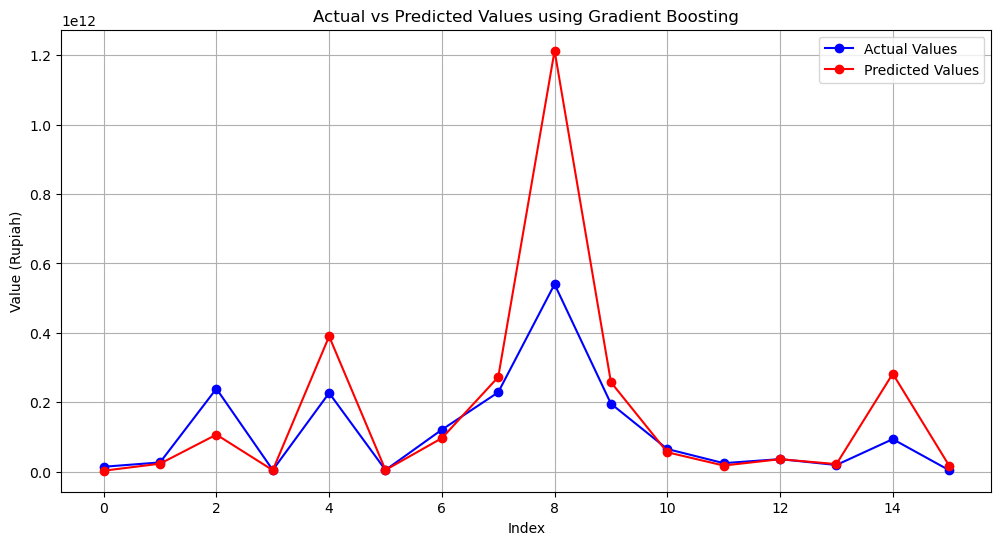

In [146]:
# Identify the best model based on Testing R² Score
best_model_name2 = results_df2.iloc[4]['Model']
best_model2 = models2[best_model_name2]

# Predict on the test data
y_pred_log2 = best_model2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name2}')
plt.legend()
plt.grid(True)
plt.show()


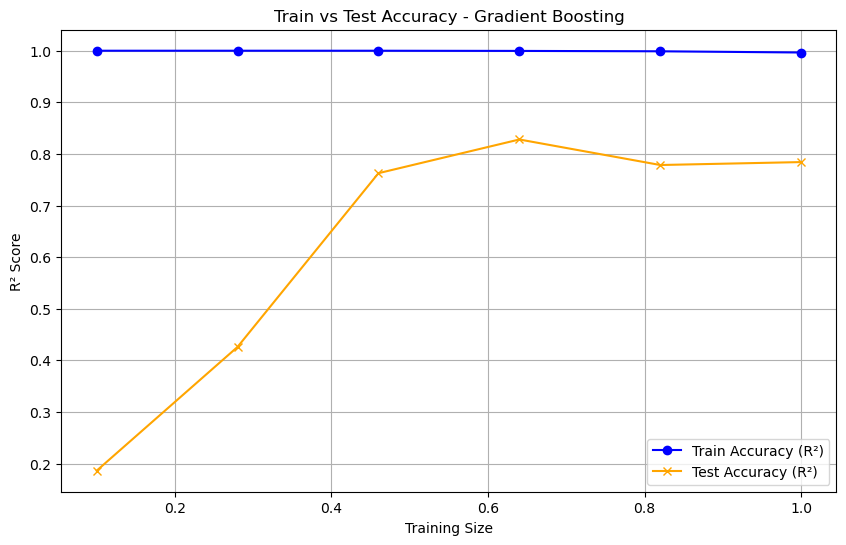

In [147]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    best_model2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = best_model2.predict(X_train_subset2)
    y_test_pred2 = best_model2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name2}')
plt.grid(True)
plt.legend()
plt.show()


Linear Regression

In [148]:
# Ambil model terbaik dari split data 70:30
best_model_name2 = results_df2.iloc[5]['Model']
best_model2 = models2[best_model_name2]

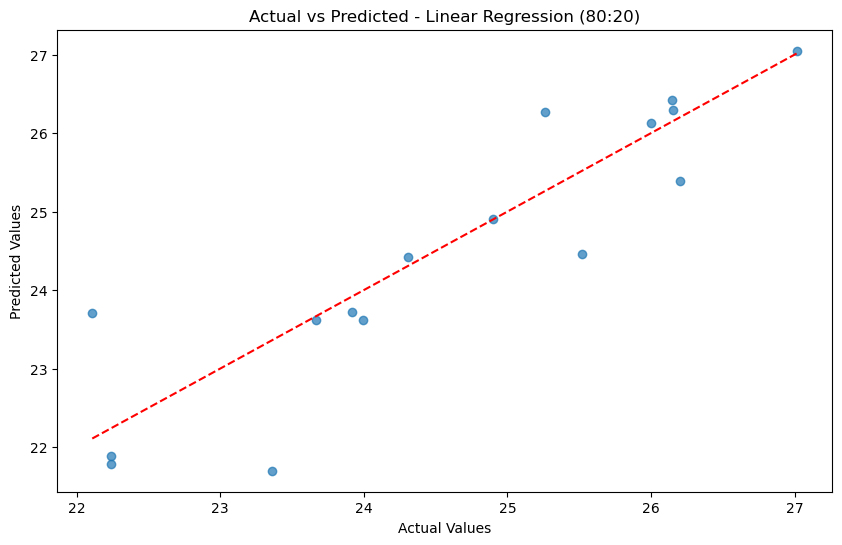

In [149]:
import matplotlib.pyplot as plt

y_actual2 = y_test2
y_pred_best2 = best_model2.predict(X_test2)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name2} (80:20)")
plt.show()

In [152]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2)

       Actual  Predicted
38  23.357097  21.698821
0   23.997354  23.615800
27  26.199729  25.393497
39  22.237415  21.782787
21  26.146404  26.424886
35  22.237415  21.888791
10  25.517246  24.456538
92  26.154933  26.296240
4   27.014893  27.049127
13  25.999317  26.122712
64  24.897653  24.906950
41  23.914647  23.715813
88  24.304149  24.415891
43  23.666166  23.621874
89  25.261667  26.273473
59  22.108866  23.712319


In [153]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 2.652.638.389
0    Rp 26.419.136.187   Rp 18.038.972.827
27  Rp 239.000.000.001  Rp 106.722.427.382
39    Rp 4.545.551.009    Rp 2.884.988.179
21  Rp 226.589.000.001  Rp 299.351.936.638
35    Rp 4.545.551.009    Rp 3.207.605.408
10  Rp 120.781.089.488   Rp 41.815.710.197
92  Rp 228.530.000.001  Rp 263.215.764.678
4   Rp 540.031.588.145  Rp 558.838.646.823
13  Rp 195.596.000.001  Rp 221.283.721.254
64   Rp 65.000.000.001   Rp 65.607.110.900
41   Rp 24.322.000.001   Rp 19.936.408.453
88   Rp 35.905.245.001   Rp 40.150.114.107
43   Rp 18.970.782.261   Rp 18.148.868.870
89   Rp 93.541.144.803  Rp 257.290.937.174
59    Rp 3.997.225.850   Rp 19.866.870.757


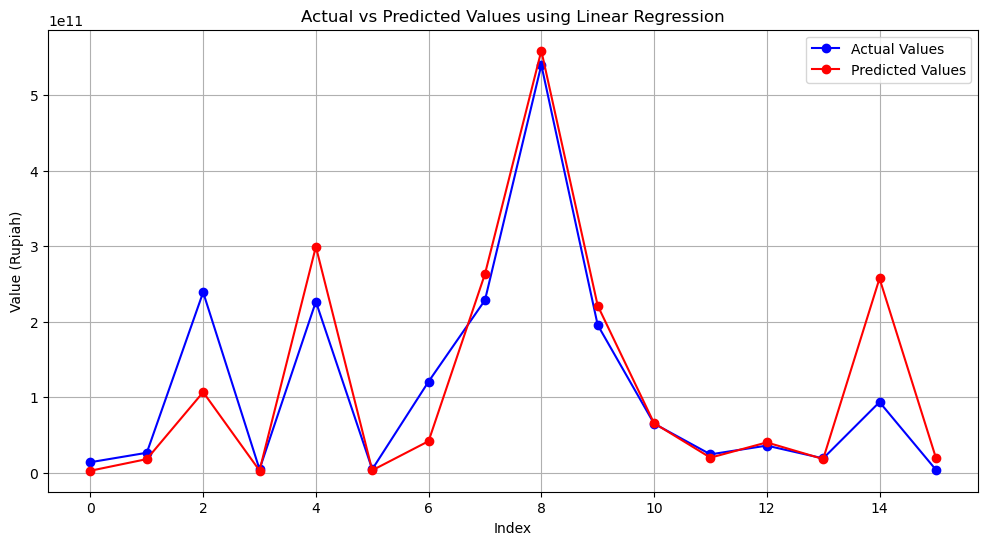

In [154]:
# Identify the best model based on Testing R² Score
best_model_name2 = results_df2.iloc[5]['Model']
best_model2 = models2[best_model_name2]

# Predict on the test data
y_pred_log2 = best_model2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name2}')
plt.legend()
plt.grid(True)
plt.show()


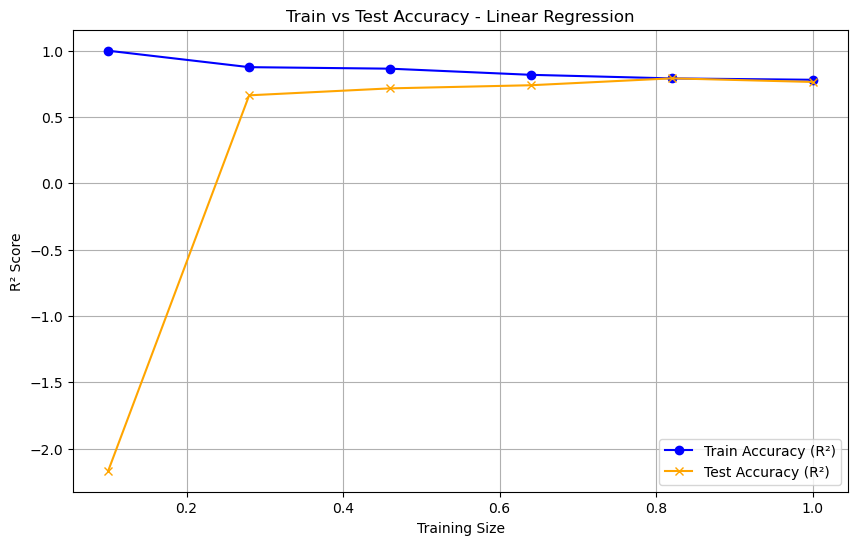

In [155]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    best_model2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = best_model2.predict(X_train_subset2)
    y_test_pred2 = best_model2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name2}')
plt.grid(True)
plt.legend()
plt.show()


AdaBoost

In [156]:
# Ambil model terbaik dari split data 70:30
best_model_name2 = results_df2.iloc[6]['Model']
best_model2 = models2[best_model_name2]

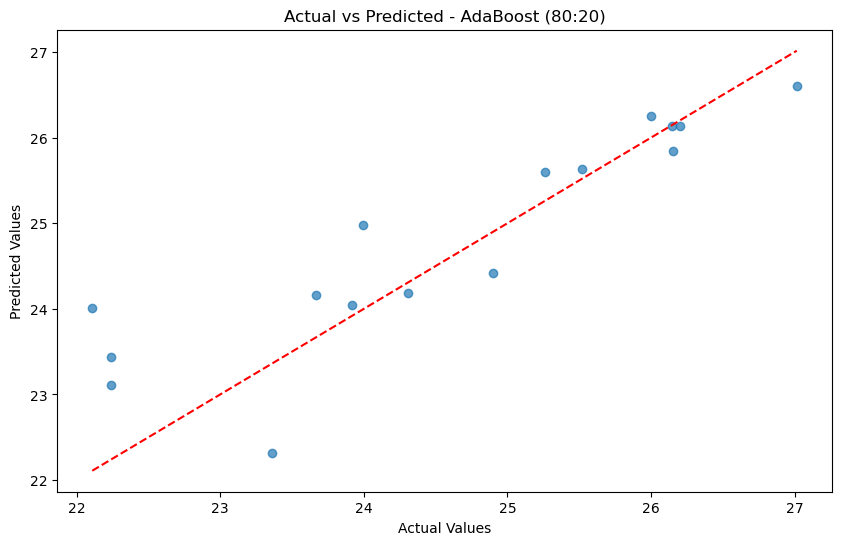

In [157]:
import matplotlib.pyplot as plt

y_actual2 = y_test2
y_pred_best2 = best_model2.predict(X_test2)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name2} (80:20)")
plt.show()

In [158]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2)

       Actual  Predicted
38  23.357097  22.320084
0   23.997354  24.973759
27  26.199729  26.135907
39  22.237415  23.107083
21  26.146404  26.135907
35  22.237415  23.440822
10  25.517246  25.630549
92  26.154933  25.841822
4   27.014893  26.599932
13  25.999317  26.255290
64  24.897653  24.416499
41  23.914647  24.041026
88  24.304149  24.180258
43  23.666166  24.160018
89  25.261667  25.597830
59  22.108866  24.011894


In [159]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 4.937.300.001
0    Rp 26.419.136.187   Rp 70.139.963.122
27  Rp 239.000.000.001  Rp 224.223.023.046
39    Rp 4.545.551.009   Rp 10.846.226.019
21  Rp 226.589.000.001  Rp 224.223.023.046
35    Rp 4.545.551.009   Rp 15.143.271.272
10  Rp 120.781.089.488  Rp 135.271.418.901
92  Rp 228.530.000.001  Rp 167.093.958.842
4   Rp 540.031.588.145  Rp 356.618.475.061
13  Rp 195.596.000.001  Rp 252.654.809.567
64   Rp 65.000.000.001   Rp 40.174.523.555
41   Rp 24.322.000.001   Rp 27.598.466.198
88   Rp 35.905.245.001   Rp 31.721.423.634
43   Rp 18.970.782.261   Rp 31.085.829.083
89   Rp 93.541.144.803  Rp 130.917.048.999
59    Rp 3.997.225.850   Rp 26.806.068.101


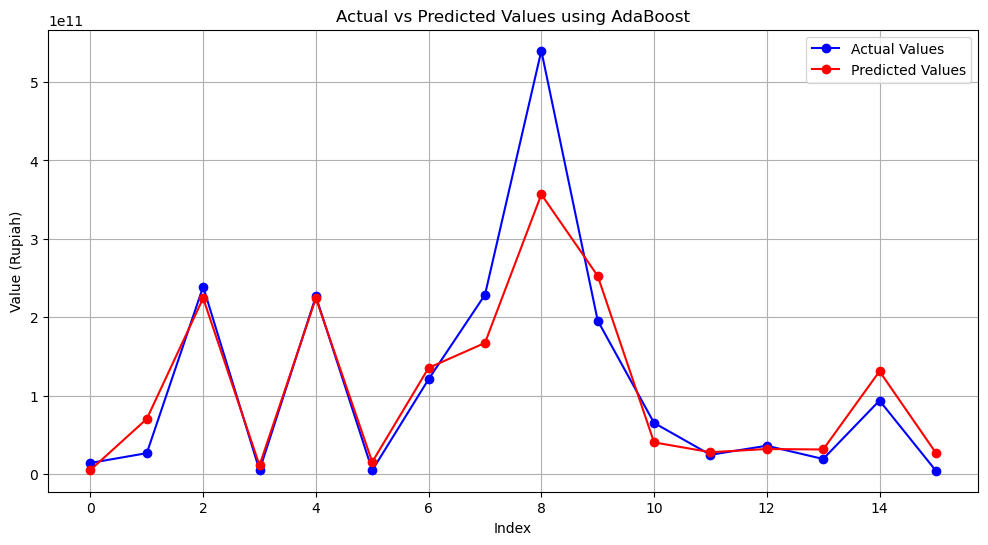

In [160]:
# Identify the best model based on Testing R² Score
best_model_name2 = results_df2.iloc[6]['Model']
best_model2 = models2[best_model_name2]

# Predict on the test data
y_pred_log2 = best_model2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name2}')
plt.legend()
plt.grid(True)
plt.show()


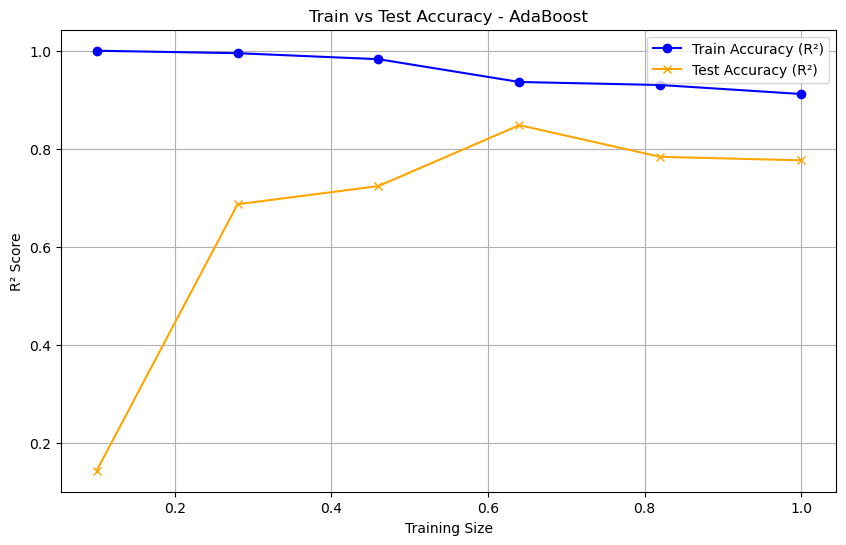

In [161]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    best_model2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = best_model2.predict(X_train_subset2)
    y_test_pred2 = best_model2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name2}')
plt.grid(True)
plt.legend()
plt.show()


Decision Tree

In [162]:
# Ambil model terbaik dari split data 70:30
best_model_name2 = results_df2.iloc[7]['Model']
best_model2 = models2[best_model_name2]

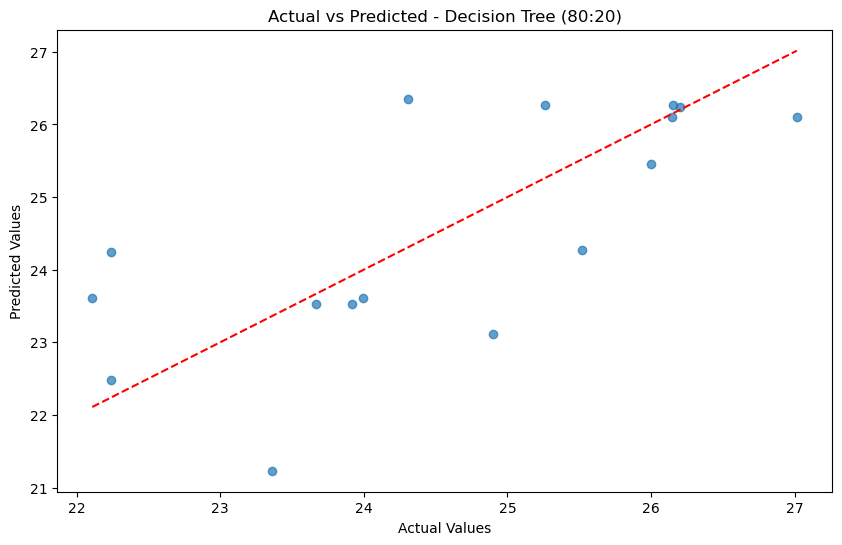

In [163]:
import matplotlib.pyplot as plt

y_actual2 = y_test2
y_pred_best2 = best_model2.predict(X_test2)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name2} (80:20)")
plt.show()

In [164]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2)

       Actual  Predicted
38  23.357097  21.231163
0   23.997354  23.608067
27  26.199729  26.244727
39  22.237415  24.243637
21  26.146404  26.107761
35  22.237415  22.478156
10  25.517246  24.270022
92  26.154933  26.264400
4   27.014893  26.107761
13  25.999317  25.455097
64  24.897653  23.107083
41  23.914647  23.522005
88  24.304149  26.343195
43  23.666166  23.528452
89  25.261667  26.264400
59  22.108866  23.608067


In [165]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 1.661.792.614
0    Rp 26.419.136.187   Rp 17.900.000.001
27  Rp 239.000.000.001  Rp 250.000.000.001
39    Rp 4.545.551.009   Rp 33.796.960.001
21  Rp 226.589.000.001  Rp 218.000.000.001
35    Rp 4.545.551.009    Rp 5.782.814.828
10  Rp 120.781.089.488   Rp 34.700.582.001
92  Rp 228.530.000.001  Rp 254.967.000.193
4   Rp 540.031.588.145  Rp 218.000.000.001
13  Rp 195.596.000.001  Rp 113.503.200.001
64   Rp 65.000.000.001   Rp 10.846.226.019
41   Rp 24.322.000.001   Rp 16.423.918.001
88   Rp 35.905.245.001  Rp 275.869.725.001
43   Rp 18.970.782.261   Rp 16.530.153.001
89   Rp 93.541.144.803  Rp 254.967.000.193
59    Rp 3.997.225.850   Rp 17.900.000.001


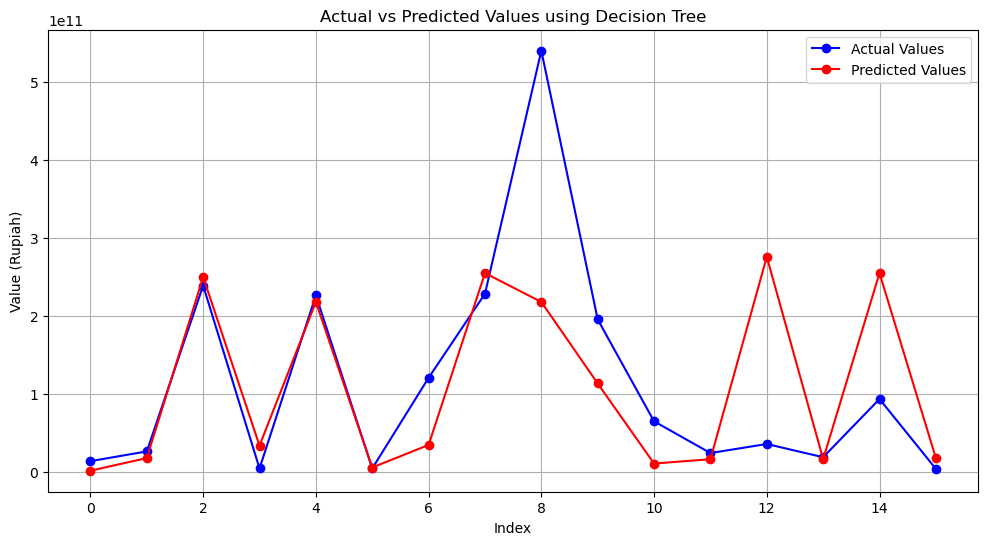

In [166]:
# Identify the best model based on Testing R² Score
best_model_name2 = results_df2.iloc[7]['Model']
best_model2 = models2[best_model_name2]

# Predict on the test data
y_pred_log2 = best_model2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name2}')
plt.legend()
plt.grid(True)
plt.show()


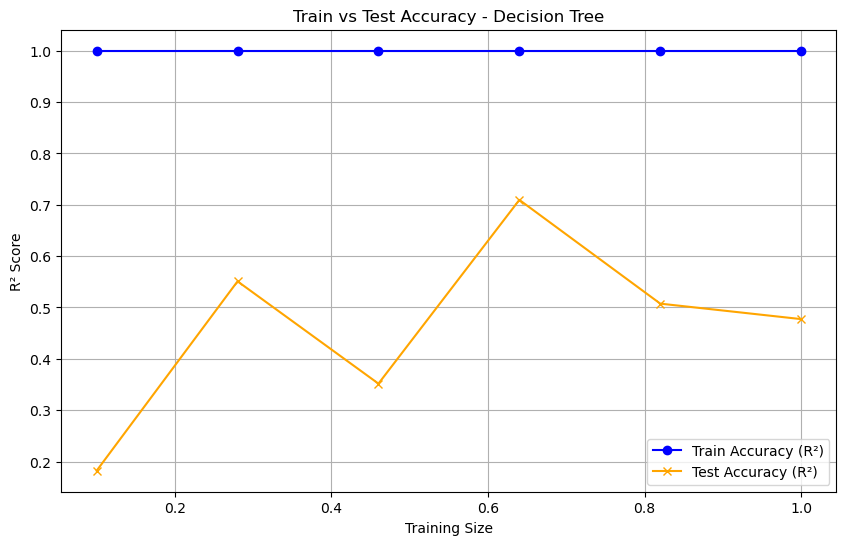

In [167]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    best_model2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = best_model2.predict(X_train_subset2)
    y_test_pred2 = best_model2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name2}')
plt.grid(True)
plt.legend()
plt.show()


KNN Regressor

In [168]:
# Ambil model terbaik dari split data 70:30
best_model_name2 = results_df2.iloc[8]['Model']
best_model2 = models2[best_model_name2]

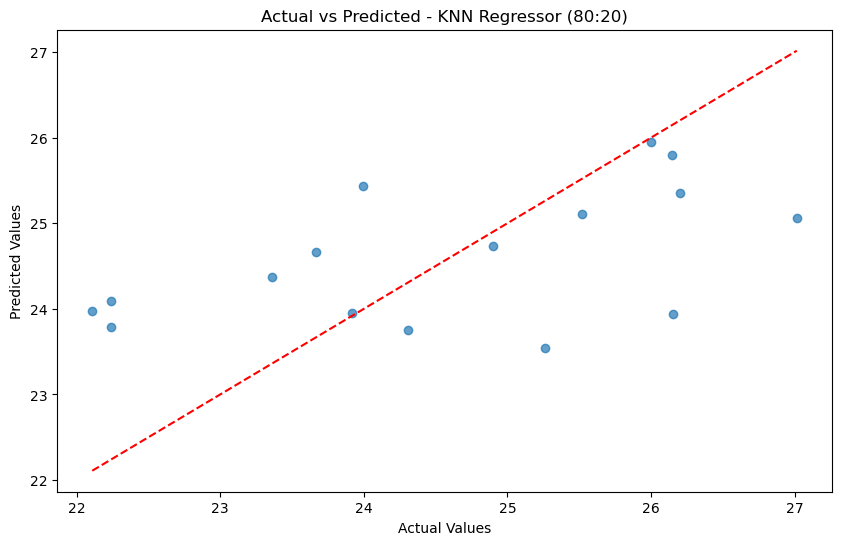

In [169]:
import matplotlib.pyplot as plt

y_actual2 = y_test2
y_pred_best2 = best_model2.predict(X_test2)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name2} (80:20)")
plt.show()

In [170]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2)

       Actual  Predicted
38  23.357097  24.366556
0   23.997354  25.429270
27  26.199729  25.347674
39  22.237415  24.095099
21  26.146404  25.795203
35  22.237415  23.791419
10  25.517246  25.113399
92  26.154933  23.933706
4   27.014893  25.058756
13  25.999317  25.945500
64  24.897653  24.739137
41  23.914647  23.956877
88  24.304149  23.755922
43  23.666166  24.663671
89  25.261667  23.545863
59  22.108866  23.974558


In [171]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001   Rp 38.217.368.885
0    Rp 26.419.136.187  Rp 110.609.306.932
27  Rp 239.000.000.001  Rp 101.942.384.332
39    Rp 4.545.551.009   Rp 29.131.869.639
21  Rp 226.589.000.001  Rp 159.482.962.894
35    Rp 4.545.551.009   Rp 21.502.145.458
10  Rp 120.781.089.488   Rp 80.651.159.427
92  Rp 228.530.000.001   Rp 24.789.991.616
4   Rp 540.031.588.145   Rp 76.362.351.050
13  Rp 195.596.000.001  Rp 185.347.739.565
64   Rp 65.000.000.001   Rp 55.471.619.895
41   Rp 24.322.000.001   Rp 25.371.102.310
88   Rp 35.905.245.001   Rp 20.752.281.623
43   Rp 18.970.782.261   Rp 51.439.457.892
89   Rp 93.541.144.803   Rp 16.820.478.065
59    Rp 3.997.225.850   Rp 25.823.678.674


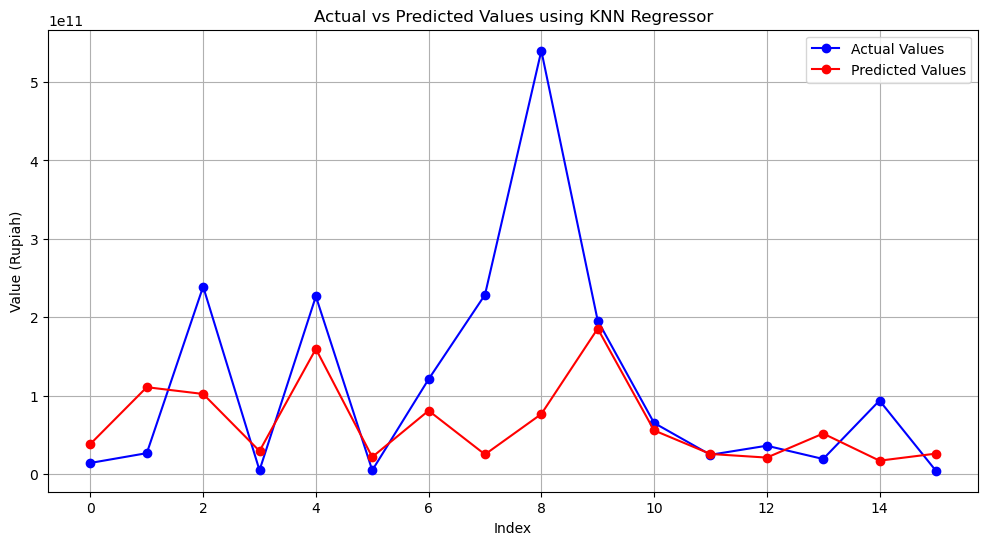

In [172]:
# Identify the best model based on Testing R² Score
best_model_name2 = results_df2.iloc[8]['Model']
best_model2 = models2[best_model_name2]

# Predict on the test data
y_pred_log2 = best_model2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name2}')
plt.legend()
plt.grid(True)
plt.show()


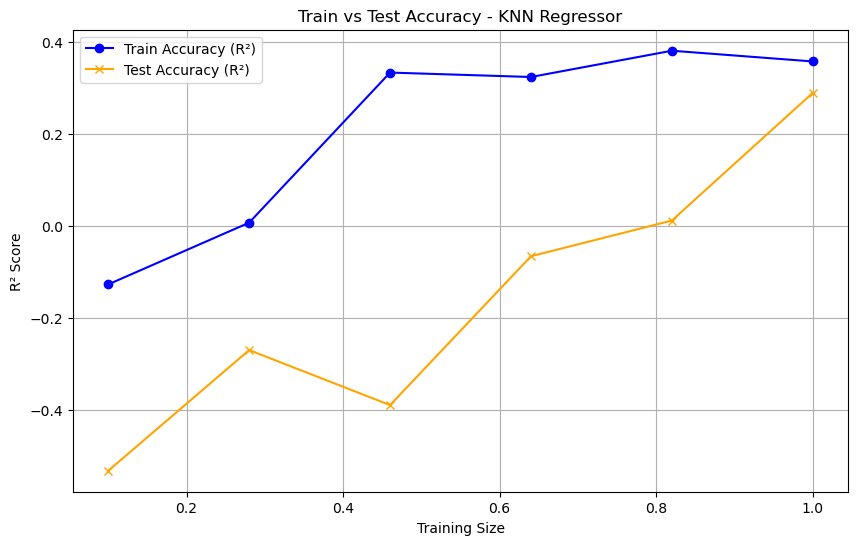

In [173]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    best_model2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = best_model2.predict(X_train_subset2)
    y_test_pred2 = best_model2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name2}')
plt.grid(True)
plt.legend()
plt.show()


SVR

In [174]:
# Ambil model terbaik dari split data 70:30
best_model_name2 = results_df2.iloc[9]['Model']
best_model2 = models2[best_model_name2]

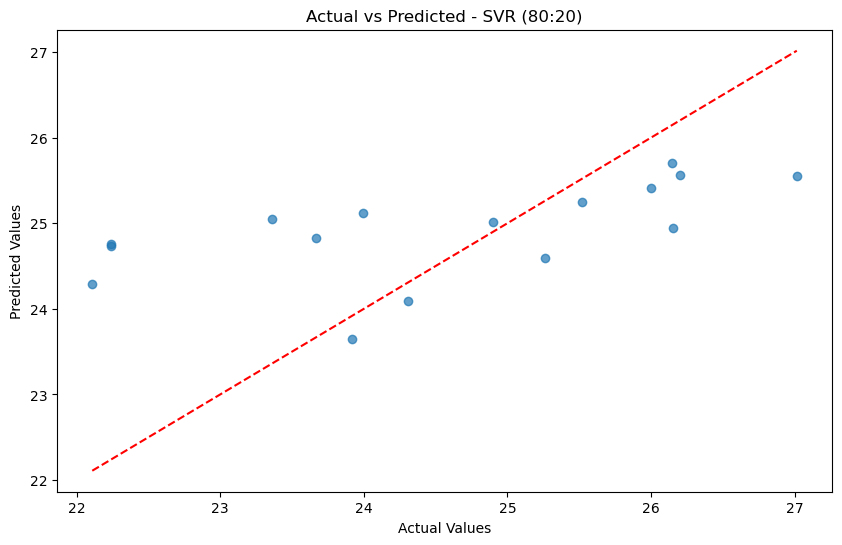

In [175]:
import matplotlib.pyplot as plt

y_actual2 = y_test2
y_pred_best2 = best_model2.predict(X_test2)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name2} (80:20)")
plt.show()

In [176]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2)

       Actual  Predicted
38  23.357097  25.047698
0   23.997354  25.122131
27  26.199729  25.558250
39  22.237415  24.739471
21  26.146404  25.699329
35  22.237415  24.762415
10  25.517246  25.252959
92  26.154933  24.942657
4   27.014893  25.556926
13  25.999317  25.415320
64  24.897653  25.013538
41  23.914647  23.650804
88  24.304149  24.093172
43  23.666166  24.825962
89  25.261667  24.596240
59  22.108866  24.290110


In [177]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001   Rp 75.522.644.581
0    Rp 26.419.136.187   Rp 81.358.502.563
27  Rp 239.000.000.001  Rp 125.836.576.203
39    Rp 4.545.551.009   Rp 55.490.109.771
21  Rp 226.589.000.001  Rp 144.902.773.398
35    Rp 4.545.551.009   Rp 56.778.035.072
10  Rp 120.781.089.488   Rp 92.730.073.879
92  Rp 228.530.000.001   Rp 67.992.058.915
4   Rp 540.031.588.145  Rp 125.670.115.104
13  Rp 195.596.000.001  Rp 109.076.995.264
64   Rp 65.000.000.001   Rp 72.986.344.115
41   Rp 24.322.000.001   Rp 18.681.583.148
88   Rp 35.905.245.001   Rp 29.075.808.811
43   Rp 18.970.782.261   Rp 60.503.168.391
89   Rp 93.541.144.803   Rp 48.085.177.413
59    Rp 3.997.225.850   Rp 35.404.696.509


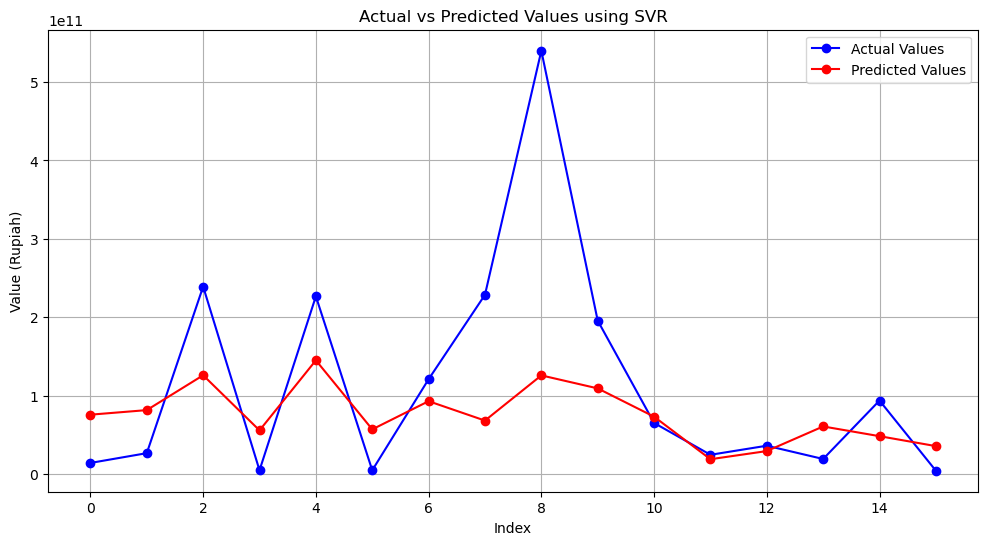

In [178]:
# Identify the best model based on Testing R² Score
best_model_name2 = results_df2.iloc[9]['Model']
best_model2 = models2[best_model_name2]

# Predict on the test data
y_pred_log2 = best_model2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name2}')
plt.legend()
plt.grid(True)
plt.show()


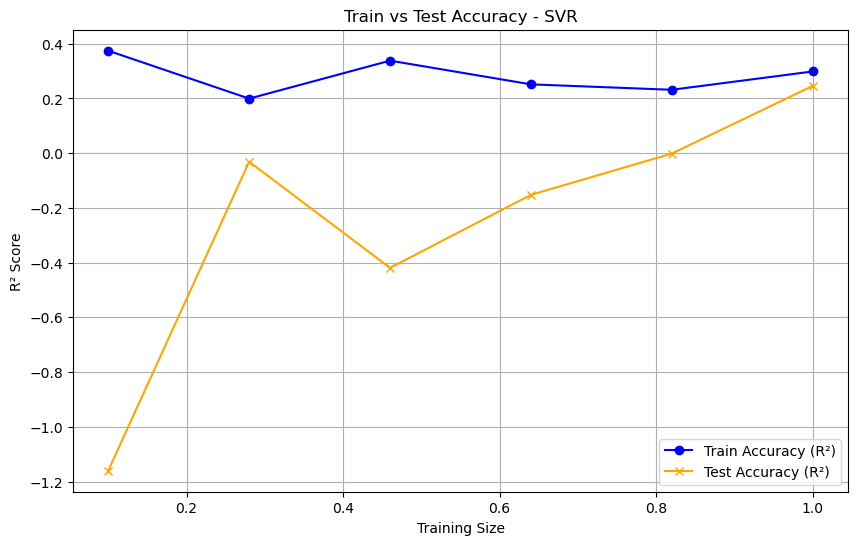

In [179]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    best_model2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = best_model2.predict(X_train_subset2)
    y_test_pred2 = best_model2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name2}')
plt.grid(True)
plt.legend()
plt.show()


Lasso Regression

In [180]:
# Ambil model terbaik dari split data 70:30
best_model_name2 = results_df2.iloc[10]['Model']
best_model2 = models2[best_model_name2]

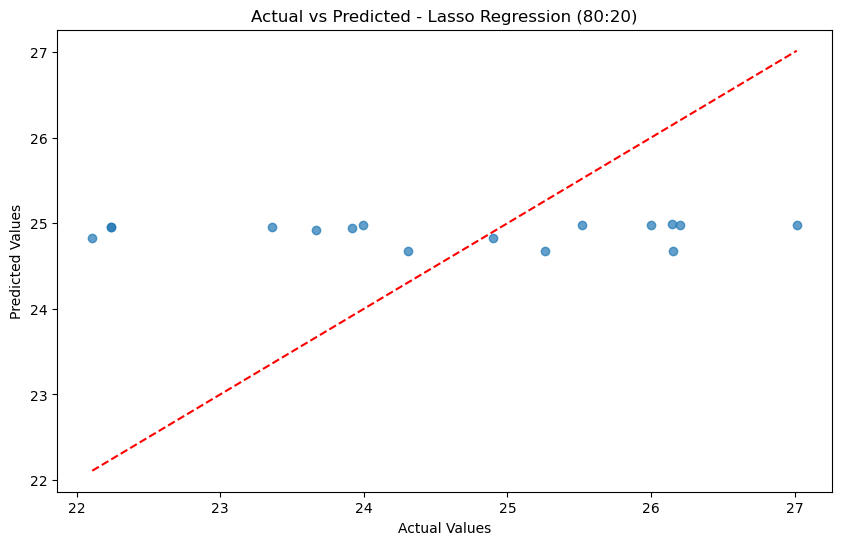

In [181]:
import matplotlib.pyplot as plt

y_actual2 = y_test2
y_pred_best2 = best_model2.predict(X_test2)

plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name2} (80:20)")
plt.show()

In [182]:
# Dataframe untuk 70:30
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})
# Tampilkan beberapa baris pertama
print(comparison2)

       Actual  Predicted
38  23.357097  24.953786
0   23.997354  24.982565
27  26.199729  24.984521
39  22.237415  24.951830
21  26.146404  24.986476
35  22.237415  24.951830
10  25.517246  24.982565
92  26.154933  24.677171
4   27.014893  24.984521
13  25.999317  24.982565
64  24.897653  24.830846
41  23.914647  24.940096
88  24.304149  24.673260
43  23.666166  24.921095
89  25.261667  24.675215
59  22.108866  24.824979


In [183]:
# Kembalikan nilai log ke bentuk asli
comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])

       Actual (Rupiah) Predicted (Rupiah)
38   Rp 13.927.029.001  Rp 68.752.964.035
0    Rp 26.419.136.187  Rp 70.760.379.549
27  Rp 239.000.000.001  Rp 70.898.893.982
39    Rp 4.545.551.009  Rp 68.618.642.084
21  Rp 226.589.000.001  Rp 71.037.679.558
35    Rp 4.545.551.009  Rp 68.618.642.084
10  Rp 120.781.089.488  Rp 70.760.379.549
92  Rp 228.530.000.001  Rp 52.138.570.159
4   Rp 540.031.588.145  Rp 70.898.893.982
13  Rp 195.596.000.001  Rp 70.760.379.549
64   Rp 65.000.000.001  Rp 60.799.399.323
41   Rp 24.322.000.001  Rp 67.818.203.357
88   Rp 35.905.245.001  Rp 51.935.044.001
43   Rp 18.970.782.261  Rp 66.541.729.586
89   Rp 93.541.144.803  Rp 52.036.707.576
59    Rp 3.997.225.850  Rp 60.443.745.602


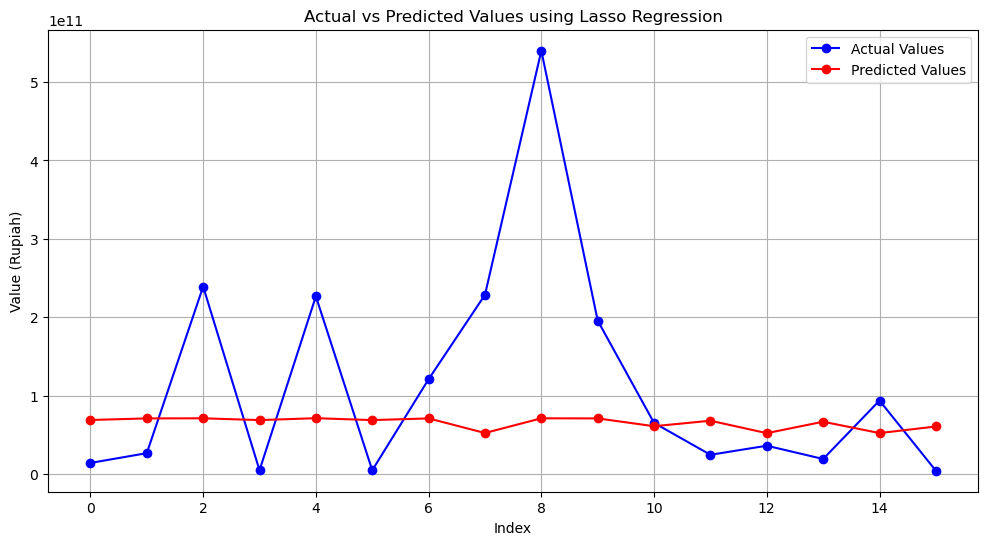

In [184]:
# Identify the best model based on Testing R² Score
best_model_name2 = results_df2.iloc[10]['Model']
best_model2 = models2[best_model_name2]

# Predict on the test data
y_pred_log2 = best_model2.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual2 = np.exp(y_test2.reset_index(drop=True))
y_pred2 = np.exp(y_pred_log2)

# Create a DataFrame for comparison
comparison_df2 = pd.DataFrame({
    'Actual': y_actual2,
    'Predicted': y_pred2
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df2.index, comparison_df2['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df2.index, comparison_df2['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name2}')
plt.legend()
plt.grid(True)
plt.show()


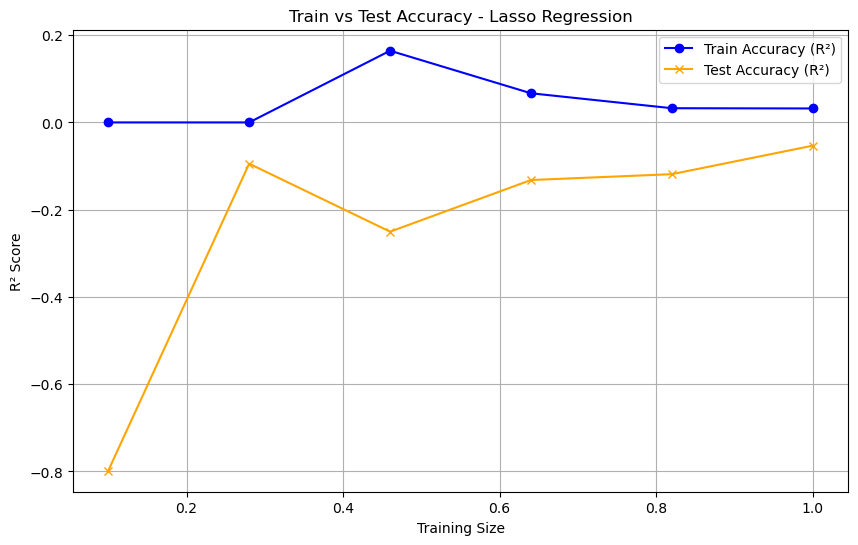

In [185]:
import numpy as np
import matplotlib.pyplot as plt

# Training sizes (misalnya dalam persen data training)
training_sizes2 = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best2 = []
test_accuracies_best2 = []

for size2 in training_sizes2:
    # Tentukan jumlah data training sesuai ukuran
    train_size2 = int(size2 * len(X_train2))
    X_train_subset2 = X_train2[:train_size2]
    y_train_subset2 = y_train2[:train_size2]
    
    # Fit model dengan subset data
    best_model2.fit(X_train_subset2, y_train_subset2)
    
    # Prediksi untuk data training dan testing
    y_train_pred2 = best_model2.predict(X_train_subset2)
    y_test_pred2 = best_model2.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best2.append(r2_score(y_train_subset2, y_train_pred2))
    test_accuracies_best2.append(r2_score(y_test2, y_test_pred2))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes2, train_accuracies_best2, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes2, test_accuracies_best2, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name2}')
plt.grid(True)
plt.legend()
plt.show()


Yang ke bawah ini program yang sebelumnya

In [20]:
# Ambil model terbaik dari split data 70:30
best_model_name1 = results_df1.iloc[0]['Model']
best_model1 = models1[best_model_name1]

# Ambil model terbaik dari split data 80:20
best_model_name2 = results_df2.iloc[0]['Model']
best_model2 = models2[best_model_name2]


In [21]:
# Prediksi nilai actual dan prediksi untuk 70:30
y_actual1 = y_test1
y_pred_best1 = best_model1.predict(X_test1)

# Prediksi nilai actual dan prediksi untuk 80:20
y_actual2 = y_test2
y_pred_best2 = best_model2.predict(X_test2)


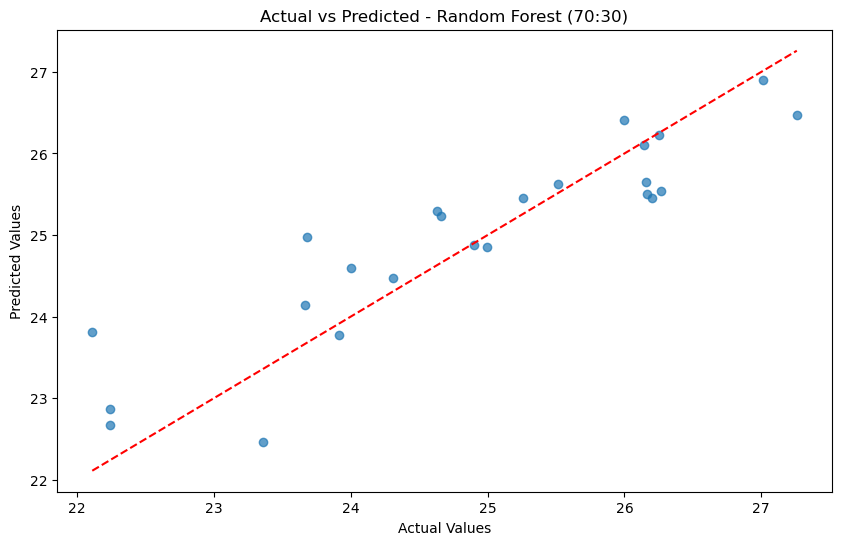

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_actual1, y_pred_best1, alpha=0.7)
plt.plot([y_actual1.min(), y_actual1.max()], [y_actual1.min(), y_actual1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name1} (70:30)")
plt.show()


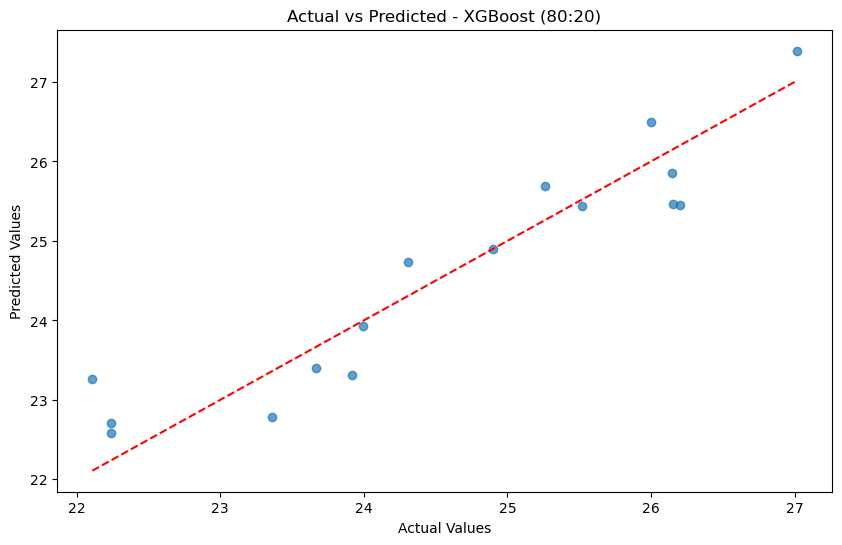

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_actual2, y_pred_best2, alpha=0.7)
plt.plot([y_actual2.min(), y_actual2.max()], [y_actual2.min(), y_actual2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted - {best_model_name2} (80:20)")
plt.show()


In [24]:
# Dataframe untuk 70:30
comparison1 = pd.DataFrame({'Actual': y_actual1, 'Predicted': y_pred_best1})

# Dataframe untuk 80:20
comparison2 = pd.DataFrame({'Actual': y_actual2, 'Predicted': y_pred_best2})

# Tampilkan beberapa baris pertama
print(comparison1.head())
print(comparison2.head())


       Actual  Predicted
38  23.357097  22.461849
0   23.997354  24.590898
27  26.199729  25.459510
39  22.237415  22.670800
21  26.146404  26.099098
       Actual  Predicted
38  23.357097  22.786304
0   23.997354  23.935417
27  26.199729  25.452826
39  22.237415  22.710232
21  26.146404  25.849052


In [25]:
# Kembalikan nilai log ke bentuk asli
comparison1['Actual (Original)'] = np.exp(comparison1['Actual'])
comparison1['Predicted (Original)'] = np.exp(comparison1['Predicted'])

comparison2['Actual (Original)'] = np.exp(comparison2['Actual'])
comparison2['Predicted (Original)'] = np.exp(comparison2['Predicted'])

# Format ke dalam Rupiah
def format_rupiah(value):
    return f"Rp {value:,.0f}".replace(",", ".")

comparison1['Actual (Rupiah)'] = comparison1['Actual (Original)'].apply(format_rupiah)
comparison1['Predicted (Rupiah)'] = comparison1['Predicted (Original)'].apply(format_rupiah)

comparison2['Actual (Rupiah)'] = comparison2['Actual (Original)'].apply(format_rupiah)
comparison2['Predicted (Rupiah)'] = comparison2['Predicted (Original)'].apply(format_rupiah)

# Tampilkan beberapa baris pertama
print(comparison1[['Actual (Rupiah)', 'Predicted (Rupiah)']])
print()
print("*" * 100)
print(comparison2[['Actual (Rupiah)', 'Predicted (Rupiah)']])


       Actual (Rupiah)  Predicted (Rupiah)
38   Rp 13.927.029.001    Rp 5.689.276.870
0    Rp 26.419.136.187   Rp 47.829.023.183
27  Rp 239.000.000.001  Rp 114.005.158.624
39    Rp 4.545.551.009    Rp 7.011.376.120
21  Rp 226.589.000.001  Rp 216.119.706.638
35    Rp 4.545.551.009    Rp 8.489.152.302
10  Rp 120.781.089.488  Rp 134.748.115.571
92  Rp 228.530.000.001  Rp 138.273.490.030
4   Rp 540.031.588.145  Rp 479.476.090.249
13  Rp 195.596.000.001  Rp 296.084.786.308
64   Rp 65.000.000.001   Rp 63.456.808.245
41   Rp 24.322.000.001   Rp 21.181.710.194
88   Rp 35.905.245.001   Rp 42.263.122.445
43   Rp 18.970.782.261   Rp 30.581.754.112
89   Rp 93.541.144.803  Rp 113.157.382.219
59    Rp 3.997.225.850   Rp 21.907.580.136
95  Rp 690.000.000.001  Rp 312.046.811.083
78   Rp 49.559.404.693   Rp 96.266.315.653
72  Rp 230.570.298.290  Rp 119.075.558.984
52  Rp 254.967.000.193  Rp 122.853.534.470
9   Rp 251.146.002.001  Rp 244.636.914.608
83   Rp 71.420.000.001   Rp 62.372.452.148
5    Rp 51.

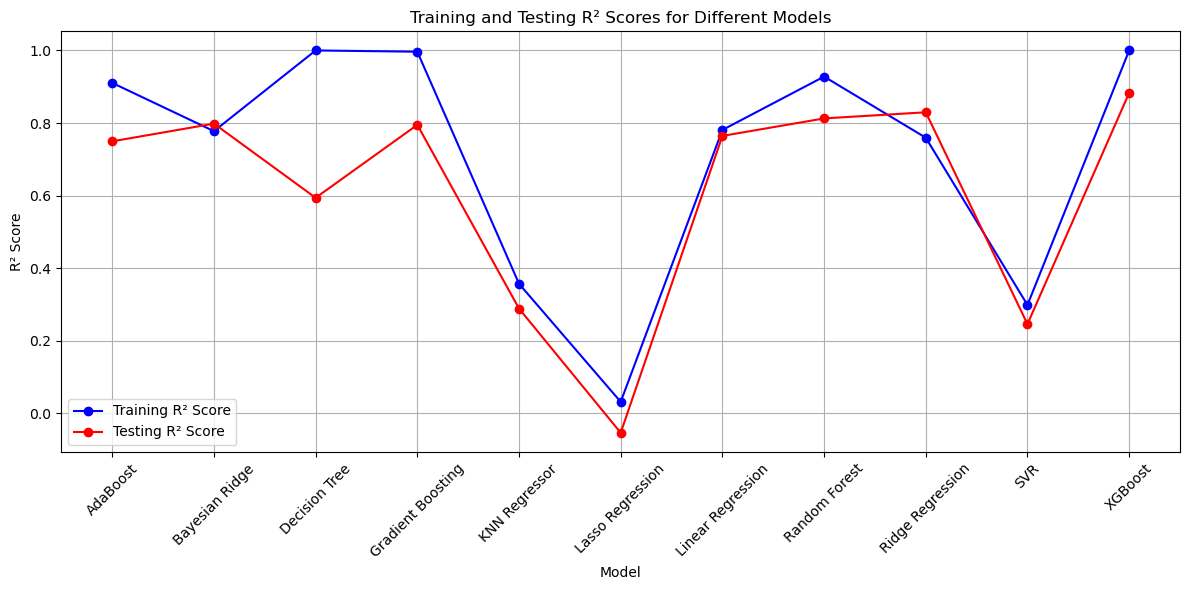

In [26]:
import matplotlib.pyplot as plt

# Extract model names and their corresponding R² scores
model_names = [r['Model'] for r in results2]
train_r2_scores = [r['Training R2 Score'] for r in results2]
test_r2_scores = [r['Testing R2 Score'] for r in results2]


# Set the figure size
plt.figure(figsize=(12, 6))

# Plot Training R² Scores
plt.plot(model_names, train_r2_scores, 'bo-', label='Training R² Score')

# Plot Testing R² Scores
plt.plot(model_names, test_r2_scores, 'ro-', label='Testing R² Score')

# Customize the plot
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Training and Testing R² Scores for Different Models')
plt.xticks(rotation=45)  # Rotate model names for better visibility
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


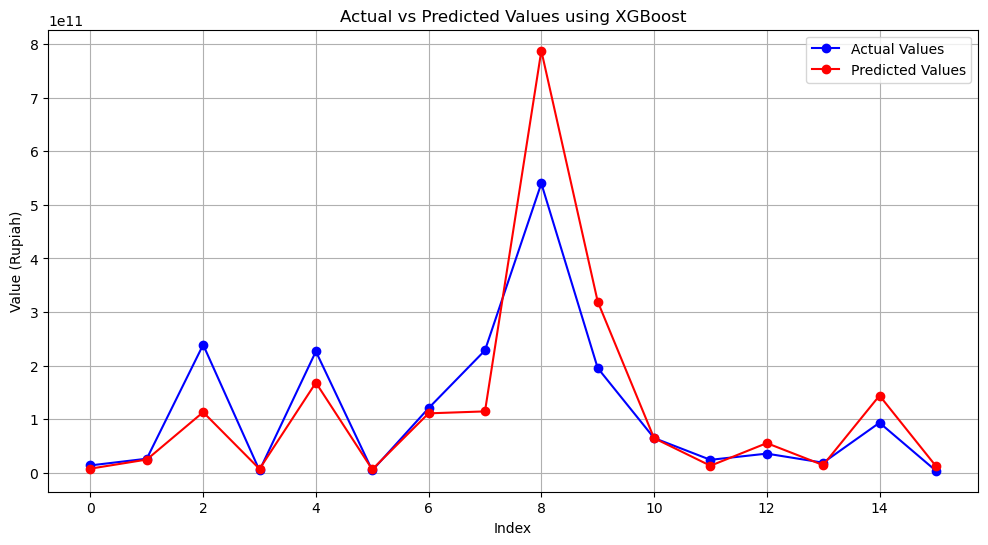

In [32]:
# Identify the best model based on Testing R² Score
best_model_name = results_df2.iloc[0]['Model']
best_model = models2[best_model_name]

# Predict on the test data
y_pred_log = best_model.predict(X_test2)

# If your target variable was log-transformed, revert it back
y_actual = np.exp(y_test2.reset_index(drop=True))
y_pred = np.exp(y_pred_log)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_actual,
    'Predicted': y_pred
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()


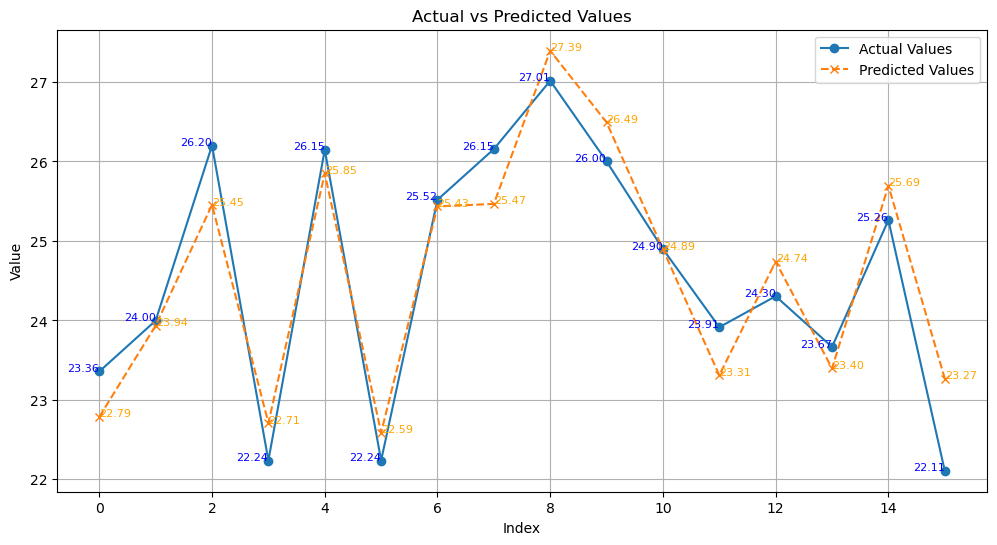

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Pastikan data berbentuk array (jika tidak, ubah dengan np.array)
y_test = np.array(y_test2)  # Nilai aktual
y_pred = np.array(y_pred_log)  # Nilai prediksi

# Buat plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', marker='o', linestyle='-')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', marker='x', linestyle='--')

# Tambahkan angka di setiap titik
for i, (y_actual, y_predict) in enumerate(zip(y_test, y_pred)):
    plt.text(i, y_actual, f'{y_actual:.2f}', fontsize=8, ha='right', color='blue')
    plt.text(i, y_predict, f'{y_predict:.2f}', fontsize=8, ha='left', color='orange')

# Tambahkan label dan judul
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)

# Tampilkan plot
plt.show()

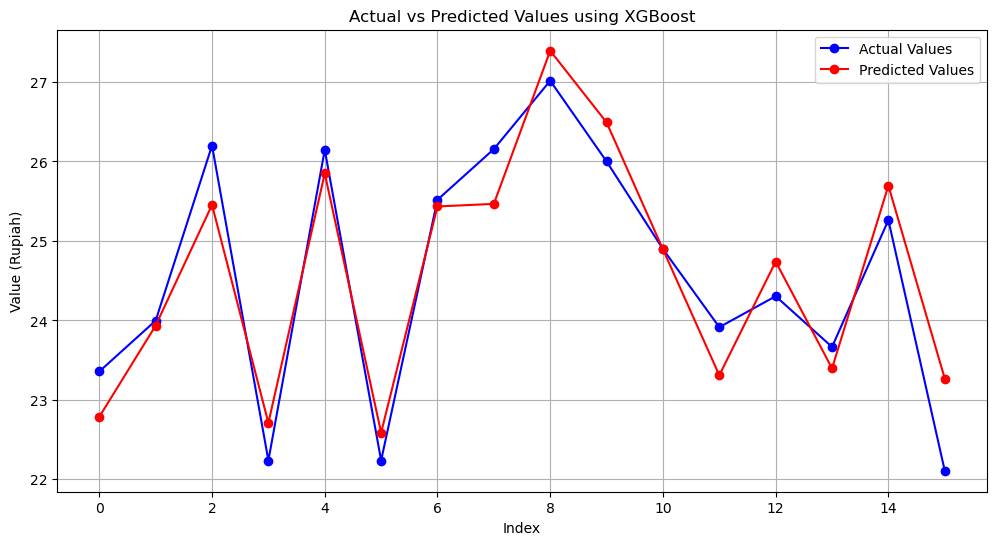

In [33]:
# Identify the best model based on Testing R² Score
best_model_name = results_df2.iloc[0]['Model']
best_model = models2[best_model_name]

# Predict on the test data
y_pred = best_model.predict(X_test2)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual': y_test2.reset_index(drop=True),
    'Predicted': y_pred
})

# Plot Actual vs Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], 'bo-', label='Actual Values')
plt.plot(comparison_df.index, comparison_df['Predicted'], 'ro-', label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value (Rupiah)')
plt.title(f'Actual vs Predicted Values using {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()


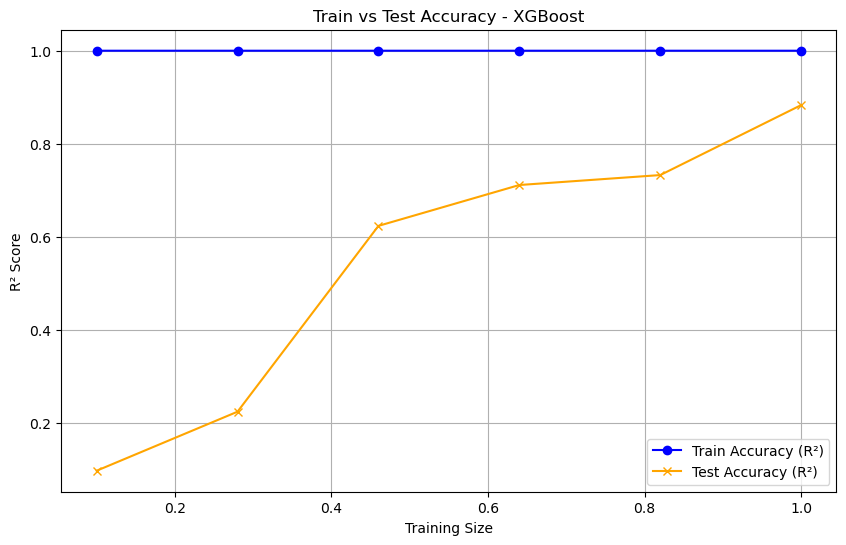

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Model terbaik dari results_df1
best_model_name = results_df2.iloc[0]['Model']
best_model = models2[best_model_name]

# Training sizes (misalnya dalam persen data training)
training_sizes = np.linspace(0.1, 1.0, 6)

# Menyimpan nilai R² untuk setiap training size
train_accuracies_best = []
test_accuracies_best = []

for size in training_sizes:
    # Tentukan jumlah data training sesuai ukuran
    train_size = int(size * len(X_train2))
    X_train_subset = X_train2[:train_size]
    y_train_subset = y_train2[:train_size]
    
    # Fit model dengan subset data
    best_model.fit(X_train_subset, y_train_subset)
    
    # Prediksi untuk data training dan testing
    y_train_pred = best_model.predict(X_train_subset)
    y_test_pred = best_model.predict(X_test2)
    
    # Hitung R² Score
    train_accuracies_best.append(r2_score(y_train_subset, y_train_pred))
    test_accuracies_best.append(r2_score(y_test2, y_test_pred))

# Plot Train vs Test Accuracy khusus model terbaik
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_accuracies_best, 'bo-', label='Train Accuracy (R²)')
plt.plot(training_sizes, test_accuracies_best, 'x-', color='orange', label='Test Accuracy (R²)')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title(f'Train vs Test Accuracy - {best_model_name}')
plt.grid(True)
plt.legend()
plt.show()


In [37]:
from sklearn.model_selection import cross_val_score

# Model terbaik
best_model_name = results_df2.iloc[0]['Model']
best_model = models2[best_model_name]

# Cross-validation
cv_folds = 5  # Jumlah lipatan (folds)
cv_scores = cross_val_score(best_model, X_train2, y_train2, cv=cv_folds, scoring='r2')

# Rata-rata dan standar deviasi R² Score dari cross-validation
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

# Tampilkan hasil
print(f"Cross-Validation Scores (R²): {cv_scores}")
print(f"Mean R² Score: {mean_cv_score:.4f}")
print(f"Standard Deviation: {std_cv_score:.4f}")


Cross-Validation Scores (R²): [0.20165794 0.71218577 0.15494194 0.23657382 0.46369003]
Mean R² Score: 0.3538
Standard Deviation: 0.2083


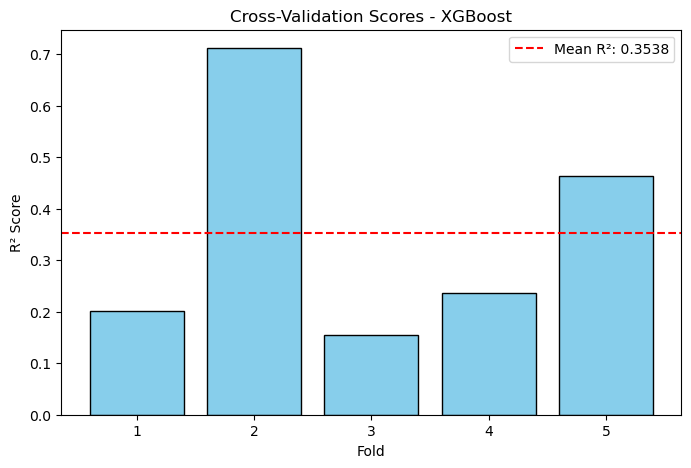

In [38]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, cv_folds + 1), cv_scores, color='skyblue', edgecolor='black')
plt.axhline(y=mean_cv_score, color='red', linestyle='--', label=f"Mean R²: {mean_cv_score:.4f}")
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title(f'Cross-Validation Scores - {best_model_name}')
plt.legend()
plt.show()


In [39]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Definisikan parameter yang akan dituning untuk model XGBoost
param_grid = {
    'n_estimators': [50, 100, 200, 300],       # Jumlah estimators
    'learning_rate': [0.01, 0.1, 0.2, 0.3],   # Learning rate
    'max_depth': [3, 5, 7, 9],                # Maksimum kedalaman pohon
    'subsample': [0.6, 0.8, 1.0],             # Proporsi sampel untuk membangun setiap pohon
    'colsample_bytree': [0.6, 0.8, 1.0],      # Proporsi fitur yang digunakan untuk setiap pohon
    'gamma': [0, 1, 5],                       # Minimum reduction loss untuk split
    'reg_alpha': [0, 0.1, 1],                 # Regularisasi L1
    'reg_lambda': [1, 2, 5]                   # Regularisasi L2
}

# Inisialisasi model XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

# Jalankan GridSearchCV
grid_search.fit(X_train2, y_train2)

# Hasil terbaik
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation R² Score: {best_score:.4f}")


Fitting 5 folds for each of 15552 candidates, totalling 77760 fits
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.6}
Best Cross-Validation R² Score: 0.6119


In [40]:
# Model dengan parameter terbaik
best_model_tuned = xgb.XGBRegressor(**best_params)
best_model_tuned.fit(X_train2, y_train2)

# Prediksi pada data testing
y_pred_tuned = best_model_tuned.predict(X_test2)

# Evaluasi performa
r2_tuned = r2_score(y_test2, y_pred_tuned)
print(f"Testing R² Score (Tuned Model): {r2_tuned:.4f}")


Testing R² Score (Tuned Model): 0.7977


Testing R² Score (Tuned Model): 0.7977


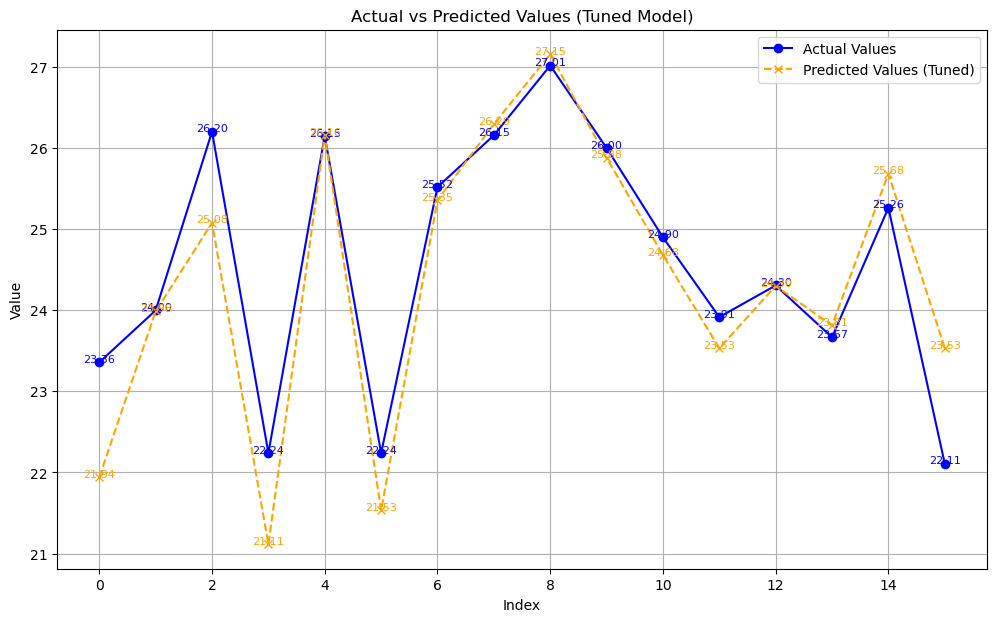

In [41]:
import matplotlib.pyplot as plt

# Model dengan parameter terbaik setelah tuning
best_model_tuned = xgb.XGBRegressor(**grid_search.best_params_)
best_model_tuned.fit(X_train2, y_train2)

# Prediksi pada data testing
y_pred_tuned = best_model_tuned.predict(X_test2)

# Evaluasi performa
r2_tuned = r2_score(y_test2, y_pred_tuned)
print(f"Testing R² Score (Tuned Model): {r2_tuned:.4f}")

# Visualisasi Hasil: Actual vs Predicted
plt.figure(figsize=(12, 7))
plt.plot(range(len(y_test2)), y_test2, 'o-', label='Actual Values', color='blue')
plt.plot(range(len(y_pred_tuned)), y_pred_tuned, 'x--', label='Predicted Values (Tuned)', color='orange')
for i, (a, p) in enumerate(zip(y_test2, y_pred_tuned)):
    plt.text(i, a, f"{a:.2f}", color="blue", fontsize=8, ha='center')
    plt.text(i, p, f"{p:.2f}", color="orange", fontsize=8, ha='center')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (Tuned Model)')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
print("Best Parameters after Tuning:", grid_search.best_params_)


Best Parameters after Tuning: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.6}


Testing R² Score (Tuned Model): 0.7977


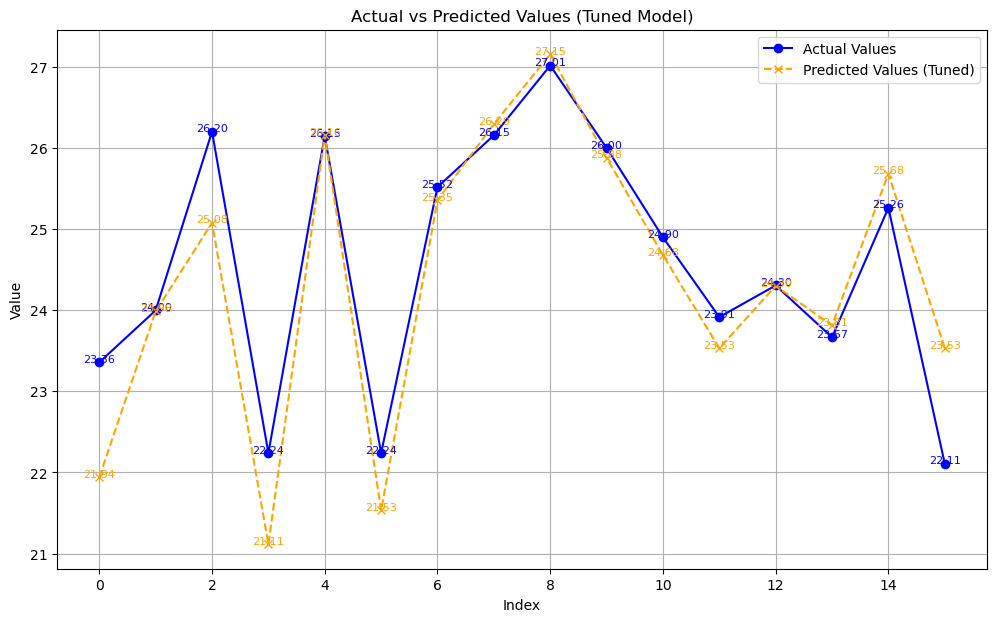

In [46]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree= 1.0, 
    gamma= 0, 
    learning_rate= 0.1, 
    max_depth= 3, 
    n_estimators= 100, 
    reg_alpha= 0, 
    reg_lambda= 2, 
    subsample= 0.6
)

xgb_model.fit(X_train2, y_train2)

# Prediksi pada data testing
y_pred_tuned = xgb_model.predict(X_test2)

# Evaluasi performa
r2_tuned = r2_score(y_test2, y_pred_tuned)
print(f"Testing R² Score (Tuned Model): {r2_tuned:.4f}")

# Visualisasi Hasil: Actual vs Predicted
plt.figure(figsize=(12, 7))
plt.plot(range(len(y_test2)), y_test2, 'o-', label='Actual Values', color='blue')
plt.plot(range(len(y_pred_tuned)), y_pred_tuned, 'x--', label='Predicted Values (Tuned)', color='orange')
for i, (a, p) in enumerate(zip(y_test2, y_pred_tuned)):
    plt.text(i, a, f"{a:.2f}", color="blue", fontsize=8, ha='center')
    plt.text(i, p, f"{p:.2f}", color="orange", fontsize=8, ha='center')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (Tuned Model)')
plt.legend()
plt.grid(True)
plt.show()